In [0]:
!pip install psynlig
!pip install category_encoders
!pip install xgboost
!pip install lightgbm
!pip install scikit-survival
!pip install shap
!pip install imbalanced-learn

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.r

In [0]:
dbutils.library.restartPython()

In [0]:
import psynlig
import sklearn
import imblearn
import xgboost
import lightgbm
import shap
import sksurv

In [0]:
print('psynlig:', psynlig.__version__)
print('scikit-learn:', sklearn.__version__)
print('imbalanced-learn:', imblearn.__version__)
print('xgboost:', xgboost.__version__)
print('lightgbm:', lightgbm.__version__)
print('shap:', shap.__version__)
print('scikit-survival:', sksurv.__version__)

psynlig: 0.2.2.dev0+c5d0f73
scikit-learn: 1.5.2
imbalanced-learn: 0.12.4
xgboost: 2.1.3
lightgbm: 4.5.0
shap: 0.46.0
scikit-survival: 0.23.1


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from psynlig import plot_correlation_heatmap
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import CountEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc, precision_score, recall_score, f1_score, accuracy_score, average_precision_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
import shap
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

In [0]:
original_df = pd.read_csv("df_202110_202212_anonymized.csv")

In [0]:
original_df.shape

(772766, 88)

In [0]:
original_df = original_df.sort_values(by='ReportingPeriod', ascending=True)
original_df = original_df.reset_index(drop=True)

In [0]:
# Extract 'Time_to_Event' and 'Censoring_Status' into a separate DataFrame
time_and_censoring = original_df[['Time_to_Event', 'Censoring_Status']].copy()
original_df = original_df.drop(columns=['Time_to_Event', 'Censoring_Status'])

In [0]:
time_and_censoring.head()

Time_to_Event  Censoring_Status
0             14                 0
1             14                 0
2             14                 0
3             23                 1
4             14                 0

In [0]:
pd.set_option('display.max_rows', None)
original_df.dtypes

Obligor_ID                                            object
ReportingPeriod                                        int64
Country                                               object
Industry                                              object
Product                                               object
ApplicationCount                                       int64
AgreementCount                                         int64
GroupExposure_1                                      float64
GroupExposure_2                                      float64
AverageDaysPastDue                                   float64
AverageDaysPastDue_Ever                              float64
AverageDaysPastDue_Last12Months                      float64
AverageDaysPastDue_Last6Months                       float64
ContractActive_Last12Months                            int64
ContractLastActivateDate                               int64
ContractsActiveCount                                   int64
ContractsAge_Category3Co

## 1. EDA & Data Cleaning & Feature Engineering

#### 1.1 EDA

In [0]:
# 1. Check missing values

missing_percentage = original_df.isnull().mean() * 100
original_df = original_df.loc[:, missing_percentage < 50]
original_df.shape

(772766, 67)

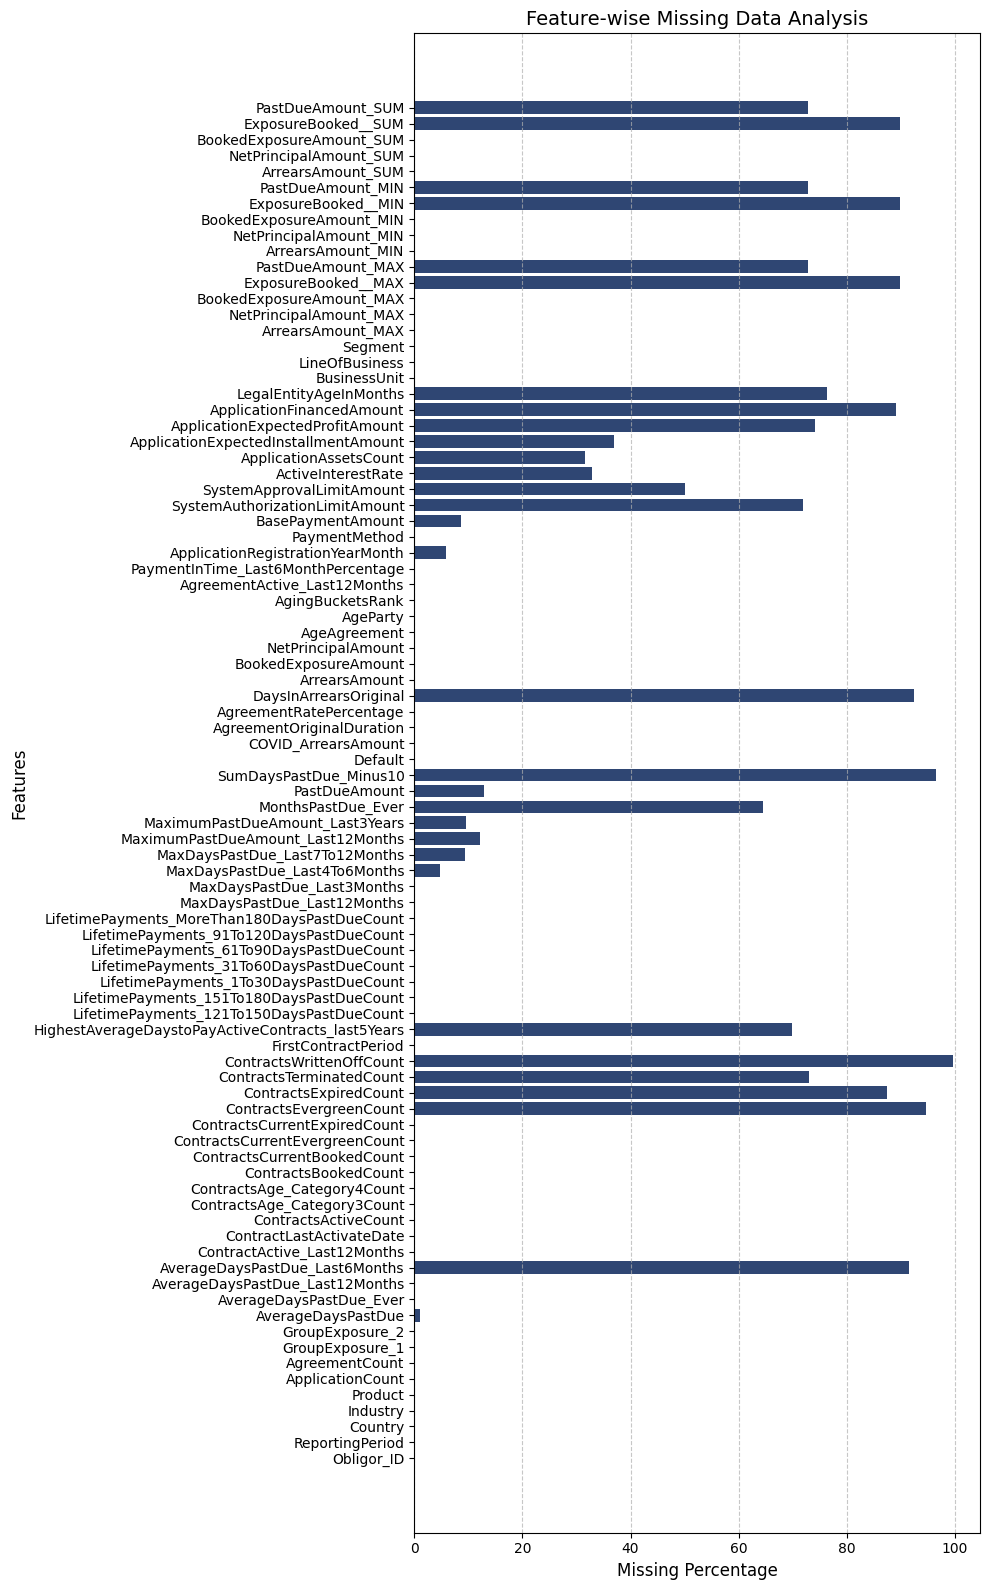

In [0]:
# Plotting missing percentage as a horizontal bar plot
plt.figure(figsize=(10, 16))
plt.barh(missing_percentage.index, missing_percentage.values, color='#2F4673')
plt.title('Feature-wise Missing Data Analysis', fontsize=14)
plt.xlabel('Missing Percentage', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('EDA_missing_percentage.png', dpi=300, bbox_inches='tight')
plt.show()

In [0]:
# 2. unique counts

unique_counts = original_df.nunique()
unique_counts[unique_counts == 1]

COVID_ArrearsAmount    1
PaymentMethod          1
dtype: int64

In [0]:
# Remove features with constant values
original_df = original_df.loc[:, original_df.nunique() > 1]

original_df.shape

(772766, 65)

In [0]:
# 3. Change data type

# Convert features to datetime format
original_df['ReportingPeriod'] = pd.to_datetime(original_df['ReportingPeriod'], format='%Y%m')
original_df['ContractLastActivateDate'] = pd.to_datetime(original_df['ContractLastActivateDate'], format='%Y%m')
original_df['FirstContractPeriod'] = pd.to_datetime(original_df['FirstContractPeriod'], format='%Y%m')
original_df['ApplicationRegistrationYearMonth'] = pd.to_datetime(original_df['ApplicationRegistrationYearMonth'], format='%Y%m')

# Change features to categorical
original_df['Country'] = original_df['Country'].astype('category')
original_df['Industry'] = original_df['Industry'].astype(str)
original_df['Industry'] = original_df['Industry'].astype('category')
original_df['Product'] = original_df['Product'].astype('category')
original_df['BusinessUnit'] = original_df['BusinessUnit'].astype('category')
original_df['LineOfBusiness'] = original_df['LineOfBusiness'].astype('category')
original_df['Segment'] = original_df['Segment'].astype(str)
original_df['Segment'] = original_df['Segment'].astype('category')

In [0]:
target_column = 'Default'

In [0]:
original_df.dtypes

Obligor_ID                                              object
ReportingPeriod                                 datetime64[ns]
Country                                               category
Industry                                              category
Product                                               category
ApplicationCount                                         int64
AgreementCount                                           int64
GroupExposure_1                                        float64
GroupExposure_2                                        float64
AverageDaysPastDue                                     float64
AverageDaysPastDue_Ever                                float64
AverageDaysPastDue_Last12Months                        float64
ContractActive_Last12Months                              int64
ContractLastActivateDate                        datetime64[ns]
ContractsActiveCount                                     int64
ContractsAge_Category3Count                            

In [0]:
def split_features_by_type(X):

    categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()
    numeric_features = X.select_dtypes(include=['int32', 'float64', 'int64']).columns.tolist()
    
    return categorical_features, numeric_features

In [0]:
X = original_df.drop(columns=[target_column])

In [0]:
categorical_features, numeric_features = split_features_by_type(X)

In [0]:
categorical_features

['Obligor_ID',
 'Country',
 'Industry',
 'Product',
 'BusinessUnit',
 'LineOfBusiness',
 'Segment']

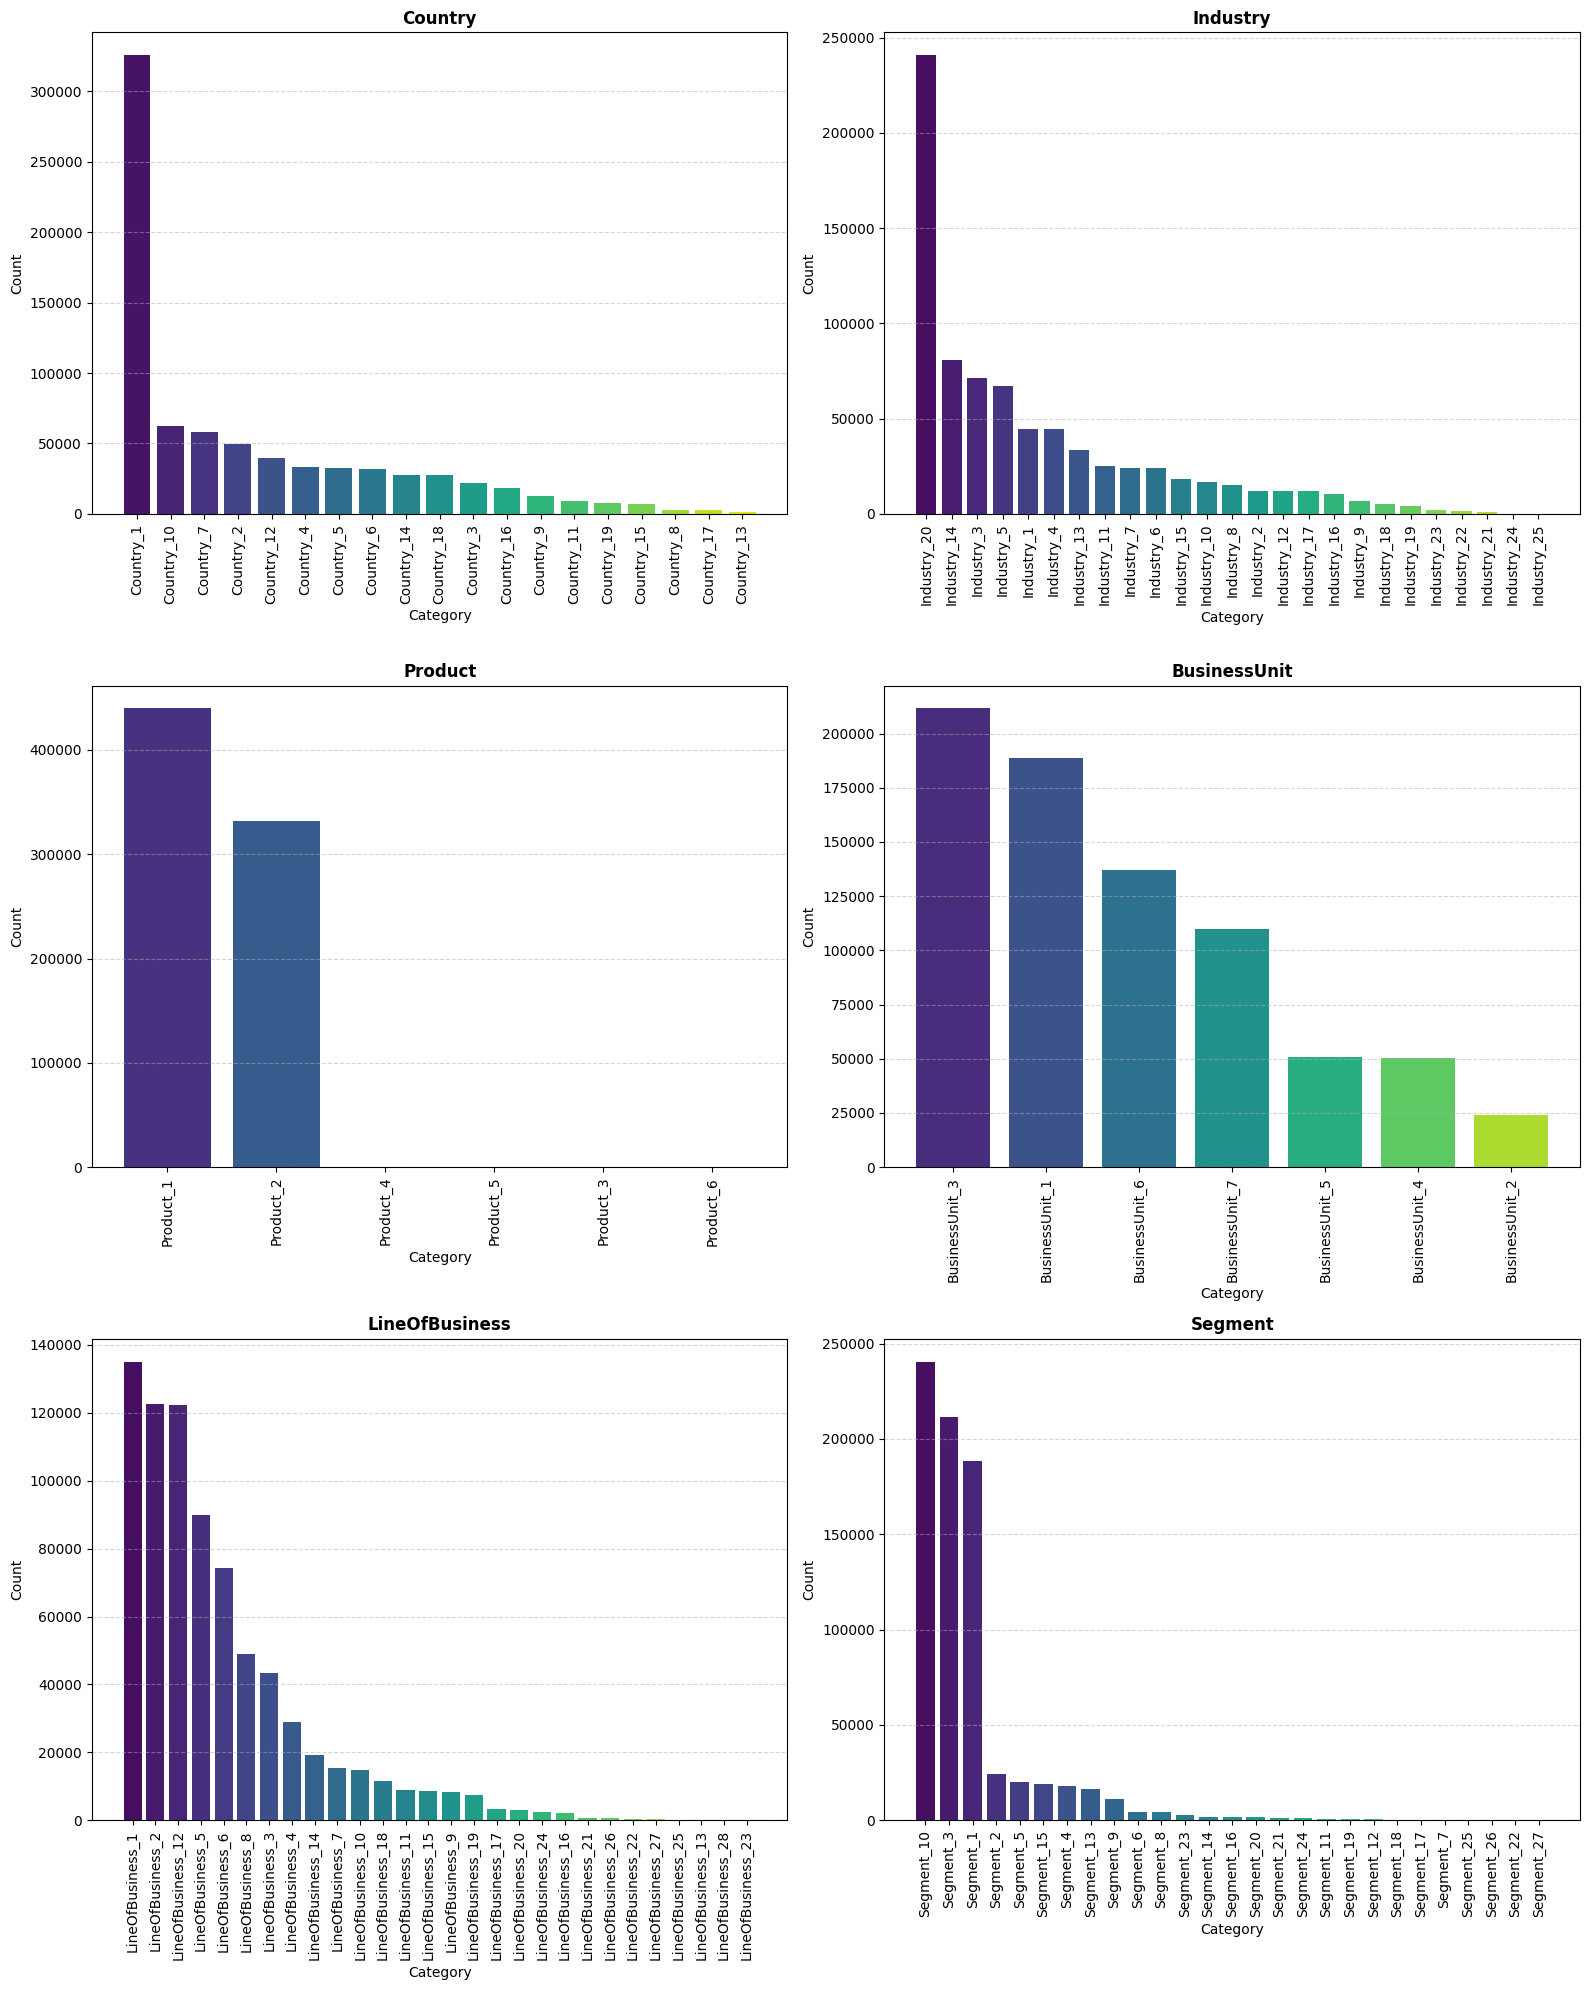

In [0]:
# 4. Distribution of categorical features

# Create a colormap from Viridis
colormap = sns.color_palette("viridis", as_cmap=True)

# Filter out 'Obligor_ID'
filtered_features = [feature for feature in categorical_features if feature != 'Obligor_ID']

# Create a 2x4 grid for the plots
fig, axes = plt.subplots(3, 2, figsize=(16, 20))
axes = axes.ravel()  # Flatten the axes array for easy iteration

# Loop through each feature and its corresponding axis
for i, feature in enumerate(filtered_features):
    ax = axes[i]
    
    # Get the counts for each category
    counts = original_df[feature].value_counts()
    
    # Generate bar plot
    bars = ax.bar(counts.index, counts.values, color=sns.color_palette("viridis", len(counts)))
    
    # Set titles and labels
    ax.set_title(f'{feature}', fontsize=12, weight='bold')
    ax.set_xlabel('Category', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.tick_params(axis='x', rotation=90)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()
plt.savefig('distribution_categorical_features.png', dpi=300, bbox_inches='tight')
plt.show()

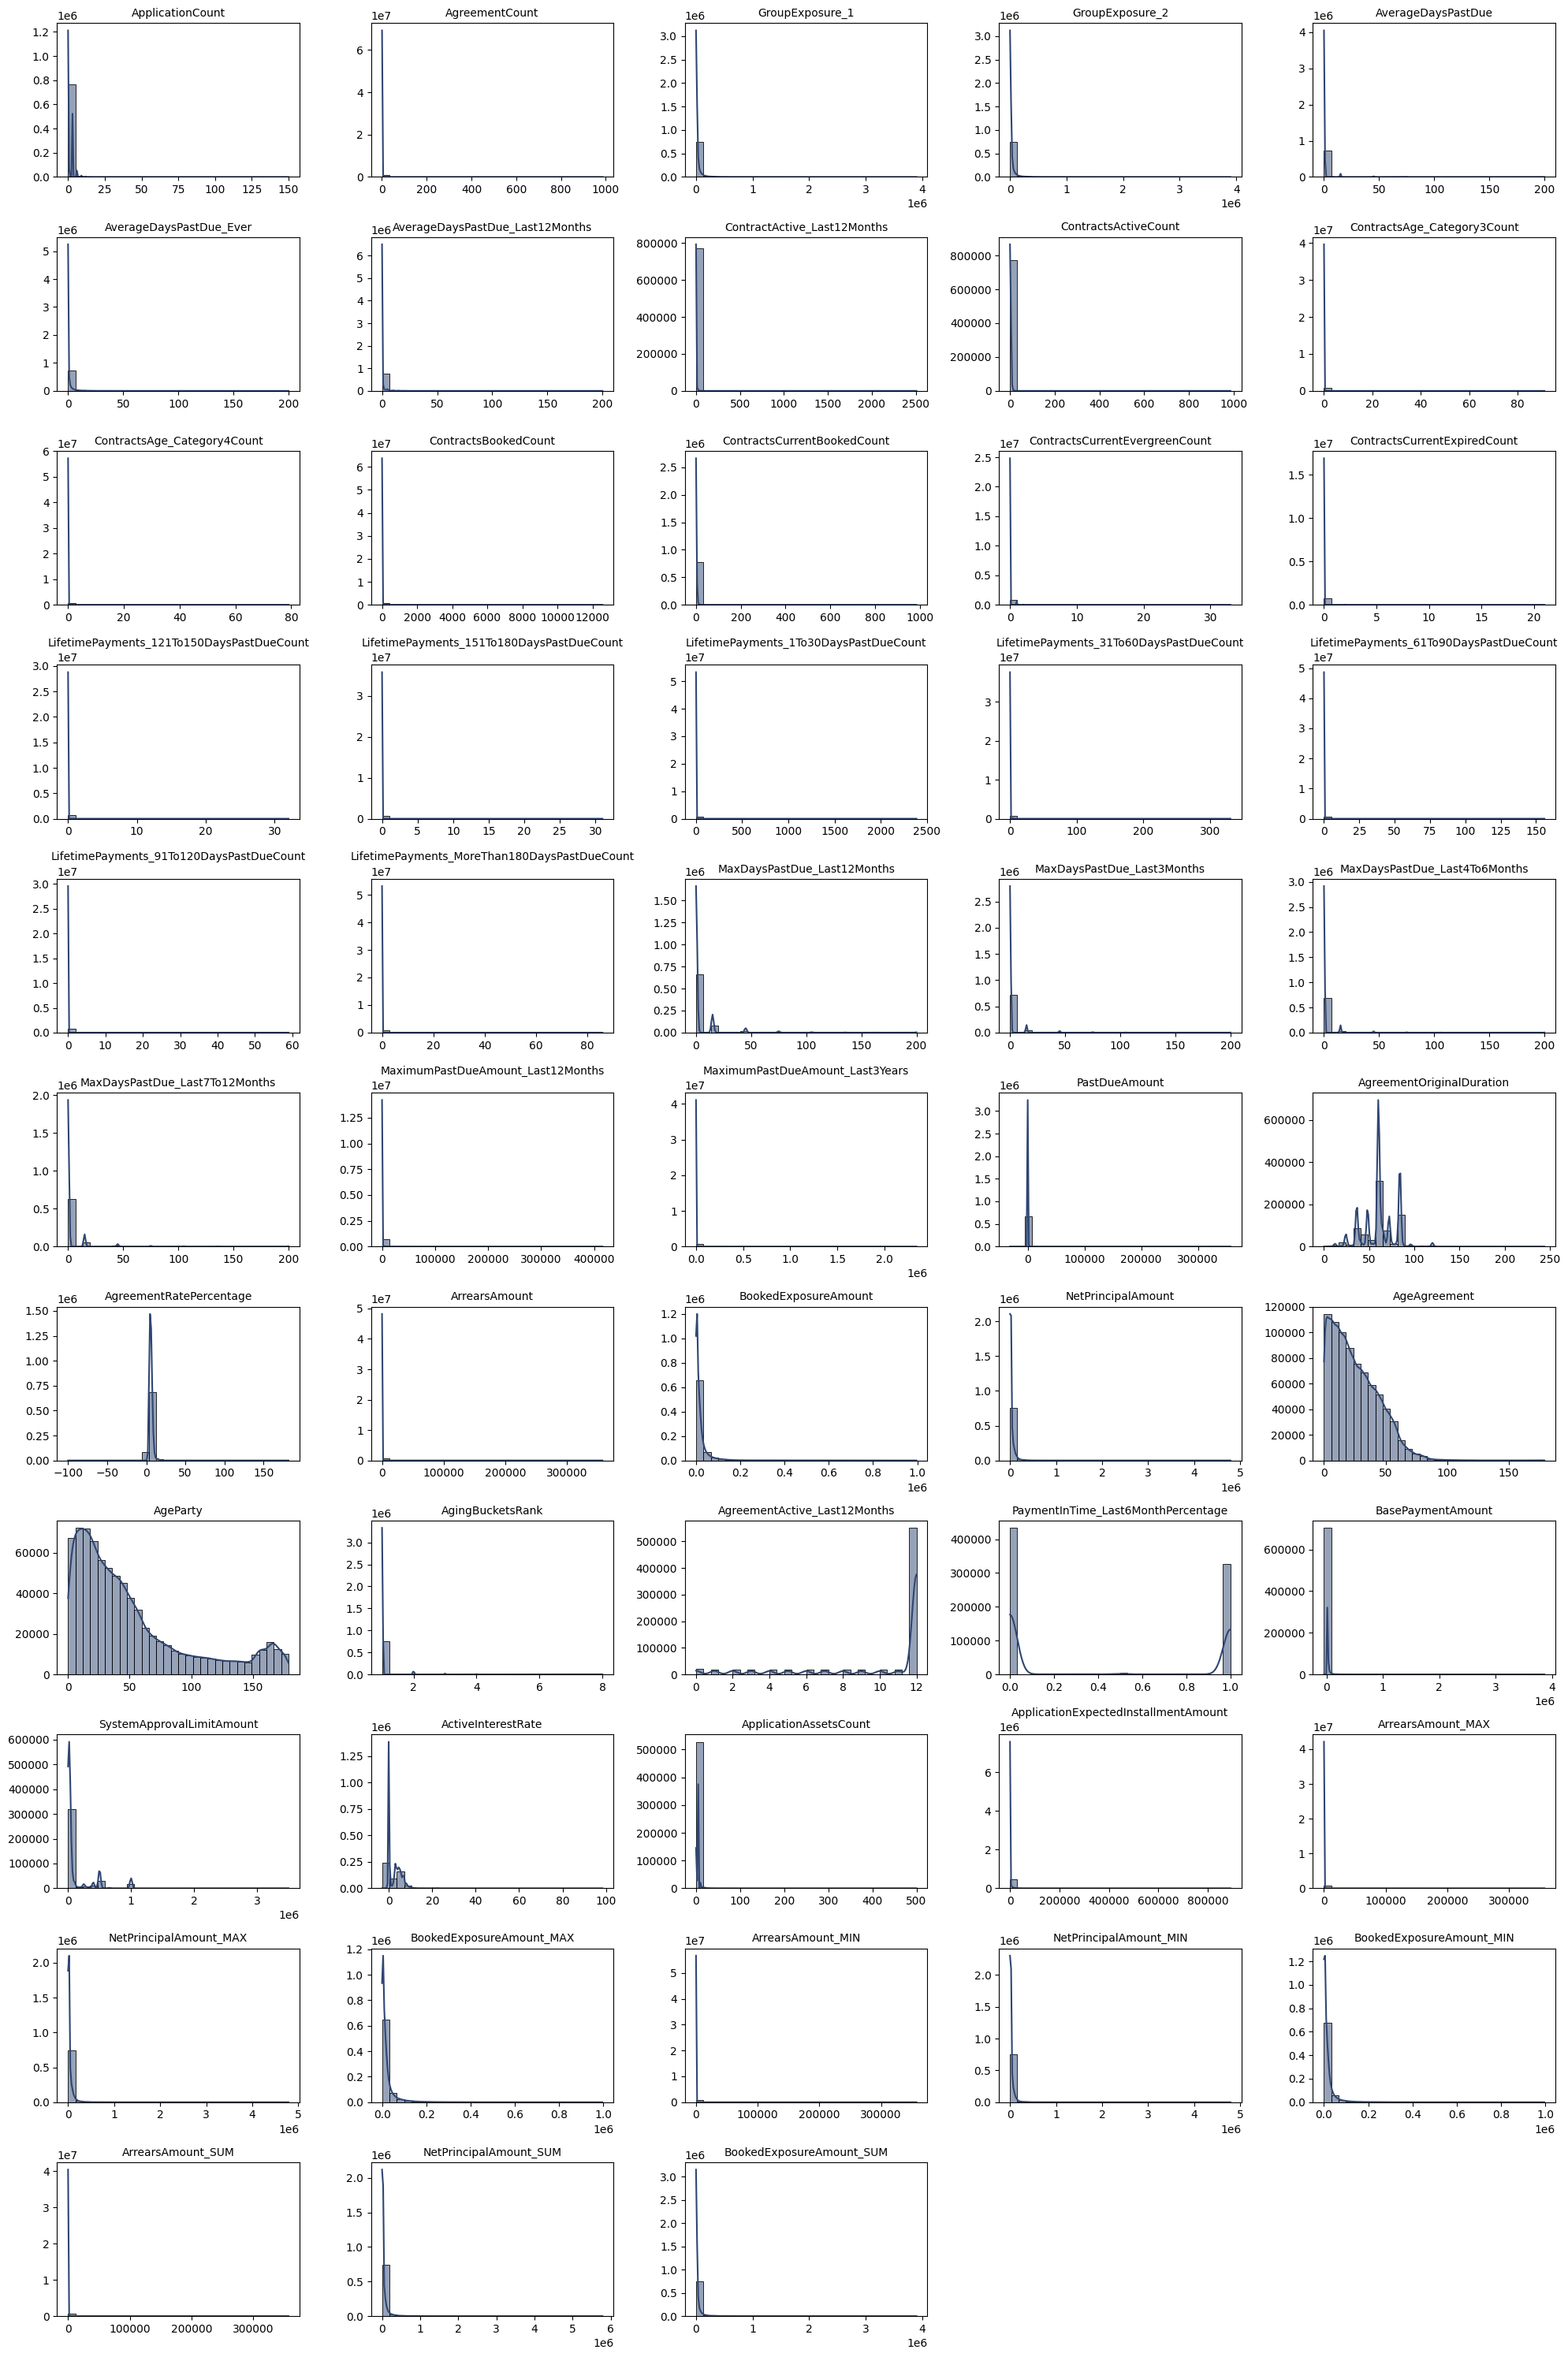

In [0]:
# 5. Distribution of Numeric Features

# Number of rows and columns for the grid
n_rows = 11
n_cols = 5

# Create a figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))
axes = axes.ravel()

# Loop through numeric features and plot distributions
for i, feature in enumerate(numeric_features):
    ax = axes[i]
    sns.histplot(original_df[feature].dropna(), ax=ax, kde=True, color="#2F4673", bins=30)
    ax.set_title(feature, fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(False)

# Hide any unused subplots
for j in range(len(numeric_features), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.savefig('distribution_numeric_features.png', dpi=300, bbox_inches='tight')
plt.show()

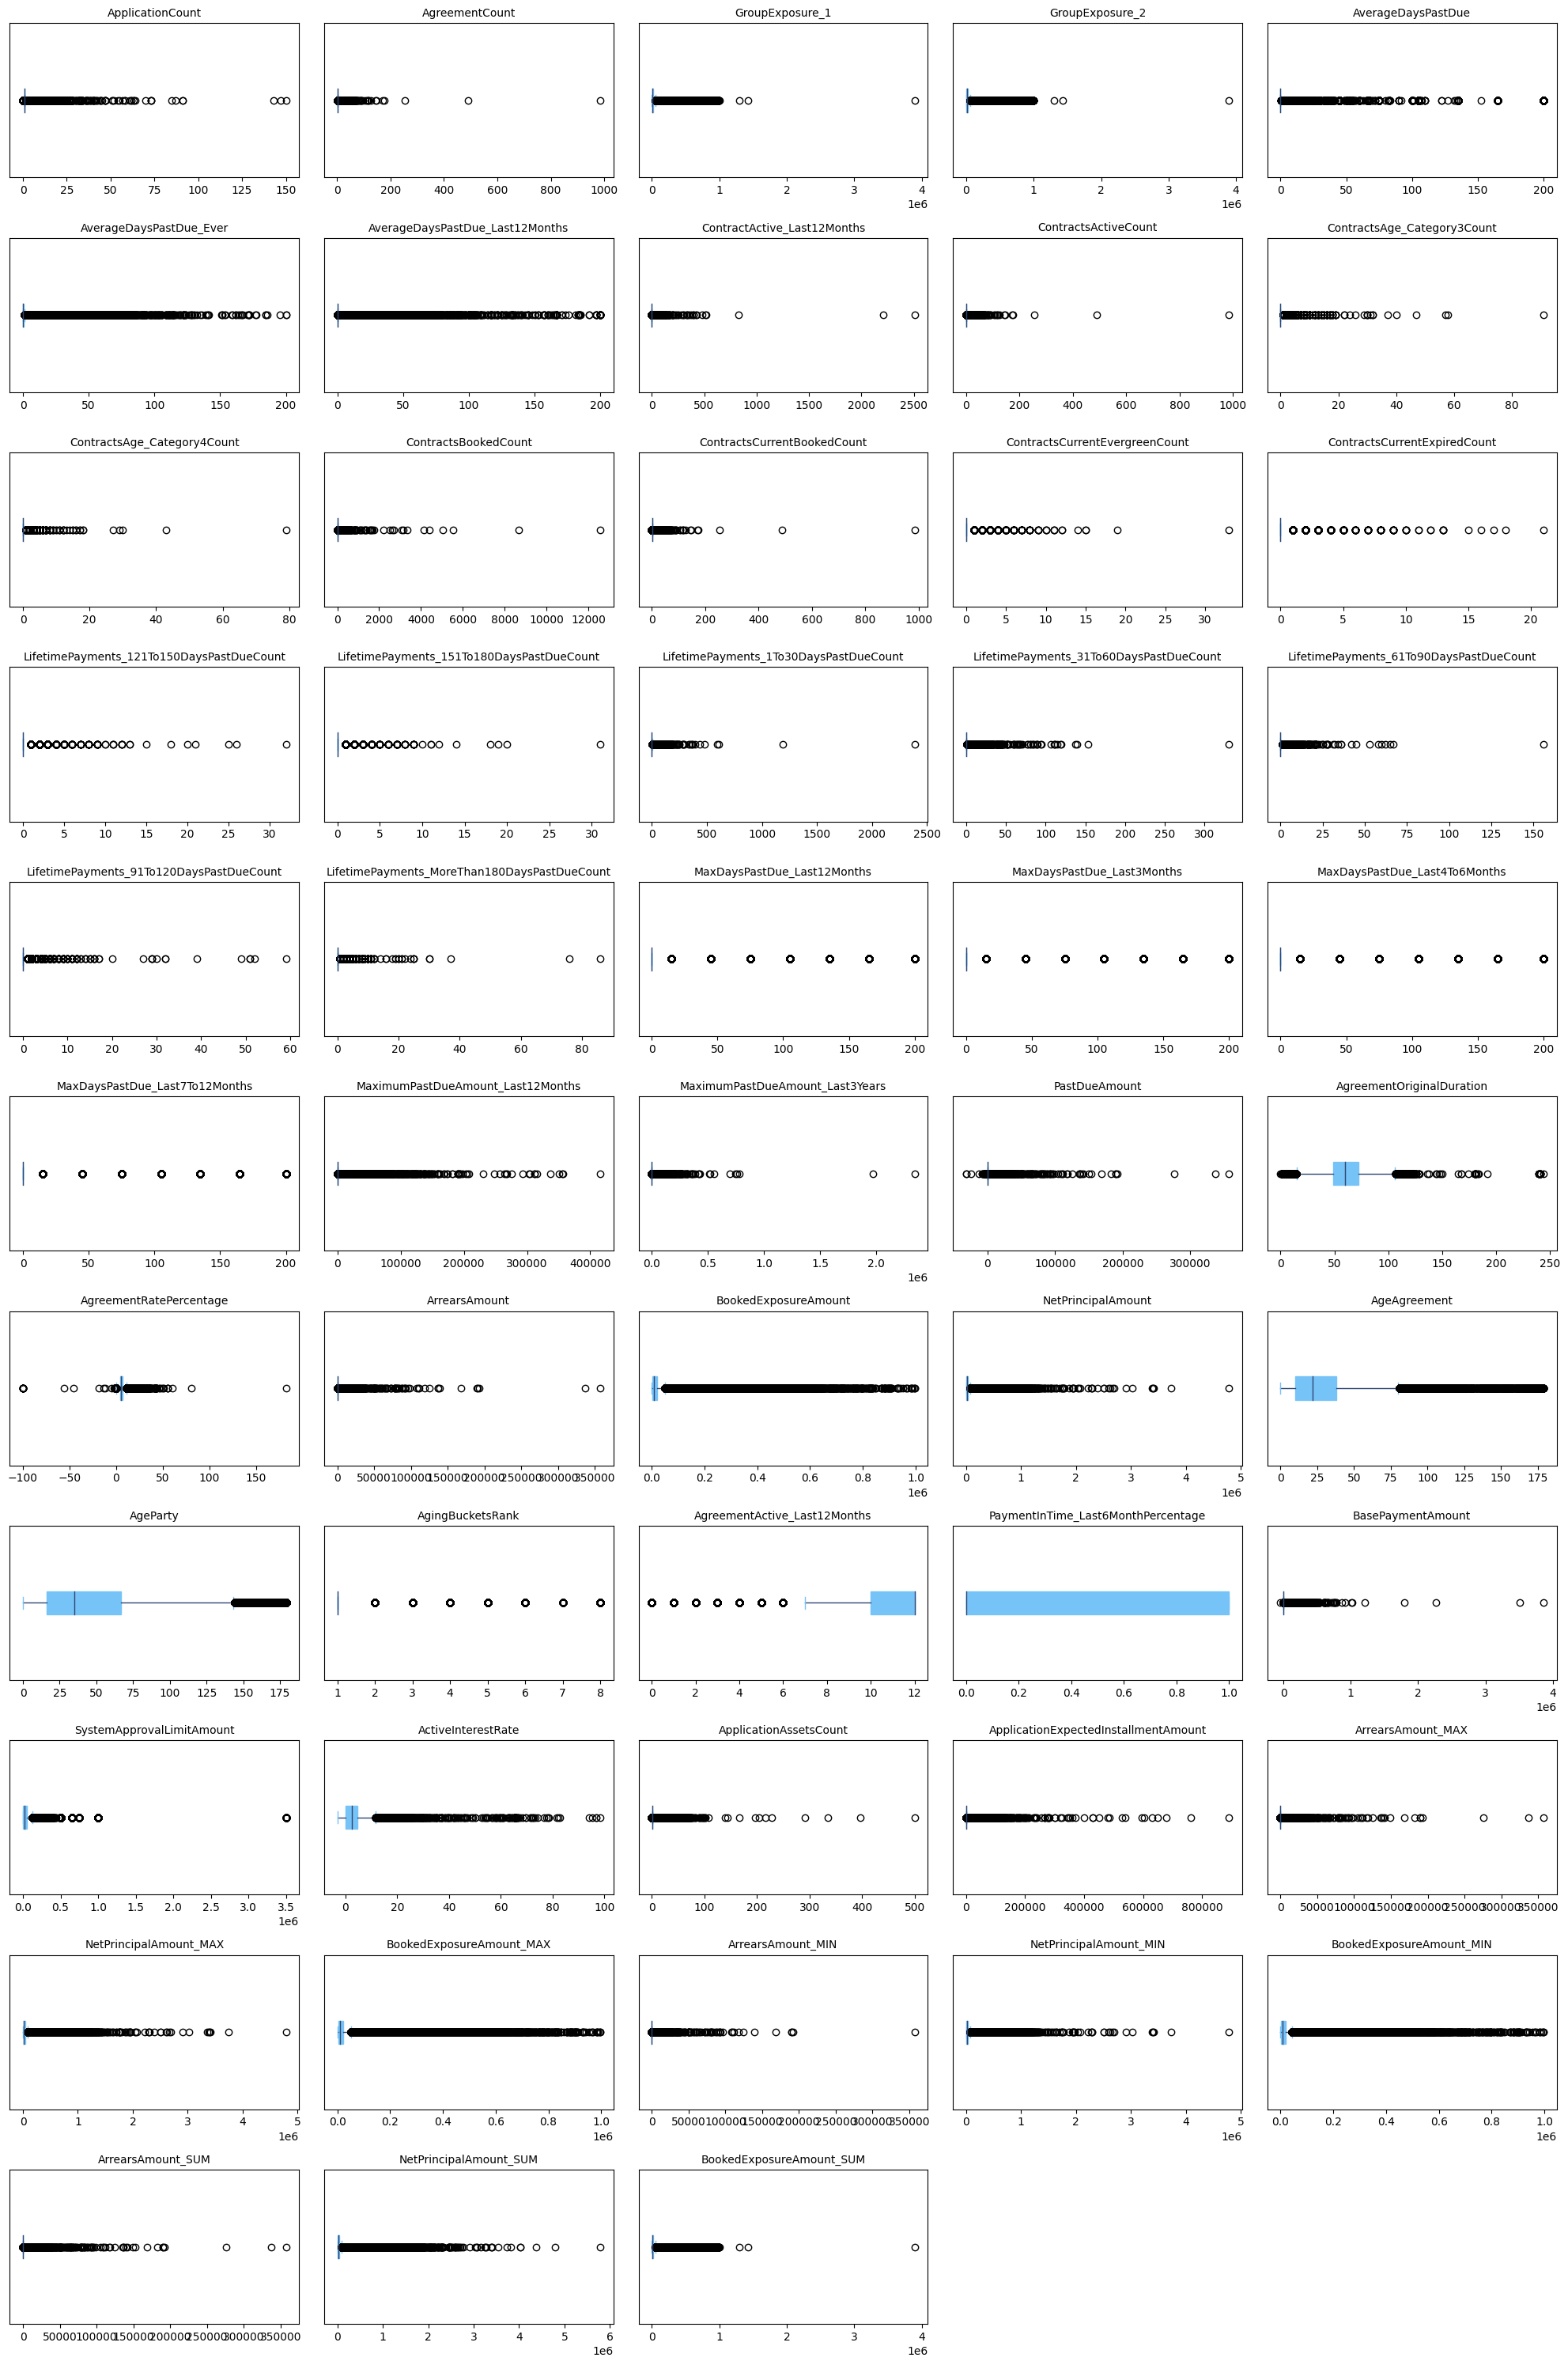

In [0]:
# 6. Outliers in numeric features (box plot)
# Number of rows and columns for the grid
n_rows = 11
n_cols = 5

# Create a figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))
axes = axes.ravel()

# Loop through numeric features and plot box plots
for i, feature in enumerate(numeric_features):
    ax = axes[i]
    ax.boxplot(original_df[feature].dropna(), vert=False, patch_artist=True, 
               boxprops=dict(facecolor="#76C3F8", color="#76C3F8"),
               whiskerprops=dict(color="#2F4673"),
               capprops=dict(color="#76C3F8"),
               medianprops=dict(color="#2F4673"))
    ax.set_title(feature, fontsize=10)
    ax.set_xlabel('')
    ax.set_yticks([])

# Hide any unused subplots
for j in range(len(numeric_features), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.savefig('boxplot_numeric_features.png', dpi=300, bbox_inches='tight')
plt.show()

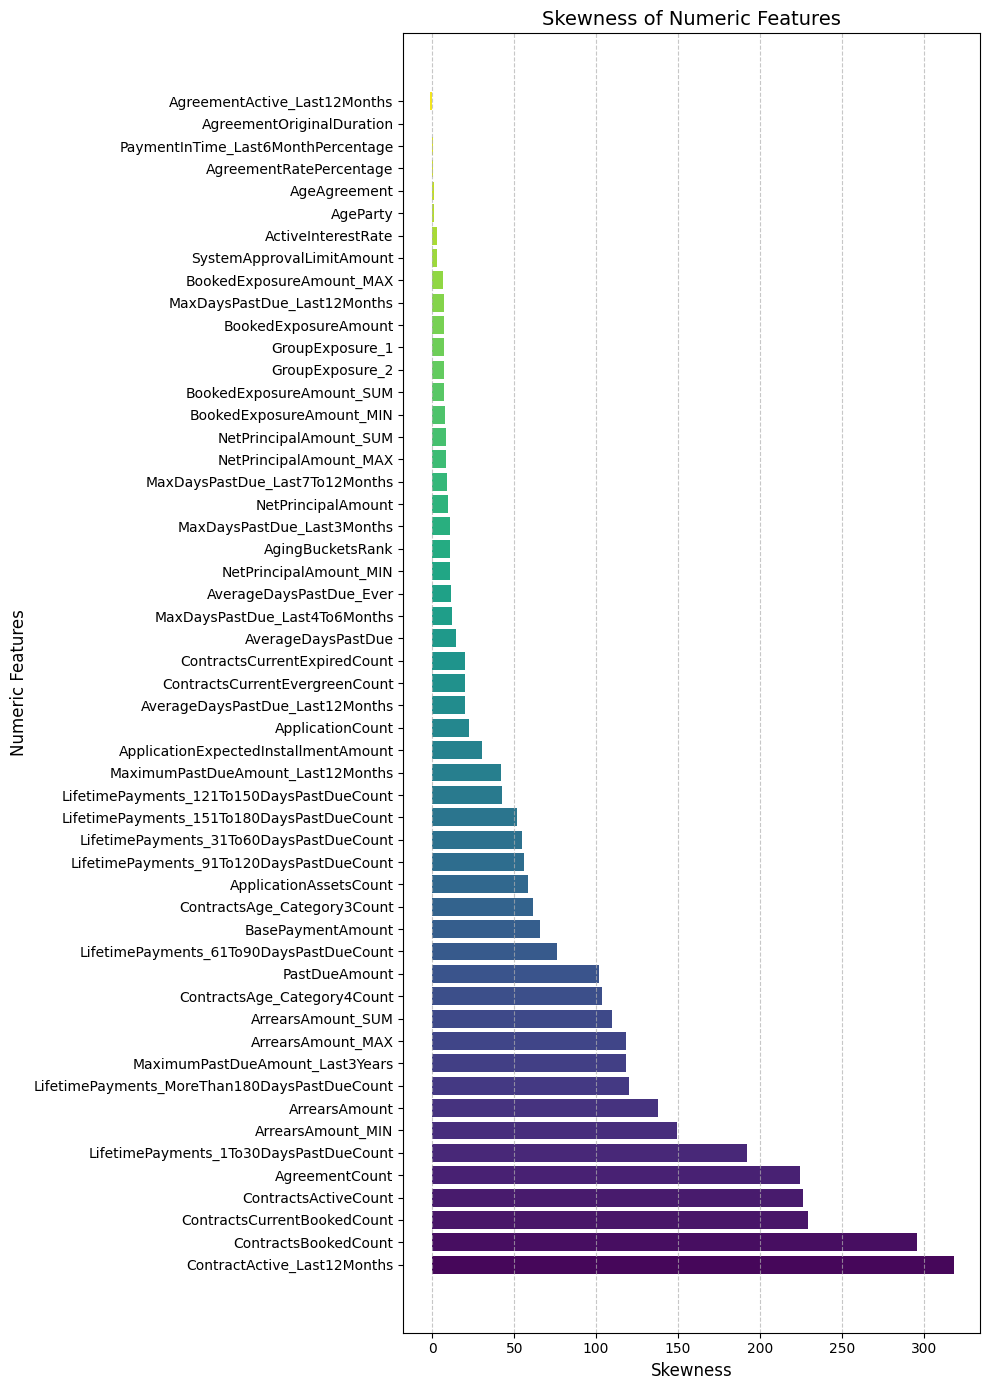

In [0]:
# 7. Skewness of numeric features

skewness = original_df[numeric_features].skew()
skewness = skewness.sort_values(ascending=False)

viridis_colors = sns.color_palette("viridis", len(skewness))

plt.figure(figsize=(10, 14))
plt.barh(skewness.index, skewness.values, color=viridis_colors)
plt.title('Skewness of Numeric Features', fontsize=14)
plt.xlabel('Skewness', fontsize=12)
plt.ylabel('Numeric Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('skewness_numeric_features.png', dpi=300, bbox_inches='tight')
plt.show()

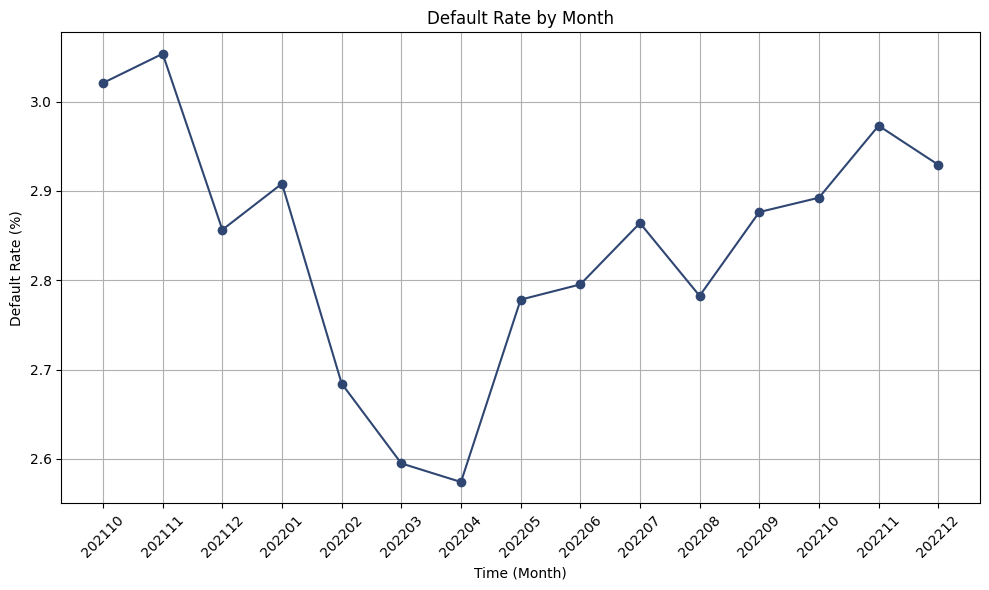

In [0]:
# 8. Target feature distribution by month

# Group the dataset by ReportingPeriod and calculate default rate
default_rate_by_month = original_df.groupby('ReportingPeriod').agg(
    total=('Default', 'size'),
    defaults=('Default', 'sum')
).reset_index()

# Convert ReportingPeriod to YYYYmm format
default_rate_by_month['ReportingPeriod'] = pd.to_datetime(default_rate_by_month['ReportingPeriod'], format='%Y%m%d').dt.strftime('%Y%m')

# Calculate the default rate
default_rate_by_month['default_rate'] = (default_rate_by_month['defaults'] / default_rate_by_month['total']) * 100

# Sort by ReportingPeriod to ensure it's in time order
default_rate_by_month = default_rate_by_month.sort_values('ReportingPeriod')

# Plot the default rate by month
plt.figure(figsize=(10, 6))
plt.plot(default_rate_by_month['ReportingPeriod'], default_rate_by_month['default_rate'], marker='o', color='#2F4673')
plt.xticks(default_rate_by_month['ReportingPeriod'], rotation=45)
plt.xlabel('Time (Month)')
plt.ylabel('Default Rate (%)')
plt.title('Default Rate by Month')
plt.grid(True)
plt.tight_layout()
plt.savefig('default_rate_by_month.png', dpi=300, bbox_inches='tight')
plt.show()

#### 1.2 Data Preprocessing & Feature engineering

In [0]:
# 1. Abnormal values (1): replace negative values with nan

original_df[numeric_features] = original_df[numeric_features].applymap(lambda x: np.nan if x < 0 else x)

In [0]:
# 2. Abnormal values (2): replace 0 values with nan
# Arrears can be zero; Exposure, NetPrincipal, Rate cannot be zero

keywords = ['exposure', 'netprincipal', 'rate', 'AgreementOriginalDuration', 'PaymentInTime_Last6MonthPercentage', 'BasePaymentAmount', 'SystemApprovalLimitAmount', 'ApplicationExpectedInstallmentAmount']
no_zero_features = [col for col in original_df.columns if any(keyword.lower() in col.lower() for keyword in keywords)]
original_df[no_zero_features] = original_df[no_zero_features].replace(0, np.nan)

In [0]:
# 3. Create three ratios

for_ratio_features = ['ArrearsAmount_SUM', 'BookedExposureAmount_SUM', 'NetPrincipalAmount_SUM']

In [0]:
# Calculate 0.5th and 99.5th percentiles for each feature
lower_bound = original_df[for_ratio_features].quantile(0.005)
upper_bound = original_df[for_ratio_features].quantile(0.995)

In [0]:
# Clip the values using these bounds
for col in for_ratio_features:
    original_df[col] = original_df[col].clip(lower=lower_bound[col], upper=upper_bound[col])

In [0]:
# Create new ratio columns
original_df['Arrears_to_Exposure'] = original_df['ArrearsAmount_SUM'] / original_df['BookedExposureAmount_SUM']
original_df['Exposure_to_NetPrincipal'] = original_df['BookedExposureAmount_SUM'] / original_df['NetPrincipalAmount_SUM']
original_df['Arrears_to_NetPrincipal'] = original_df['ArrearsAmount_SUM'] / original_df['NetPrincipalAmount_SUM']

In [0]:
ratio_columns = ['Arrears_to_Exposure', 'Exposure_to_NetPrincipal', 'Arrears_to_NetPrincipal']

In [0]:
original_df[ratio_columns].describe()

Arrears_to_Exposure  Exposure_to_NetPrincipal  Arrears_to_NetPrincipal
count        752533.000000             751909.000000            767841.000000
mean              0.002732                  0.571371                 0.000882
std               0.102087                  0.272653                 0.008750
min               0.000000                  0.000050                 0.000000
25%               0.000000                  0.355617                 0.000000
50%               0.000000                  0.599158                 0.000000
75%               0.000000                  0.799676                 0.000000
max              44.585989                  9.638252                 2.129650

In [0]:
original_df[ratio_columns].corr()

Arrears_to_Exposure  ...  Arrears_to_NetPrincipal
Arrears_to_Exposure                  1.000000  ...                 0.162199
Exposure_to_NetPrincipal            -0.022126  ...                 0.042674
Arrears_to_NetPrincipal              0.162199  ...                 1.000000

[3 rows x 3 columns]

In [0]:
# 4. Extract Year and Month from datetime features and then remove these features

datetime_features = ['ReportingPeriod', 'ContractLastActivateDate', 'FirstContractPeriod', 'ApplicationRegistrationYearMonth']

# Extract Year and Month for each datetime feature
for feature in datetime_features:
    original_df[f'{feature}_year'] = original_df[feature].dt.year
    original_df[f'{feature}_month'] = original_df[feature].dt.month

# Remove the original datetime features
original_df.drop(columns=['ContractLastActivateDate', 'FirstContractPeriod', 'ApplicationRegistrationYearMonth'], inplace=True)

In [0]:
pd.set_option('display.max_rows', None)
original_df.dtypes

Obligor_ID                                              object
ReportingPeriod                                 datetime64[ns]
Country                                               category
Industry                                              category
Product                                               category
ApplicationCount                                         int64
AgreementCount                                           int64
GroupExposure_1                                        float64
GroupExposure_2                                        float64
AverageDaysPastDue                                     float64
AverageDaysPastDue_Ever                                float64
AverageDaysPastDue_Last12Months                        float64
ContractActive_Last12Months                              int64
ContractsActiveCount                                     int64
ContractsAge_Category3Count                              int64
ContractsAge_Category4Count                            

In [0]:
original_df.shape

(772766, 73)

## 2. Split Train and Test

In [0]:
original_df.set_index('ReportingPeriod', inplace=True)

In [0]:
train_df = original_df[original_df.index <= pd.to_datetime('2022-09-01')]
test_df = original_df[original_df.index >= pd.to_datetime('2022-10-01')]

print(train_df.shape)
print(test_df.shape)

print('Train size:', train_df.shape[0] / len(original_df) * 100)
print('Test size:', test_df.shape[0] / len(original_df) * 100)

(617804, 72)
(154962, 72)
Train size: 79.94709912185579
Test size: 20.052900878144225


In [0]:
train_df = train_df.drop(columns=['Obligor_ID'])
test_df = test_df.drop(columns=['Obligor_ID'])

In [0]:
print(train_df.shape)
print(test_df.shape)

print('Train size:', train_df.shape[0] / len(original_df) * 100)
print('Test size:', test_df.shape[0] / len(original_df) * 100)

(617804, 71)
(154962, 71)
Train size: 79.94709912185579
Test size: 20.052900878144225


In [0]:
time_and_censoring_train = time_and_censoring.iloc[:train_df.shape[0],:]
time_and_censoring_test = time_and_censoring.iloc[train_df.shape[0]:,:]

In [0]:
time_and_censoring_train.shape

(617804, 2)

In [0]:
time_and_censoring_test.shape

(154962, 2)

## 3. Rolling window cross-validation split

In [0]:
X = train_df.drop(columns=[target_column])
y = train_df[target_column]

In [0]:
# Create the 'groups' based on time periods (e.g., ReportingPeriod_AGR)
group, unique = pd.factorize(train_df.index.values)
groups = group + 1

In [0]:
group

array([ 0,  0,  0, ..., 11, 11, 11])

In [0]:
groups

array([ 1,  1,  1, ..., 12, 12, 12])

In [0]:
unique

array(['2021-10-01T00:00:00.000000000', '2021-11-01T00:00:00.000000000',
       '2021-12-01T00:00:00.000000000', '2022-01-01T00:00:00.000000000',
       '2022-02-01T00:00:00.000000000', '2022-03-01T00:00:00.000000000',
       '2022-04-01T00:00:00.000000000', '2022-05-01T00:00:00.000000000',
       '2022-06-01T00:00:00.000000000', '2022-07-01T00:00:00.000000000',
       '2022-08-01T00:00:00.000000000', '2022-09-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [0]:
def rolling_window_split_by_group(df, window_size=6, validation_size=2):
    """
    Function to split data based on rolling window logic:
    - Use 'window_size' months as training
    - Use 'validation_size' month as validation
    """
    folds = []
    # Get unique months from the index (ReportingPeriod_AGR)
    unique_months = df.index.to_period('M').unique()
    
    # Iterate over the range of the rolling window
    for i in range(len(unique_months) - window_size - validation_size + 1):
        # Define training and validation periods
        train_periods = unique_months[i:i+window_size]  # e.g., 202110 + 202111 for first fold
        val_period = unique_months[i+window_size:i+window_size+validation_size]  # e.g., 202112 for first fold
        
        # Get training and validation sets based on the periods
        train_mask = df.index.to_period('M').isin(train_periods)
        val_mask = df.index.to_period('M').isin(val_period)
        
        X_train = df[train_mask].drop(columns=[target_column])
        X_val = df[val_mask].drop(columns=[target_column])
        y_train = df[train_mask][target_column]
        y_val = df[val_mask][target_column]
        
        folds.append((X_train, X_val, y_train, y_val))
    
    return folds

In [0]:
folds = rolling_window_split_by_group(train_df, window_size=6, validation_size=2)

In [0]:
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    print(f"Fold {i + 1}")
    
    # Get the unique dates (ReportingPeriod_AGR) from the training and validation sets
    train_dates = X_train.index.to_period('M').unique()
    val_dates = X_val.index.to_period('M').unique()
    
    print(f"Training set unique dates: {train_dates}")
    print(f"Number of unique training dates: {len(train_dates)}")
    
    print(f"Validation set unique dates: {val_dates}")
    print(f"Number of unique validation dates: {len(val_dates)}")
    
    print("\n")


Fold 1
Training set unique dates: PeriodIndex(['2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03'], dtype='period[M]', name='ReportingPeriod')
Number of unique training dates: 6
Validation set unique dates: PeriodIndex(['2022-04', '2022-05'], dtype='period[M]', name='ReportingPeriod')
Number of unique validation dates: 2


Fold 2
Training set unique dates: PeriodIndex(['2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04'], dtype='period[M]', name='ReportingPeriod')
Number of unique training dates: 6
Validation set unique dates: PeriodIndex(['2022-05', '2022-06'], dtype='period[M]', name='ReportingPeriod')
Number of unique validation dates: 2


Fold 3
Training set unique dates: PeriodIndex(['2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05'], dtype='period[M]', name='ReportingPeriod')
Number of unique training dates: 6
Validation set unique dates: PeriodIndex(['2022-06', '2022-07'], dtype='period[M]', name='ReportingPeriod')
Number of unique valid

## 4. Pipeline

In [0]:
categorical_features, numeric_features = split_features_by_type(X)

In [0]:
len(categorical_features) + len(numeric_features)

70

In [0]:
# Pipeline for LR

numeric_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('frequency_encoder', CountEncoder(normalize=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_preprocessor, numeric_features),
        ('cat', categorical_preprocessor, categorical_features)
        ]
)

sampler = RandomUnderSampler(random_state=42)

## 5. All features (70)

#### 5.1 LR

In [0]:
lr = LogisticRegression(random_state=42)

lr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('sampler', sampler),
    ('classifier', lr)
])

lr_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ApplicationCount',
                                                   'AgreementCount',
                                                   'GroupExposure_1',
                                                   'GroupExposure_2',
                                                   'AverageDaysPastDue',
                                                   'AverageDaysPastDue_Ever',
                                                   'AverageDaysPastDue_Last12Months',
                                                   'ContractActive_Last12Months',
                                                   'Con...
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('frequency_encoder',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                normalize=True))]),
                                                  ['Country', 'Industry',
                                                   'Product', 'BusinessUnit',
                                                   'LineOfBusiness',
                                                   'Segment'])])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('classifier', LogisticRegression(random_state=42))])

In [0]:
# Initialize list to hold metrics for each fold
results = []

# Loop through each fold
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    
    # Train the logistic regression pipeline
    lr_pipe.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = lr_pipe.predict(X_val)
    y_pred_prob = lr_pipe.predict_proba(X_val)[:, 1]
    
    # Evaluate model performance
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_roc = roc_auc_score(y_val, y_pred_prob)
    
    # Calculate precision-recall curve and area under PR curve (AUC-PR)
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_pred_prob)
    auc_pr = auc(recall_curve, precision_curve)
    
    # Store results for each fold
    results.append({
        'fold': i+1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': auc_roc,
        'auc_pr': auc_pr
    })
    
    # Print confusion matrix and classification report for each fold
    cm = confusion_matrix(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    
    print(f"\nFold {i+1} Results:")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)

# Convert results into a DataFrame for better display
results_df = pd.DataFrame(results)

# Add row for the average of each metric
results_df.loc['mean'] = results_df.mean()

# Display the table with fold-wise metrics and the final mean
print("\nCross-Validation Results (Fold-wise and Mean):")
results_df


Fold 1 Results:
Confusion Matrix:
 [[89632 10296]
 [ 1012  1736]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     99928
           1       0.14      0.63      0.23      2748

    accuracy                           0.89    102676
   macro avg       0.57      0.76      0.59    102676
weighted avg       0.97      0.89      0.92    102676


Fold 2 Results:
Confusion Matrix:
 [[89312 10769]
 [ 1077  1792]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.89      0.94    100081
           1       0.14      0.62      0.23      2869

    accuracy                           0.88    102950
   macro avg       0.57      0.76      0.59    102950
weighted avg       0.96      0.88      0.92    102950


Fold 3 Results:
Confusion Matrix:
 [[86261 13872]
 [  987  1929]]
Classification Report:
               precision    recall  f1-score   support

           0      

fold  accuracy  precision    recall  f1_score   roc_auc    auc_pr
0      1.0  0.889867   0.144282  0.631732  0.234912  0.837839  0.209249
1      2.0  0.884934   0.142664  0.624608  0.232275  0.829928  0.206814
2      3.0  0.855806   0.122081  0.661523  0.206123  0.835579  0.213485
3      4.0  0.856955   0.124713  0.675638  0.210560  0.835048  0.225035
4      5.0  0.831265   0.107841  0.682446  0.186250  0.828450  0.224812
mean   3.0  0.863766   0.128316  0.655189  0.214024  0.833369  0.215879

In [0]:
results_df.to_csv("training_performance_70_lr.csv", index=False)

#### 5.2 RF

In [0]:
# Pipeline for tree-based models

numeric_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('frequency_encoder', CountEncoder(normalize=True))
])
    
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_preprocessor, numeric_features),
        ('cat', categorical_preprocessor, categorical_features)
    ]
)

In [0]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    
# Create a pipeline with preprocessing, sampling, and random forest classifier
rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', rf)
])

rf_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['ApplicationCount',
                                                   'AgreementCount',
                                                   'GroupExposure_1',
                                                   'GroupExposure_2',
                                                   'AverageDaysPastDue',
                                                   'AverageDaysPastDue_Ever',
                                                   'AverageDaysPastDue_Last12Months',
                                                   'ContractActive_Last12Months',
                                                   'ContractsActiveCount',
                                                   'Contract...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('frequency_encoder',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                normalize=True))]),
                                                  ['Country', 'Industry',
                                                   'Product', 'BusinessUnit',
                                                   'LineOfBusiness',
                                                   'Segment'])])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

In [0]:
# Initialize list to hold metrics for each fold
results = []

# Loop through each fold
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    
    # Train the logistic regression pipeline
    rf_pipe.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = rf_pipe.predict(X_val)
    y_pred_prob = rf_pipe.predict_proba(X_val)[:, 1]
    
    # Evaluate model performance
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_roc = roc_auc_score(y_val, y_pred_prob)
    
    # Calculate precision-recall curve and area under PR curve (AUC-PR)
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_pred_prob)
    auc_pr = auc(recall_curve, precision_curve)
    
    # Store results for each fold
    results.append({
        'fold': i+1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': auc_roc,
        'auc_pr': auc_pr
    })
    
    # Print confusion matrix and classification report for each fold
    cm = confusion_matrix(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    
    print(f"\nFold {i+1} Results:")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)

# Convert results into a DataFrame for better display
results_df = pd.DataFrame(results)

# Add row for the average of each metric
results_df.loc['mean'] = results_df.mean()

# Display the table with fold-wise metrics and the final mean
print("\nCross-Validation Results (Fold-wise and Mean):")
results_df


Fold 1 Results:
Confusion Matrix:
 [[84685 15243]
 [  784  1964]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.91     99928
           1       0.11      0.71      0.20      2748

    accuracy                           0.84    102676
   macro avg       0.55      0.78      0.56    102676
weighted avg       0.97      0.84      0.89    102676


Fold 2 Results:
Confusion Matrix:
 [[84796 15285]
 [  881  1988]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.91    100081
           1       0.12      0.69      0.20      2869

    accuracy                           0.84    102950
   macro avg       0.55      0.77      0.56    102950
weighted avg       0.97      0.84      0.89    102950


Fold 3 Results:
Confusion Matrix:
 [[84015 16118]
 [  849  2067]]
Classification Report:
               precision    recall  f1-score   support

           0      

fold  accuracy  precision    recall  f1_score   roc_auc    auc_pr
0      1.0  0.843907   0.114140  0.714702  0.196843  0.855508  0.282312
1      2.0  0.842972   0.115093  0.692924  0.197398  0.847014  0.263785
2      3.0  0.835350   0.113665  0.708848  0.195915  0.848391  0.276655
3      4.0  0.827044   0.109229  0.716356  0.189554  0.851004  0.277724
4      5.0  0.822466   0.105785  0.707671  0.184057  0.842607  0.278741
mean   3.0  0.834348   0.111582  0.708100  0.192753  0.848905  0.275843

In [0]:
results_df.to_csv("training_performance_70_rf.csv", index=False)

#### 5.3 XGBoost

In [0]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
    
# Create a pipeline with preprocessing, sampling, and XGBoost classifier
xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', xgb)
])

xgb_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['ApplicationCount',
                                                   'AgreementCount',
                                                   'GroupExposure_1',
                                                   'GroupExposure_2',
                                                   'AverageDaysPastDue',
                                                   'AverageDaysPastDue_Ever',
                                                   'AverageDaysPastDue_Last12Months',
                                                   'ContractActive_Last12Months',
                                                   'ContractsActiveCount',
                                                   'Contract...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

In [0]:
# Initialize list to hold metrics for each fold
results = []

# Loop through each fold
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    
    # Train the logistic regression pipeline
    xgb_pipe.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = xgb_pipe.predict(X_val)
    y_pred_prob = xgb_pipe.predict_proba(X_val)[:, 1]
    
    # Evaluate model performance
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_roc = roc_auc_score(y_val, y_pred_prob)
    
    # Calculate precision-recall curve and area under PR curve (AUC-PR)
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_pred_prob)
    auc_pr = auc(recall_curve, precision_curve)
    
    # Store results for each fold
    results.append({
        'fold': i+1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': auc_roc,
        'auc_pr': auc_pr
    })
    
    # Print confusion matrix and classification report for each fold
    cm = confusion_matrix(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    
    print(f"\nFold {i+1} Results:")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)

# Convert results into a DataFrame for better display
import pandas as pd
results_df = pd.DataFrame(results)

# Add row for the average of each metric
results_df.loc['mean'] = results_df.mean()

# Display the table with fold-wise metrics and the final mean
print("\nCross-Validation Results (Fold-wise and Mean):")
results_df


Fold 1 Results:
Confusion Matrix:
 [[83179 16749]
 [  748  2000]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90     99928
           1       0.11      0.73      0.19      2748

    accuracy                           0.83    102676
   macro avg       0.55      0.78      0.55    102676
weighted avg       0.97      0.83      0.89    102676


Fold 2 Results:
Confusion Matrix:
 [[82912 17169]
 [  829  2040]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90    100081
           1       0.11      0.71      0.18      2869

    accuracy                           0.83    102950
   macro avg       0.55      0.77      0.54    102950
weighted avg       0.97      0.83      0.88    102950


Fold 3 Results:
Confusion Matrix:
 [[81003 19130]
 [  782  2134]]
Classification Report:
               precision    recall  f1-score   support

           0      

fold  accuracy  precision    recall  f1_score   roc_auc    auc_pr
0      1.0  0.829590   0.106672  0.727802  0.186072  0.858207  0.261250
1      2.0  0.825177   0.106200  0.711049  0.184799  0.844737  0.259954
2      3.0  0.806772   0.100357  0.731824  0.176510  0.849914  0.268167
3      4.0  0.797134   0.096597  0.740511  0.170901  0.849035  0.268281
4      5.0  0.792782   0.094091  0.732896  0.166772  0.841830  0.272384
mean   3.0  0.810291   0.100784  0.728816  0.177011  0.848745  0.266007

In [0]:
results_df.to_csv("training_performance_70_xgb.csv", index=False)

#### 5.4 LightGBM

In [0]:
# Initialize LightGBM classifier
lgbm = LGBMClassifier(random_state=42, n_jobs=-1)

# Create a pipeline with preprocessing, sampling, and LightGBM classifier
lgbm_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', lgbm)
])

lgbm_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['ApplicationCount',
                                                   'AgreementCount',
                                                   'GroupExposure_1',
                                                   'GroupExposure_2',
                                                   'AverageDaysPastDue',
                                                   'AverageDaysPastDue_Ever',
                                                   'AverageDaysPastDue_Last12Months',
                                                   'ContractActive_Last12Months',
                                                   'ContractsActiveCount',
                                                   'Contract...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('frequency_encoder',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                normalize=True))]),
                                                  ['Country', 'Industry',
                                                   'Product', 'BusinessUnit',
                                                   'LineOfBusiness',
                                                   'Segment'])])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('classifier', LGBMClassifier(n_jobs=-1, random_state=42))])

In [0]:
# Initialize list to hold metrics for each fold
results = []

# Loop through each fold
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    
    # Train the LightGBM pipeline
    lgbm_pipe.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = lgbm_pipe.predict(X_val)
    y_pred_prob = lgbm_pipe.predict_proba(X_val)[:, 1]
    
    # Evaluate model performance
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_roc = roc_auc_score(y_val, y_pred_prob)
    
    # Calculate precision-recall curve and area under PR curve (AUC-PR)
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_pred_prob)
    auc_pr = auc(recall_curve, precision_curve)
    
    # Store results for each fold
    results.append({
        'fold': i+1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': auc_roc,
        'auc_pr': auc_pr
    })
    
    # Print confusion matrix and classification report for each fold
    cm = confusion_matrix(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    
    print(f"\nFold {i+1} Results:")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)

# Convert results into a DataFrame for better display
results_df = pd.DataFrame(results)

# Add row for the average of each metric
results_df.loc['mean'] = results_df.mean()

# Display the table with fold-wise metrics and the final mean
print("\nCross-Validation Results (Fold-wise and Mean):")
results_df

[LightGBM] [Info] Number of positive: 8840, number of negative: 8840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7902
[LightGBM] [Info] Number of data points in the train set: 17680, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Fold 1 Results:
Confusion Matrix:
 [[84950 14978]
 [  762  1986]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92     99928
           1       0.12      0.72      0.20      2748

    accuracy                           0.85    102676
   macro avg       0.55      0.79      0.56    102676
weighted avg       0.97      0.85      0.90    102676

[LightGBM] [Info] Number of positive: 8600, number of negative: 8600
[LightGBM] [

fold  accuracy  precision    recall  f1_score   roc_auc    auc_pr
0      1.0  0.846702   0.117071  0.722707  0.201502  0.865169  0.286608
1      2.0  0.841379   0.116080  0.709306  0.199510  0.855490  0.284894
2      3.0  0.831449   0.112624  0.720508  0.194799  0.858941  0.295057
3      4.0  0.817681   0.105867  0.732919  0.185009  0.857799  0.292417
4      5.0  0.814742   0.103722  0.725985  0.181512  0.850601  0.299945
mean   3.0  0.830391   0.111073  0.722285  0.192466  0.857600  0.291784

In [0]:
results_df.to_csv("training_performance_70_lgbm.csv", index=False)

## 6. Feature selection

#### 6.1 business judgement

In [0]:
train_df.shape

(617804, 71)

In [0]:
train_df.columns

Index(['Country', 'Industry', 'Product', 'ApplicationCount', 'AgreementCount',
       'GroupExposure_1', 'GroupExposure_2', 'AverageDaysPastDue',
       'AverageDaysPastDue_Ever', 'AverageDaysPastDue_Last12Months',
       'ContractActive_Last12Months', 'ContractsActiveCount',
       'ContractsAge_Category3Count', 'ContractsAge_Category4Count',
       'ContractsBookedCount', 'ContractsCurrentBookedCount',
       'ContractsCurrentEvergreenCount', 'ContractsCurrentExpiredCount',
       'LifetimePayments_121To150DaysPastDueCount',
       'LifetimePayments_151To180DaysPastDueCount',
       'LifetimePayments_1To30DaysPastDueCount',
       'LifetimePayments_31To60DaysPastDueCount',
       'LifetimePayments_61To90DaysPastDueCount',
       'LifetimePayments_91To120DaysPastDueCount',
       'LifetimePayments_MoreThan180DaysPastDueCount',
       'MaxDaysPastDue_Last12Months', 'MaxDaysPastDue_Last3Months',
       'MaxDaysPastDue_Last4To6Months', 'MaxDaysPastDue_Last7To12Months',
       'MaximumPas

In [0]:
# Use business judgment to remove irrelevant features (keep newer, EUR, AGR)
columns_to_drop = ['GroupExposure_1', 'AverageDaysPastDue', 'AverageDaysPastDue_Ever', 'ContractsAge_Category4Count', 'LifetimePayments_121To150DaysPastDueCount', 'LifetimePayments_151To180DaysPastDueCount', 'LifetimePayments_31To60DaysPastDueCount', 'LifetimePayments_61To90DaysPastDueCount', 'LifetimePayments_91To120DaysPastDueCount', 'LifetimePayments_MoreThan180DaysPastDueCount', 'MaxDaysPastDue_Last12Months', 'MaxDaysPastDue_Last4To6Months', 'MaxDaysPastDue_Last7To12Months', 'MaximumPastDueAmount_Last3Years', 'ArrearsAmount', 'BookedExposureAmount', 'NetPrincipalAmount', 'ArrearsAmount_MAX', 'NetPrincipalAmount_MAX', 'BookedExposureAmount_MAX', 'ArrearsAmount_MIN', 'NetPrincipalAmount_MIN', 'BookedExposureAmount_MIN', 'ArrearsAmount_SUM', 'NetPrincipalAmount_SUM', 'BookedExposureAmount_SUM']

In [0]:
train_df = train_df.drop(columns=columns_to_drop)

In [0]:
train_df.shape

(617804, 45)

#### 6.2 Information Value

In [0]:
X = train_df.drop(columns=[target_column])
y = train_df[target_column]
categorical_features, numeric_features = split_features_by_type(X)
print(len(categorical_features) + len(numeric_features))

44


In [0]:
numeric_imputation = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

categorical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('frequency_encoder', CountEncoder(normalize=True))
])

preprocessor_for_value_info = ColumnTransformer(
    transformers=[
        ('num', numeric_imputation, numeric_features),
        ('cat', categorical_preprocessor, categorical_features)
        ]
)

In [0]:
# Fit and transform the data
X_preprocessed = preprocessor_for_value_info.fit_transform(X)

# Get feature names after transformation
numeric_feature_names = numeric_features
categorical_feature_names = categorical_features

# Combine all feature names
all_feature_names = numeric_feature_names + categorical_feature_names

# Create DataFrame with the correct column names
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_feature_names)
X_preprocessed_df[target_column] = y.values

In [0]:
def calculate_iv(df, feature, target):
    # Define bins and calculate total good (non-default) and bad (default) cases
    total_good = (df[target] == 0).sum()
    total_bad = (df[target] == 1).sum()

    # Create a DataFrame to hold WoE/IV values for each bin
    iv_df = df.groupby(feature).agg(
        good=(target, lambda x: (x == 0).sum()),  # Count of good (non-default) cases
        bad=(target, lambda x: (x == 1).sum())   # Count of bad (default) cases
    ).reset_index()

    # Calculate the proportion of goods and bads in each bin, add epsilon to avoid division by zero
    epsilon = 1e-10  # Small constant to avoid division by zero
    iv_df['good_dist'] = iv_df['good'] / total_good + epsilon
    iv_df['bad_dist'] = iv_df['bad'] / total_bad + epsilon

    # Calculate WoE (Weight of Evidence)
    iv_df['woe'] = np.log(iv_df['good_dist'] / iv_df['bad_dist'])

    # Calculate IV for each bin
    iv_df['iv'] = (iv_df['good_dist'] - iv_df['bad_dist']) * iv_df['woe']

    # Total IV for the feature
    iv = iv_df['iv'].sum()
    
    return iv, iv_df

def calculate_iv_for_all_features(df, features, target):
    iv_values = {}
    for feature in features:
        iv, _ = calculate_iv(df, feature, target)
        iv_values[feature] = iv
    return iv_values

In [0]:
# Calculate IV values
iv_values = calculate_iv_for_all_features(X_preprocessed_df, all_feature_names, target_column)

In [0]:
# Convert to DataFrame for better readability
iv_df = pd.DataFrame(list(iv_values.items()), columns=['Feature', 'IV']).sort_values(by='IV', ascending=False)

In [0]:
iv_df

Feature         IV
28                Exposure_to_NetPrincipal  22.409404
2                          GroupExposure_2  21.157971
22                       BasePaymentAmount  10.206198
16                 AgreementRatePercentage   9.218334
13       MaximumPastDueAmount_Last12Months   7.498848
26    ApplicationExpectedInstallmentAmount   6.576378
27                     Arrears_to_Exposure   5.652411
29                 Arrears_to_NetPrincipal   5.644050
14                           PastDueAmount   5.159896
23               SystemApprovalLimitAmount   2.705831
3          AverageDaysPastDue_Last12Months   1.826743
12              MaxDaysPastDue_Last3Months   1.396236
19                        AgingBucketsRank   1.190996
24                      ActiveInterestRate   1.186968
6              ContractsAge_Category3Count   0.798315
11  LifetimePayments_1To30DaysPastDueCount   0.560498
38                                 Country   0.323609
15               AgreementOriginalDuration   0.292095
42                          LineOfBusiness   0.252579
43                                 Segment   0.122582
41                            BusinessUnit   0.114801
39                                Industry   0.084635
17                            AgeAgreement   0.057874
21      PaymentInTime_Last6MonthPercentage   0.047021
18                                AgeParty   0.044251
5                     ContractsActiveCount   0.041263
34                FirstContractPeriod_year   0.032568
8              ContractsCurrentBookedCount   0.028145
7                     ContractsBookedCount   0.025467
4              ContractActive_Last12Months   0.025237
36   ApplicationRegistrationYearMonth_year   0.020980
32           ContractLastActivateDate_year   0.020435
0                         ApplicationCount   0.013662
1                           AgreementCount   0.013397
25                  ApplicationAssetsCount   0.012822
10            ContractsCurrentExpiredCount   0.007423
40                                 Product   0.007163
20            AgreementActive_Last12Months   0.007034
35               FirstContractPeriod_month   0.006127
9           ContractsCurrentEvergreenCount   0.005114
33          ContractLastActivateDate_month   0.003806
31                   ReportingPeriod_month   0.002710
37  ApplicationRegistrationYearMonth_month   0.002443
30                    ReportingPeriod_year   0.001138

In [0]:
# save iv_df
iv_df.to_csv('iv_df.csv', index=False)

In [0]:
iv_df = pd.read_csv('iv_df.csv')

In [0]:
iv_df

Feature         IV
0                 Exposure_to_NetPrincipal  22.409404
1                          GroupExposure_2  21.157971
2                        BasePaymentAmount  10.206198
3                  AgreementRatePercentage   9.218334
4        MaximumPastDueAmount_Last12Months   7.498848
5     ApplicationExpectedInstallmentAmount   6.576378
6                      Arrears_to_Exposure   5.652411
7                  Arrears_to_NetPrincipal   5.644050
8                            PastDueAmount   5.159896
9                SystemApprovalLimitAmount   2.705831
10         AverageDaysPastDue_Last12Months   1.826743
11              MaxDaysPastDue_Last3Months   1.396236
12                        AgingBucketsRank   1.190996
13                      ActiveInterestRate   1.186968
14             ContractsAge_Category3Count   0.798315
15  LifetimePayments_1To30DaysPastDueCount   0.560498
16                                 Country   0.323609
17               AgreementOriginalDuration   0.292095
18                          LineOfBusiness   0.252579
19                                 Segment   0.122582
20                            BusinessUnit   0.114801
21                                Industry   0.084635
22                            AgeAgreement   0.057874
23      PaymentInTime_Last6MonthPercentage   0.047021
24                                AgeParty   0.044251
25                    ContractsActiveCount   0.041263
26                FirstContractPeriod_year   0.032568
27             ContractsCurrentBookedCount   0.028145
28                    ContractsBookedCount   0.025467
29             ContractActive_Last12Months   0.025237
30   ApplicationRegistrationYearMonth_year   0.020980
31           ContractLastActivateDate_year   0.020435
32                        ApplicationCount   0.013662
33                          AgreementCount   0.013397
34                  ApplicationAssetsCount   0.012822
35            ContractsCurrentExpiredCount   0.007423
36                                 Product   0.007163
37            AgreementActive_Last12Months   0.007034
38               FirstContractPeriod_month   0.006127
39          ContractsCurrentEvergreenCount   0.005114
40          ContractLastActivateDate_month   0.003806
41                   ReportingPeriod_month   0.002710
42  ApplicationRegistrationYearMonth_month   0.002443
43                    ReportingPeriod_year   0.001138

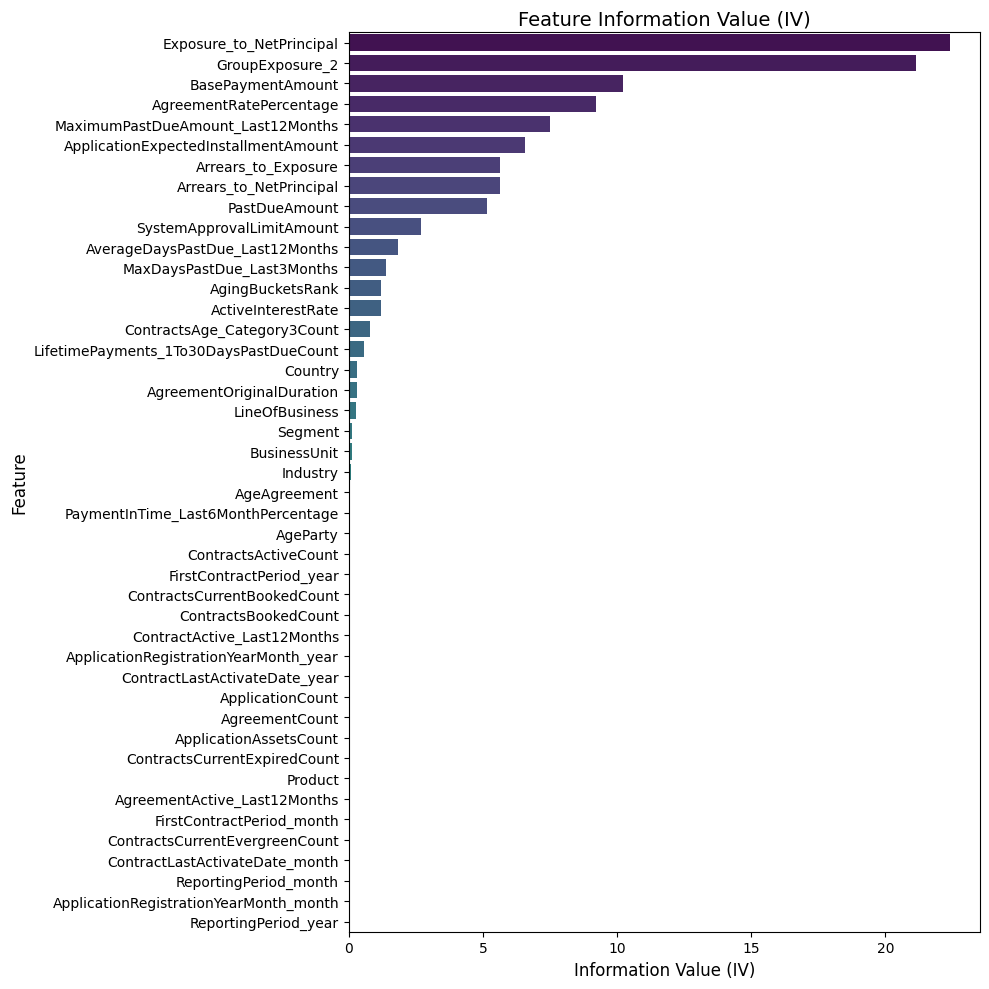

In [0]:
# Plot a horizontal bar plot with IV on the x-axis
plt.figure(figsize=(10, 10))
colors = sns.color_palette("viridis", len(iv_df))
sns.barplot(x='IV', y='Feature', data=iv_df, palette=colors)

# Customize the plot
plt.title("Feature Information Value (IV)", fontsize=14)
plt.xlabel("Information Value (IV)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.savefig('iv_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [0]:
# Set the IV threshold
iv_threshold = 0.02

# Identify columns to drop (those with IV below the threshold)
columns_to_drop = iv_df[iv_df['IV'] < iv_threshold]['Feature'].tolist()

In [0]:
train_df = train_df.drop(columns=columns_to_drop)

In [0]:
train_df.shape

(617804, 33)

#### 6.3 Correlation

In [0]:
X = train_df.drop(columns=[target_column])
y = train_df[target_column]
categorical_features, numeric_features = split_features_by_type(X)
print(len(categorical_features) + len(numeric_features))

32


In [0]:
numeric_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('frequency_encoder', CountEncoder(normalize=True))
])

preprocessor_for_correlation = ColumnTransformer(
    transformers=[
        ('num', numeric_preprocessor, numeric_features),
        ('cat', categorical_preprocessor, categorical_features)
        ]
)

In [0]:
X_imputed_encoded = pd.DataFrame(preprocessor_for_correlation.fit_transform(X), columns=numeric_features + categorical_features)

In [0]:
correlation_matrix = X_imputed_encoded.corr()
correlation_matrix

GroupExposure_2  ...   Segment
GroupExposure_2                                1.000000  ... -0.024257
AverageDaysPastDue_Last12Months               -0.008319  ...  0.009719
ContractActive_Last12Months                    0.154432  ... -0.013794
ContractsActiveCount                           0.269506  ... -0.035898
ContractsAge_Category3Count                    0.057019  ...  0.006559
ContractsBookedCount                           0.080452  ... -0.005202
ContractsCurrentBookedCount                    0.272124  ... -0.037916
LifetimePayments_1To30DaysPastDueCount         0.051002  ...  0.025864
MaxDaysPastDue_Last3Months                     0.024982  ...  0.012799
MaximumPastDueAmount_Last12Months              0.168992  ... -0.004280
PastDueAmount                                  0.083432  ... -0.002251
AgreementOriginalDuration                      0.037126  ...  0.252885
AgreementRatePercentage                       -0.181558  ...  0.074572
AgeAgreement                                  -0.215778  ...  0.085012
AgeParty                                       0.047411  ...  0.030011
AgingBucketsRank                              -0.006789  ...  0.013937
PaymentInTime_Last6MonthPercentage            -0.216858  ... -0.007483
BasePaymentAmount                              0.271466  ...  0.049277
SystemApprovalLimitAmount                      0.102637  ...  0.023947
ActiveInterestRate                            -0.076328  ... -0.171225
ApplicationExpectedInstallmentAmount           0.230767  ...  0.074803
Arrears_to_Exposure                           -0.021481  ...  0.001776
Exposure_to_NetPrincipal                       0.175374  ... -0.015439
Arrears_to_NetPrincipal                       -0.021872  ...  0.003423
ContractLastActivateDate_year                  0.212276  ... -0.083730
FirstContractPeriod_year                      -0.046826  ... -0.029392
ApplicationRegistrationYearMonth_year          0.173742  ... -0.051876
Country                                       -0.051015  ...  0.326619
Industry                                       0.127342  ...  0.393579
BusinessUnit                                  -0.155947  ...  0.662932
LineOfBusiness                                -0.048392  ...  0.408001
Segment                                       -0.024257  ...  1.000000

[32 rows x 32 columns]

In [0]:
pd.set_option('display.max_rows', None)
train_df.dtypes

Country                                   category
Industry                                  category
GroupExposure_2                            float64
AverageDaysPastDue_Last12Months            float64
ContractActive_Last12Months                  int64
ContractsActiveCount                         int64
ContractsAge_Category3Count                  int64
ContractsBookedCount                       float64
ContractsCurrentBookedCount                  int64
LifetimePayments_1To30DaysPastDueCount       int64
MaxDaysPastDue_Last3Months                 float64
MaximumPastDueAmount_Last12Months          float64
PastDueAmount                              float64
Default                                      int64
AgreementOriginalDuration                  float64
AgreementRatePercentage                    float64
AgeAgreement                                 int64
AgeParty                                     int64
AgingBucketsRank                             int64
PaymentInTime_Last6MonthPercent

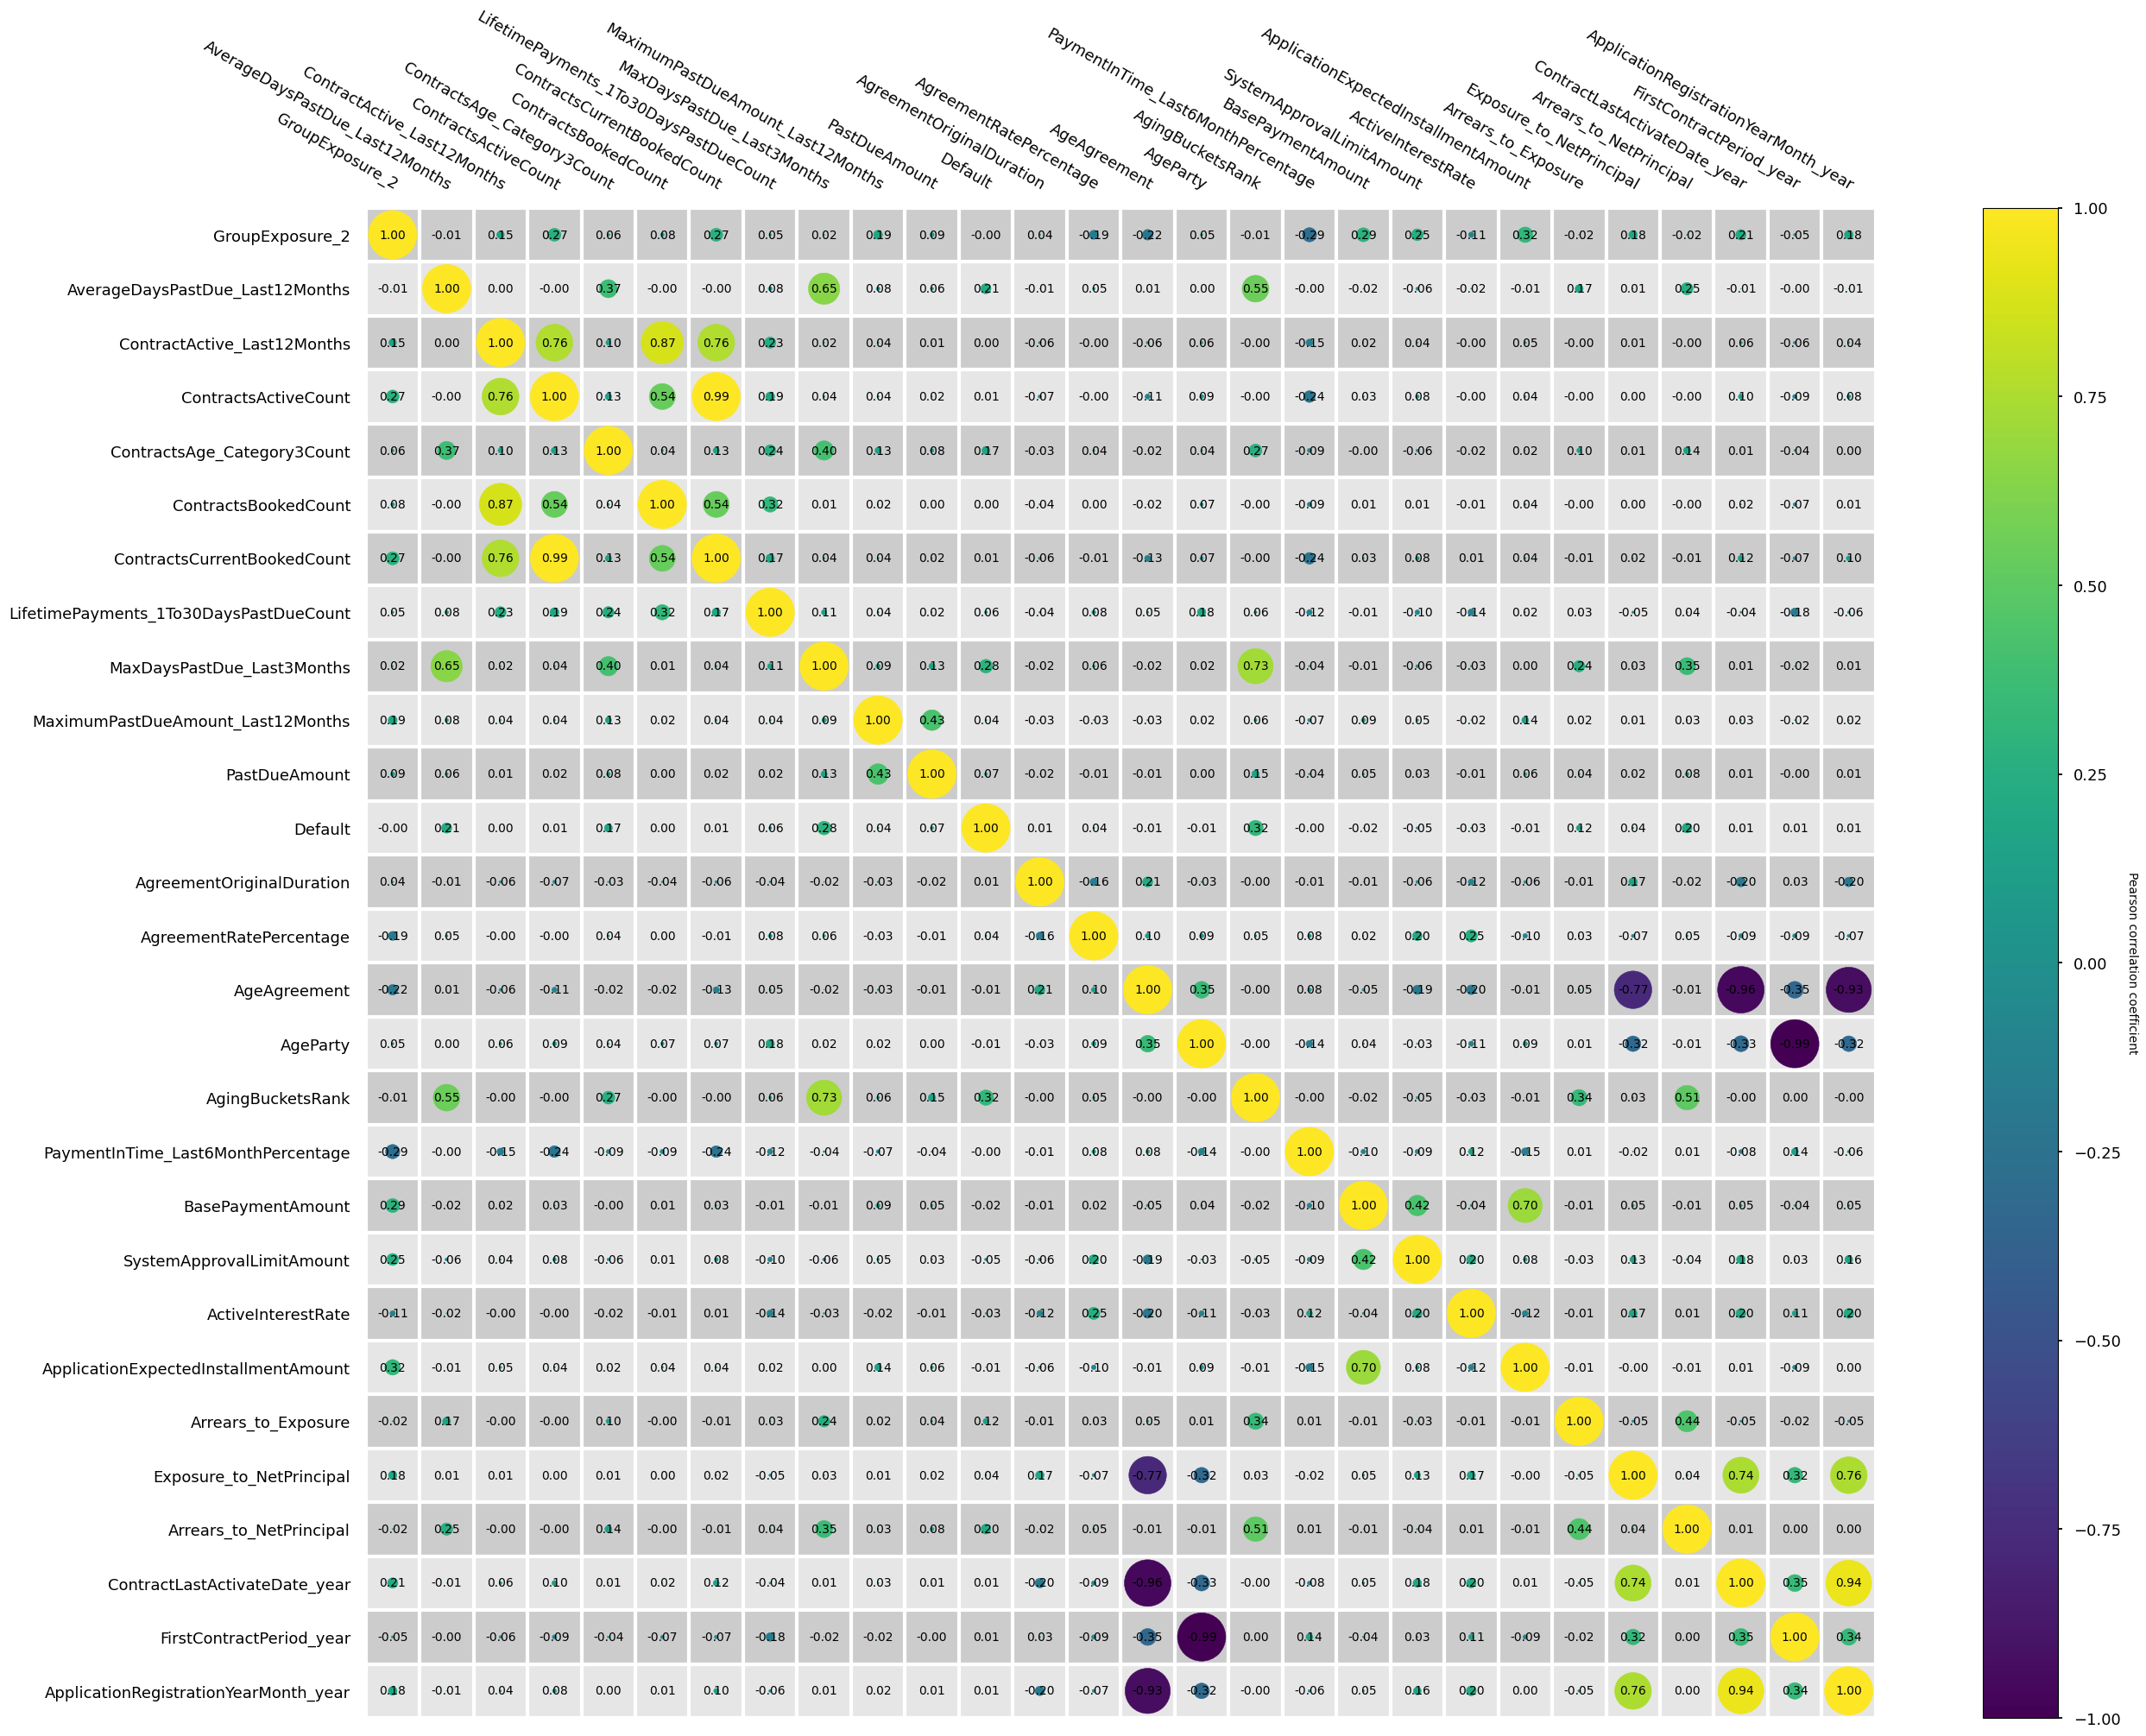

In [0]:
plt.style.use('seaborn-talk')

kwargs = {
    'heatmap': {
        'vmin': -1,
        'vmax': 1,
        'cmap': 'viridis',
    },
    'figure': {
        'figsize': (28, 20),
    },
}

plot_correlation_heatmap(train_df.select_dtypes(exclude='category'), bubble=True, annotate=True, **kwargs)
plt.savefig('correlation_matrix_bubble.png', dpi=300, bbox_inches='tight')
plt.show()

In [0]:
# Unstack the correlation matrix to get feature pairs
corr_unstacked = correlation_matrix.unstack()

# Convert the Series to a DataFrame for easier sorting
corr_df = pd.DataFrame(corr_unstacked, columns=['Correlation'])

# Reset index to get pairs of features in separate columns
corr_df = corr_df.reset_index()

# Rename the columns for clarity
corr_df.columns = ['Feature_1', 'Feature_2', 'Correlation']

# Remove self-correlations (i.e., where Feature_1 == Feature_2)
corr_df = corr_df[corr_df['Feature_1'] != corr_df['Feature_2']]

# Drop duplicate pairs (since correlation(A, B) is the same as correlation(B, A))
corr_df['Abs_Correlation'] = corr_df['Correlation'].abs()
corr_df = corr_df.drop_duplicates(subset=['Abs_Correlation'])

# Sort by absolute correlation value in descending order
corr_df = corr_df.sort_values(by='Abs_Correlation', ascending=False)

In [0]:
pd.set_option('display.max_rows', None)
corr_df

Feature_1  ... Abs_Correlation
473                                AgeParty  ...        0.994323
102                    ContractsActiveCount  ...        0.993741
440                            AgeAgreement  ...        0.959699
794           ContractLastActivateDate_year  ...        0.899952
442                            AgeAgreement  ...        0.887526
69              ContractActive_Last12Months  ...        0.872919
67              ContractActive_Last12Months  ...        0.759925
70              ContractActive_Last12Months  ...        0.757850
271              MaxDaysPastDue_Last3Months  ...        0.726171
438                            AgeAgreement  ...        0.720457
728                Exposure_to_NetPrincipal  ...        0.698670
730                Exposure_to_NetPrincipal  ...        0.673514
959                            BusinessUnit  ...        0.662932
40          AverageDaysPastDue_Last12Months  ...        0.647702
47          AverageDaysPastDue_Last12Months  ...        0.552167
101                    ContractsActiveCount  ...        0.536326
166                    ContractsBookedCount  ...        0.535779
503                        AgingBucketsRank  ...        0.503244
298       MaximumPastDueAmount_Last12Months  ...        0.416141
695                     Arrears_to_Exposure  ...        0.415725
991                          LineOfBusiness  ...        0.408001
136             ContractsAge_Category3Count  ...        0.398555
927                                Industry  ...        0.393579
36          AverageDaysPastDue_Last12Months  ...        0.373624
893                                 Country  ...        0.360479
793           ContractLastActivateDate_year  ...        0.350843
279              MaxDaysPastDue_Last3Months  ...        0.349238
606               SystemApprovalLimitAmount  ...        0.347833
441                            AgeAgreement  ...        0.347210
430                            AgeAgreement  ...        0.346424
501                        AgingBucketsRank  ...        0.335524
826                FirstContractPeriod_year  ...        0.333319
472                                AgeParty  ...        0.328069
895                                 Country  ...        0.326619
445                            AgeAgreement  ...        0.323273
797           ContractLastActivateDate_year  ...        0.321230
167                    ContractsBookedCount  ...        0.317570
729                Exposure_to_NetPrincipal  ...        0.316667
564                       BasePaymentAmount  ...        0.315872
474                                AgeParty  ...        0.314304
470                                AgeParty  ...        0.313996
958                            BusinessUnit  ...        0.303374
413                 AgreementRatePercentage  ...        0.302400
562                       BasePaymentAmount  ...        0.300278
861   ApplicationRegistrationYearMonth_year  ...        0.277463
6                           GroupExposure_2  ...        0.272124
17                          GroupExposure_2  ...        0.271466
3                           GroupExposure_2  ...        0.269506
635                      ActiveInterestRate  ...        0.267514
143             ContractsAge_Category3Count  ...        0.265520
894                                 Country  ...        0.263659
383               AgreementOriginalDuration  ...        0.252885
55          AverageDaysPastDue_Last12Months  ...        0.248029
135             ContractsAge_Category3Count  ...        0.235989
379               AgreementOriginalDuration  ...        0.234076
277              MaxDaysPastDue_Last3Months  ...        0.233725
71              ContractActive_Last12Months  ...        0.232124
20                          GroupExposure_2  ...        0.230767
380               AgreementOriginalDuration  ...        0.228375
603               SystemApprovalLimitAmount  ...        0.224133
16                          GroupExposure_2  ...        0.216858
13  

In [0]:
# save iv_df
corr_df.to_csv('correlation.csv', index=False)

In [0]:
corr_df = pd.read_csv('correlation.csv')

In [0]:
pd.set_option('display.max_rows', None)
corr_df

Feature_1  ... Abs_Correlation
0                                  AgeParty  ...        0.994323
1                      ContractsActiveCount  ...        0.993741
2                              AgeAgreement  ...        0.959699
3             ContractLastActivateDate_year  ...        0.899952
4                              AgeAgreement  ...        0.887526
5               ContractActive_Last12Months  ...        0.872919
6               ContractActive_Last12Months  ...        0.759925
7               ContractActive_Last12Months  ...        0.757850
8                MaxDaysPastDue_Last3Months  ...        0.726171
9                              AgeAgreement  ...        0.720457
10                 Exposure_to_NetPrincipal  ...        0.698670
11                 Exposure_to_NetPrincipal  ...        0.673514
12                             BusinessUnit  ...        0.662932
13          AverageDaysPastDue_Last12Months  ...        0.647702
14          AverageDaysPastDue_Last12Months  ...        0.552167
15                     ContractsActiveCount  ...        0.536326
16                     ContractsBookedCount  ...        0.535779
17                         AgingBucketsRank  ...        0.503244
18        MaximumPastDueAmount_Last12Months  ...        0.416141
19                      Arrears_to_Exposure  ...        0.415725
20                           LineOfBusiness  ...        0.408001
21              ContractsAge_Category3Count  ...        0.398555
22                                 Industry  ...        0.393579
23          AverageDaysPastDue_Last12Months  ...        0.373624
24                                  Country  ...        0.360479
25            ContractLastActivateDate_year  ...        0.350843
26               MaxDaysPastDue_Last3Months  ...        0.349238
27                SystemApprovalLimitAmount  ...        0.347833
28                             AgeAgreement  ...        0.347210
29                             AgeAgreement  ...        0.346424
30                         AgingBucketsRank  ...        0.335524
31                 FirstContractPeriod_year  ...        0.333319
32                                 AgeParty  ...        0.328069
33                                  Country  ...        0.326619
34                             AgeAgreement  ...        0.323273
35            ContractLastActivateDate_year  ...        0.321230
36                     ContractsBookedCount  ...        0.317570
37                 Exposure_to_NetPrincipal  ...        0.316667
38                        BasePaymentAmount  ...        0.315872
39                                 AgeParty  ...        0.314304
40                                 AgeParty  ...        0.313996
41                             BusinessUnit  ...        0.303374
42                  AgreementRatePercentage  ...        0.302400
43                        BasePaymentAmount  ...        0.300278
44    ApplicationRegistrationYearMonth_year  ...        0.277463
45                          GroupExposure_2  ...        0.272124
46                          GroupExposure_2  ...        0.271466
47                          GroupExposure_2  ...        0.269506
48                       ActiveInterestRate  ...        0.267514
49              ContractsAge_Category3Count  ...        0.265520
50                                  Country  ...        0.263659
51                AgreementOriginalDuration  ...        0.252885
52          AverageDaysPastDue_Last12Months  ...        0.248029
53              ContractsAge_Category3Count  ...        0.235989
54                AgreementOriginalDuration  ...        0.234076
55               MaxDaysPastDue_Last3Months  ...        0.233725
56              ContractActive_Last12Months  ...        0.232124
57                          GroupExposure_2  ...        0.230767
58                AgreementOriginalDuration  ...        0.228375
59                SystemApprovalLimitAmount  ...        0.224133
60                          GroupExposure_2  ...        0.216858
61  

In [0]:
# Set correlation threshold
correlation_threshold = 0.7

# Filter highly correlated pairs
high_corr_pairs = corr_df[corr_df['Abs_Correlation'] > correlation_threshold]

# Create a dictionary for fast lookup of IV values
iv_dict = dict(zip(iv_df['Feature'], iv_df['IV']))

# Initialize an empty set to store features to drop
columns_to_drop = set()

# Iterate over each highly correlated pair and keep the feature with the higher IV
for _, row in high_corr_pairs.iterrows():
    feature_1 = row['Feature_1']
    feature_2 = row['Feature_2']
    iv_feature_1 = iv_dict.get(feature_1, 0)
    iv_feature_2 = iv_dict.get(feature_2, 0)
    
    # Keep the feature with the higher IV and add the other to columns_to_drop
    if iv_feature_1 >= iv_feature_2:
        columns_to_drop.add(feature_2)
    else:
        columns_to_drop.add(feature_1)

# Convert columns_to_drop to a list if needed
columns_to_drop = list(columns_to_drop)

In [0]:
train_df = train_df.drop(columns=columns_to_drop)

In [0]:
train_df.shape

(617804, 26)

## 7. 25 features

In [0]:
train_modelling_df = train_df.copy()

In [0]:
train_modelling_df.shape

(617804, 26)

In [0]:
folds = rolling_window_split_by_group(train_modelling_df, window_size=6, validation_size=2)

In [0]:
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    print(f"Fold {i + 1}")
    
    # Get the unique dates (ReportingPeriod_AGR) from the training and validation sets
    train_dates = X_train.index.to_period('M').unique()
    val_dates = X_val.index.to_period('M').unique()
    
    print(f"Training set unique dates: {train_dates}")
    print(f"Number of unique training dates: {len(train_dates)}")
    
    print(f"Validation set unique dates: {val_dates}")
    print(f"Number of unique validation dates: {len(val_dates)}")
    
    print("\n")

Fold 1
Training set unique dates: PeriodIndex(['2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03'], dtype='period[M]', name='ReportingPeriod')
Number of unique training dates: 6
Validation set unique dates: PeriodIndex(['2022-04', '2022-05'], dtype='period[M]', name='ReportingPeriod')
Number of unique validation dates: 2


Fold 2
Training set unique dates: PeriodIndex(['2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04'], dtype='period[M]', name='ReportingPeriod')
Number of unique training dates: 6
Validation set unique dates: PeriodIndex(['2022-05', '2022-06'], dtype='period[M]', name='ReportingPeriod')
Number of unique validation dates: 2


Fold 3
Training set unique dates: PeriodIndex(['2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05'], dtype='period[M]', name='ReportingPeriod')
Number of unique training dates: 6
Validation set unique dates: PeriodIndex(['2022-06', '2022-07'], dtype='period[M]', name='ReportingPeriod')
Number of unique valid

In [0]:
X = train_modelling_df.drop(columns=[target_column])
y = train_modelling_df[target_column]

In [0]:
feature_names = X.columns.tolist()

In [0]:
feature_names

['Country',
 'Industry',
 'GroupExposure_2',
 'AverageDaysPastDue_Last12Months',
 'ContractsActiveCount',
 'ContractsAge_Category3Count',
 'ContractsBookedCount',
 'LifetimePayments_1To30DaysPastDueCount',
 'MaxDaysPastDue_Last3Months',
 'MaximumPastDueAmount_Last12Months',
 'PastDueAmount',
 'AgreementOriginalDuration',
 'AgreementRatePercentage',
 'AgeParty',
 'PaymentInTime_Last6MonthPercentage',
 'BasePaymentAmount',
 'SystemApprovalLimitAmount',
 'ActiveInterestRate',
 'ApplicationExpectedInstallmentAmount',
 'BusinessUnit',
 'LineOfBusiness',
 'Segment',
 'Arrears_to_Exposure',
 'Exposure_to_NetPrincipal',
 'Arrears_to_NetPrincipal']

#### 7.1 Baseline - Logistic Regression

In [0]:
categorical_features, numeric_features = split_features_by_type(X)
print(len(categorical_features) + len(numeric_features))

25


In [0]:
numeric_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('frequency_encoder', CountEncoder(normalize=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_preprocessor, numeric_features),
        ('cat', categorical_preprocessor, categorical_features)
        ]
)

In [0]:
lr = LogisticRegression(random_state=42)

lr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('sampler', sampler),
    ('classifier', lr)
])

lr_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['GroupExposure_2',
                                                   'AverageDaysPastDue_Last12Months',
                                                   'ContractsActiveCount',
                                                   'ContractsAge_Category3Count',
                                                   'ContractsBookedCount',
                                                   'LifetimePayments_1To30DaysPastDueCount',
                                                   'MaxDaysPastDue_La...
                                                   'Arrears_to_NetPrincipal']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('frequency_encoder',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                normalize=True))]),
                                                  ['Country', 'Industry',
                                                   'BusinessUnit',
                                                   'LineOfBusiness',
                                                   'Segment'])])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('classifier', LogisticRegression(random_state=42))])

In [0]:
# Initialize list to hold metrics for each fold
results = []

# Loop through each fold
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    
    # Train the logistic regression pipeline
    lr_pipe.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = lr_pipe.predict(X_val)
    y_pred_prob = lr_pipe.predict_proba(X_val)[:, 1]
    
    # Evaluate model performance
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_roc = roc_auc_score(y_val, y_pred_prob)
    
    # Calculate precision-recall curve and area under PR curve (AUC-PR)
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_pred_prob)
    auc_pr = auc(recall_curve, precision_curve)
    
    # Store results for each fold
    results.append({
        'fold': i+1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': auc_roc,
        'auc_pr': auc_pr
    })
    
    # Print confusion matrix and classification report for each fold
    cm = confusion_matrix(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    
    print(f"\nFold {i+1} Results:")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)

# Convert results into a DataFrame for better display
results_df = pd.DataFrame(results)

# Add row for the average of each metric
results_df.loc['mean'] = results_df.mean()

# Display the table with fold-wise metrics and the final mean
print("\nCross-Validation Results (Fold-wise and Mean):")
results_df


Fold 1 Results:
Confusion Matrix:
 [[90229  9699]
 [ 1075  1673]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     99928
           1       0.15      0.61      0.24      2748

    accuracy                           0.90    102676
   macro avg       0.57      0.76      0.59    102676
weighted avg       0.97      0.90      0.92    102676


Fold 2 Results:
Confusion Matrix:
 [[88971 11110]
 [ 1126  1743]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.89      0.94    100081
           1       0.14      0.61      0.22      2869

    accuracy                           0.88    102950
   macro avg       0.56      0.75      0.58    102950
weighted avg       0.96      0.88      0.92    102950


Fold 3 Results:
Confusion Matrix:
 [[88978 11155]
 [ 1137  1779]]
Classification Report:
               precision    recall  f1-score   support

           0      

fold  accuracy  precision    recall  f1_score   roc_auc    auc_pr
0      1.0  0.895068   0.147116  0.608806  0.236969  0.827649  0.207599
1      2.0  0.881146   0.135610  0.607529  0.221728  0.819718  0.203074
2      3.0  0.880717   0.137544  0.610082  0.224479  0.825917  0.211047
3      4.0  0.871657   0.132274  0.637681  0.219100  0.825241  0.213486
4      5.0  0.856432   0.119726  0.641327  0.201783  0.818548  0.219845
mean   3.0  0.877004   0.134454  0.621085  0.220812  0.823415  0.211010

In [0]:
results_df.to_csv('training_performance_25_lr.csv', index=False)

In [0]:
features_to_keep = train_modelling_df.columns.tolist()

In [0]:
features_to_keep

['Country',
 'Industry',
 'GroupExposure_2',
 'AverageDaysPastDue_Last12Months',
 'ContractsActiveCount',
 'ContractsAge_Category3Count',
 'ContractsBookedCount',
 'LifetimePayments_1To30DaysPastDueCount',
 'MaxDaysPastDue_Last3Months',
 'MaximumPastDueAmount_Last12Months',
 'PastDueAmount',
 'Default',
 'AgreementOriginalDuration',
 'AgreementRatePercentage',
 'AgeParty',
 'PaymentInTime_Last6MonthPercentage',
 'BasePaymentAmount',
 'SystemApprovalLimitAmount',
 'ActiveInterestRate',
 'ApplicationExpectedInstallmentAmount',
 'BusinessUnit',
 'LineOfBusiness',
 'Segment',
 'Arrears_to_Exposure',
 'Exposure_to_NetPrincipal',
 'Arrears_to_NetPrincipal']

In [0]:
test_final_df = test_df[features_to_keep]

#### 7.2 Random Forest

In [0]:
numeric_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('frequency_encoder', CountEncoder(normalize=True))
])
    
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_preprocessor, numeric_features),
        ('cat', categorical_preprocessor, categorical_features)
    ]
)

In [0]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    
# Create a pipeline with preprocessing, sampling, and random forest classifier
rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', rf)
])

rf_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['GroupExposure_2',
                                                   'AverageDaysPastDue_Last12Months',
                                                   'ContractsActiveCount',
                                                   'ContractsAge_Category3Count',
                                                   'ContractsBookedCount',
                                                   'LifetimePayments_1To30DaysPastDueCount',
                                                   'MaxDaysPastDue_Last3Months',
                                                   'MaximumPastDueAm...
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('frequency_encoder',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                normalize=True))]),
                                                  ['Country', 'Industry',
                                                   'BusinessUnit',
                                                   'LineOfBusiness',
                                                   'Segment'])])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

In [0]:
# Initialize list to hold metrics for each fold
results = []

# Loop through each fold
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    
    # Train the logistic regression pipeline
    rf_pipe.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = rf_pipe.predict(X_val)
    y_pred_prob = rf_pipe.predict_proba(X_val)[:, 1]
    
    # Evaluate model performance
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_roc = roc_auc_score(y_val, y_pred_prob)
    
    # Calculate precision-recall curve and area under PR curve (AUC-PR)
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_pred_prob)
    auc_pr = auc(recall_curve, precision_curve)
    
    # Store results for each fold
    results.append({
        'fold': i+1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': auc_roc,
        'auc_pr': auc_pr
    })
    
    # Print confusion matrix and classification report for each fold
    cm = confusion_matrix(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    
    print(f"\nFold {i+1} Results:")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)

# Convert results into a DataFrame for better display
results_df = pd.DataFrame(results)

# Add row for the average of each metric
results_df.loc['mean'] = results_df.mean()

# Display the table with fold-wise metrics and the final mean
print("\nCross-Validation Results (Fold-wise and Mean):")
results_df


Fold 1 Results:
Confusion Matrix:
 [[83968 15960]
 [  800  1948]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91     99928
           1       0.11      0.71      0.19      2748

    accuracy                           0.84    102676
   macro avg       0.55      0.77      0.55    102676
weighted avg       0.97      0.84      0.89    102676


Fold 2 Results:
Confusion Matrix:
 [[83995 16086]
 [  881  1988]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91    100081
           1       0.11      0.69      0.19      2869

    accuracy                           0.84    102950
   macro avg       0.55      0.77      0.55    102950
weighted avg       0.97      0.84      0.89    102950


Fold 3 Results:
Confusion Matrix:
 [[83289 16844]
 [  879  2037]]
Classification Report:
               precision    recall  f1-score   support

           0      

fold  accuracy  precision    recall  f1_score   roc_auc    auc_pr
0      1.0  0.836768   0.108778  0.708879  0.188613  0.851652  0.265689
1      2.0  0.835192   0.109992  0.692924  0.189849  0.844088  0.262619
2      3.0  0.828014   0.107886  0.698560  0.186906  0.841892  0.264460
3      4.0  0.819289   0.104638  0.714631  0.182547  0.844776  0.278234
4      5.0  0.814419   0.102378  0.715619  0.179129  0.840367  0.273484
mean   3.0  0.826736   0.106735  0.706123  0.185409  0.844555  0.268897

In [0]:
results_df.to_csv('training_performance_25_rf.csv', index=False)

In [0]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

# Initialize a list to store the results
results = []

# Loop through each parameter combination
for params in ParameterGrid(param_grid):
    fold_metrics = []
    
    print(f"Testing parameters: {params}")
    
    # Loop through each fold in the rolling window cross-validation
    for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
        
        # Define the random forest classifier with the current hyperparameters
        rf = RandomForestClassifier(random_state=42, n_jobs=-1, **params)
        
        # Create the pipeline with preprocessing, undersampling, and classifier
        rf_pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('sampler', RandomUnderSampler(random_state=42)),  # Undersampling before training
            ('classifier', rf)
        ])
        
        # Fit the pipeline on the training data
        rf_pipe.fit(X_train, y_train)
        
        # Predict probabilities and classes for the validation set
        y_pred = rf_pipe.predict(X_val)
        y_pred_prob = rf_pipe.predict_proba(X_val)[:, 1]
        
        # Compute metrics for this fold
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        roc_auc = roc_auc_score(y_val, y_pred_prob)
        
        # Calculate Precision-Recall curve and AUC-PR
        precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_pred_prob)
        auc_pr = auc(recall_curve, precision_curve)
        
        # Store the fold metrics
        fold_metrics.append({
            'fold': i+1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'auc_pr': auc_pr
        })
    
    # Convert fold metrics to a DataFrame
    fold_metrics_df = pd.DataFrame(fold_metrics)
    
    # Calculate the mean metrics across all folds
    mean_metrics = fold_metrics_df.mean().to_dict()
    
    # Add parameter info to the results
    mean_metrics.update(params)
    
    # Append the mean metrics to the results list
    results.append(mean_metrics)

# Convert the results into a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Sort by the best AUC-PR (as we are primarily optimizing for AUC-PR)
results_df = results_df.sort_values(by='auc_pr', ascending=False)

# Display the results in the console
print("\nGridSearch Results (sorted by AUC-PR):")
print(results_df)

# Display the best parameters and metrics
best_params = results_df.iloc[0]
print(f"\nBest parameters found: {best_params.to_dict()}")

In [0]:
results_df.to_csv('hyperparameter_tuning_rf.csv', index=False)

In [0]:
parameters_rf = pd.read_csv('hyperparameter_tuning_rf.csv')

In [0]:
parameters_rf.loc[[parameters_rf['auc_pr'].idxmax()]]

fold  accuracy  precision  ...  min_samples_leaf  min_samples_split  n_estimators
0   3.0  0.846602   0.117676  ...                 1                  2           400

[1 rows x 12 columns]

In [0]:
# Use the best parameters found during tuning
best_params = {
    'max_depth': 10,
    'max_features': 'log2',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 400
}

# Initialize Random Forest with the best parameters
rf = RandomForestClassifier(random_state=42, n_jobs=-1, **best_params)

# Create a pipeline with preprocessing, undersampling, and the Random Forest classifier
rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', rf)
])

rf_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['GroupExposure_2',
                                                   'AverageDaysPastDue_Last12Months',
                                                   'ContractsActiveCount',
                                                   'ContractsAge_Category3Count',
                                                   'ContractsBookedCount',
                                                   'LifetimePayments_1To30DaysPastDueCount',
                                                   'MaxDaysPastDue_Last3Months',
                                                   'MaximumPastDueAm...
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('frequency_encoder',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                normalize=True))]),
                                                  ['Country', 'Industry',
                                                   'BusinessUnit',
                                                   'LineOfBusiness',
                                                   'Segment'])])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('classifier',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                                        n_estimators=400, n_jobs=-1,
                                        random_state=42))])

In [0]:
# Initialize list to hold metrics for each fold
results = []

# Loop through each fold
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    
    # Train the logistic regression pipeline
    rf_pipe.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = rf_pipe.predict(X_val)
    y_pred_prob = rf_pipe.predict_proba(X_val)[:, 1]
    
    # Evaluate model performance
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_roc = roc_auc_score(y_val, y_pred_prob)
    
    # Calculate precision-recall curve and area under PR curve (AUC-PR)
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_pred_prob)
    auc_pr = auc(recall_curve, precision_curve)
    
    # Store results for each fold
    results.append({
        'fold': i+1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': auc_roc,
        'auc_pr': auc_pr
    })
    
    # Print confusion matrix and classification report for each fold
    cm = confusion_matrix(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    
    print(f"\nFold {i+1} Results:")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)

# Convert results into a DataFrame for better display
results_df = pd.DataFrame(results)

# Add row for the average of each metric
results_df.loc['mean'] = results_df.mean()

# Display the table with fold-wise metrics and the final mean
print("\nCross-Validation Results (Fold-wise and Mean):")
results_df


Fold 1 Results:
Confusion Matrix:
 [[86642 13286]
 [  860  1888]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.92     99928
           1       0.12      0.69      0.21      2748

    accuracy                           0.86    102676
   macro avg       0.56      0.78      0.57    102676
weighted avg       0.97      0.86      0.91    102676


Fold 2 Results:
Confusion Matrix:
 [[86104 13977]
 [  942  1927]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92    100081
           1       0.12      0.67      0.21      2869

    accuracy                           0.86    102950
   macro avg       0.56      0.77      0.56    102950
weighted avg       0.96      0.86      0.90    102950


Fold 3 Results:
Confusion Matrix:
 [[85452 14681]
 [  917  1999]]
Classification Report:
               precision    recall  f1-score   support

           0      

fold  accuracy  precision    recall  f1_score   roc_auc    auc_pr
0      1.0  0.862227   0.124423  0.687045  0.210691  0.861751  0.289691
1      2.0  0.855085   0.121164  0.671663  0.205295  0.851364  0.276903
2      3.0  0.848635   0.119844  0.685528  0.204021  0.850273  0.294929
3      4.0  0.836719   0.113577  0.702899  0.195555  0.850306  0.302836
4      5.0  0.830346   0.109370  0.699378  0.189159  0.846130  0.297363
mean   3.0  0.846602   0.117676  0.689302  0.200944  0.851964  0.292344

In [0]:
results_df.to_csv('training_performance_25_ht_rf.csv', index=False)

###### Performance on test

In [0]:
# Apply the pipeline's transformations to the test set without re-fitting
X_test = test_final_df.drop(columns=target_column)
y_test = test_final_df[target_column]
X_test_transformed = rf_pipe.named_steps['preprocessor'].transform(X_test)  # Preprocessing only
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)

In [0]:
# Use the classifier within the pipeline to predict probabilities on the transformed test set
y_pred_prob = rf_pipe.named_steps['classifier'].predict_proba(X_test_transformed)[:, 1]

# Apply the 0.5 threshold to convert probabilities to binary predictions
threshold = 0.5
y_pred = (y_pred_prob >= threshold).astype(int)

# Evaluate model performance on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_prob)

# Calculate precision-recall curve and area under PR curve (AUC-PR)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_prob)
auc_pr = auc(recall_curve, precision_curve)

# Display metrics
print("Test Set Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {auc_roc:.4f}")
print(f"AUC-PR: {auc_pr:.4f}")

# Print confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

Test Set Performance:
Accuracy: 0.8345
Precision: 0.1156
Recall: 0.6989
F1 Score: 0.1984
ROC AUC: 0.8440
AUC-PR: 0.3031

Confusion Matrix:
 [[126139  24280]
 [  1368   3175]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91    150419
           1       0.12      0.70      0.20      4543

    accuracy                           0.83    154962
   macro avg       0.55      0.77      0.55    154962
weighted avg       0.96      0.83      0.89    154962



In [0]:
test_rf = pd.DataFrame({
    'Pred_Label_RF': y_pred,
    'Pred_Prob_RF': y_pred_prob,
    'True_Label': y_test
})

In [0]:
test_rf.to_csv('test_rf.csv', index=False)

#### 7.3 XGBoost

In [0]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
    
# Create a pipeline with preprocessing, sampling, and XGBoost classifier
xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', xgb)
])

xgb_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['GroupExposure_2',
                                                   'AverageDaysPastDue_Last12Months',
                                                   'ContractsActiveCount',
                                                   'ContractsAge_Category3Count',
                                                   'ContractsBookedCount',
                                                   'LifetimePayments_1To30DaysPastDueCount',
                                                   'MaxDaysPastDue_Last3Months',
                                                   'MaximumPastDueAm...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

In [0]:
# Initialize list to hold metrics for each fold
results = []

# Loop through each fold
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    
    # Train the logistic regression pipeline
    xgb_pipe.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = xgb_pipe.predict(X_val)
    y_pred_prob = xgb_pipe.predict_proba(X_val)[:, 1]
    
    # Evaluate model performance
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_roc = roc_auc_score(y_val, y_pred_prob)
    
    # Calculate precision-recall curve and area under PR curve (AUC-PR)
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_pred_prob)
    auc_pr = auc(recall_curve, precision_curve)
    
    # Store results for each fold
    results.append({
        'fold': i+1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': auc_roc,
        'auc_pr': auc_pr
    })
    
    # Print confusion matrix and classification report for each fold
    cm = confusion_matrix(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    
    print(f"\nFold {i+1} Results:")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)

# Convert results into a DataFrame for better display
results_df = pd.DataFrame(results)

# Add row for the average of each metric
results_df.loc['mean'] = results_df.mean()

# Display the table with fold-wise metrics and the final mean
print("\nCross-Validation Results (Fold-wise and Mean):")
results_df


Fold 1 Results:
Confusion Matrix:
 [[83130 16798]
 [  781  1967]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90     99928
           1       0.10      0.72      0.18      2748

    accuracy                           0.83    102676
   macro avg       0.55      0.77      0.54    102676
weighted avg       0.97      0.83      0.89    102676


Fold 2 Results:
Confusion Matrix:
 [[82487 17594]
 [  834  2035]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90    100081
           1       0.10      0.71      0.18      2869

    accuracy                           0.82    102950
   macro avg       0.55      0.77      0.54    102950
weighted avg       0.97      0.82      0.88    102950


Fold 3 Results:
Confusion Matrix:
 [[82152 17981]
 [  834  2082]]
Classification Report:
               precision    recall  f1-score   support

           0      

fold  accuracy  precision    recall  f1_score   roc_auc    auc_pr
0      1.0  0.828792   0.104823  0.715793  0.182866  0.850706  0.255925
1      2.0  0.821000   0.103673  0.709306  0.180905  0.840133  0.260728
2      3.0  0.817417   0.103773  0.713992  0.181209  0.846027  0.260658
3      4.0  0.807354   0.098195  0.711525  0.172574  0.842141  0.268476
4      5.0  0.807546   0.098018  0.707326  0.172176  0.838007  0.272893
mean   3.0  0.816422   0.101696  0.711588  0.177946  0.843403  0.263736

In [0]:
results_df.to_csv('training_performance_25_xgb.csv', index=False)

In [0]:
# Define the parameter grid for XGBoost
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 6, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0], 
    # 'reg_lambda': [0.1, 1, 10],
    # 'reg_alpha': [0.1, 1, 10],
    # 'gamma': [0, 0.1, 0.2],
}

# Initialize a list to store the results
results = []

# Loop through each parameter combination
for params in ParameterGrid(param_grid):
    fold_metrics = []
    
    print(f"Testing parameters: {params}")
    
    # Loop through each fold in the rolling window cross-validation
    for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
        
        # Define the XGBoost classifier with the current hyperparameters
        xgb = XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss', **params)
        
        # Create the pipeline with preprocessing, undersampling, and classifier
        xgb_pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('sampler', RandomUnderSampler(random_state=42)),
            ('classifier', xgb)
        ])
        
        # Fit the pipeline on the training data
        xgb_pipe.fit(X_train, y_train)
        
        # Predict probabilities and classes for the validation set
        y_pred = xgb_pipe.predict(X_val)
        y_pred_prob = xgb_pipe.predict_proba(X_val)[:, 1]
        
        # Compute metrics for this fold
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        roc_auc = roc_auc_score(y_val, y_pred_prob)
        
        # Calculate Precision-Recall curve and AUC-PR
        precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_pred_prob)
        auc_pr = auc(recall_curve, precision_curve)
        
        # Store the fold metrics
        fold_metrics.append({
            'fold': i+1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'auc_pr': auc_pr
        })
    
    # Convert fold metrics to a DataFrame
    fold_metrics_df = pd.DataFrame(fold_metrics)
    
    # Calculate the mean metrics across all folds
    mean_metrics = fold_metrics_df.mean().to_dict()
    
    # Add parameter info to the results
    mean_metrics.update(params)
    
    # Append the mean metrics to the results list
    results.append(mean_metrics)

# Convert the results into a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Sort by the best AUC-PR (as we are primarily optimizing for AUC-PR)
results_df = results_df.sort_values(by='auc_pr', ascending=False)

# Display the results in the console
print("\nGridSearch Results (sorted by AUC-PR):")
print(results_df)

# Display the best parameters and metrics
best_params = results_df.iloc[0]
print(f"\nBest parameters found: {best_params.to_dict()}")

In [0]:
results_df.to_csv('hyperparameter_tuning_xgb.csv', index=False)

In [0]:
parameters_xgb = pd.read_csv('hyperparameter_tuning_xgb.csv')

In [0]:
parameters_xgb.loc[[parameters_xgb['auc_pr'].idxmax()]]

fold  accuracy  precision  ...  max_depth  n_estimators  subsample
0   3.0  0.843024   0.113894  ...          3           100        1.0

[1 rows x 12 columns]

In [0]:
best_params = {
    'learning_rate': 0.01,
    'n_estimators': 100,
    'max_depth': 3,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
}

# Initialize XGBoost classifier with scale_pos_weight
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1, **best_params)

# Create a pipeline with preprocessing and XGBoost classifier
xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', xgb)
])

xgb_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['GroupExposure_2',
                                                   'AverageDaysPastDue_Last12Months',
                                                   'ContractsActiveCount',
                                                   'ContractsAge_Category3Count',
                                                   'ContractsBookedCount',
                                                   'LifetimePayments_1To30DaysPastDueCount',
                                                   'MaxDaysPastDue_Last3Months',
                                                   'MaximumPastDueAm...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

In [0]:
# Initialize list to hold metrics for each fold
results = []

# Loop through each fold
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    
    # Convert y_train to a NumPy array for each fold if necessary
    y_train = np.array(y_train)
    
    # Train the XGBoost pipeline
    xgb_pipe.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = xgb_pipe.predict(X_val)
    y_pred_prob = xgb_pipe.predict_proba(X_val)[:, 1]
    
    # Evaluate model performance
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_roc = roc_auc_score(y_val, y_pred_prob)
    
    # Calculate precision-recall curve and area under PR curve (AUC-PR)
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_pred_prob)
    auc_pr = auc(recall_curve, precision_curve)
    
    # Store results for each fold
    results.append({
        'fold': i+1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': auc_roc,
        'auc_pr': auc_pr
    })
    
    # Print confusion matrix and classification report for each fold
    cm = confusion_matrix(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    
    print(f"\nFold {i+1} Results:")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)

# Convert results into a DataFrame for better display
results_df = pd.DataFrame(results)

# Add row for the average of each metric
results_df.loc['mean'] = results_df.mean()

# Display the table with fold-wise metrics and the final mean
print("\nCross-Validation Results (Fold-wise and Mean):")
results_df


Fold 1 Results:
Confusion Matrix:
 [[86584 13344]
 [  891  1857]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.92     99928
           1       0.12      0.68      0.21      2748

    accuracy                           0.86    102676
   macro avg       0.56      0.77      0.57    102676
weighted avg       0.97      0.86      0.90    102676


Fold 2 Results:
Confusion Matrix:
 [[85428 14653]
 [  931  1938]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92    100081
           1       0.12      0.68      0.20      2869

    accuracy                           0.85    102950
   macro avg       0.55      0.76      0.56    102950
weighted avg       0.96      0.85      0.90    102950


Fold 3 Results:
Confusion Matrix:
 [[85018 15115]
 [  945  1971]]
Classification Report:
               precision    recall  f1-score   support

           0      

fold  accuracy  precision    recall  f1_score   roc_auc    auc_pr
0      1.0  0.861360   0.122163  0.675764  0.206920  0.847757  0.295307
1      2.0  0.848626   0.116810  0.675497  0.199178  0.838244  0.285229
2      3.0  0.844152   0.115358  0.675926  0.197080  0.836123  0.304654
3      4.0  0.833689   0.110145  0.690821  0.189997  0.834705  0.306467
4      5.0  0.827296   0.104996  0.678300  0.181843  0.829251  0.306619
mean   3.0  0.843024   0.113894  0.679262  0.195004  0.837216  0.299655

In [0]:
results_df.to_csv('training_performance_25_ht_xgb.csv', index=False)

###### XGBoost on test

In [0]:
# Use the classifier within the pipeline to predict probabilities on the transformed test set
y_pred_prob = xgb_pipe.named_steps['classifier'].predict_proba(X_test_transformed)[:, 1]

# Apply the 0.5 threshold to convert probabilities to binary predictions
threshold = 0.5
y_pred = (y_pred_prob >= threshold).astype(int)

# Evaluate model performance on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_prob)

# Calculate precision-recall curve and area under PR curve (AUC-PR)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_prob)
auc_pr = auc(recall_curve, precision_curve)

# Display metrics
print("Test Set Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {auc_roc:.4f}")
print(f"AUC-PR: {auc_pr:.4f}")

# Print confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

Test Set Performance:
Accuracy: 0.8301
Precision: 0.1113
Recall: 0.6863
F1 Score: 0.1915
ROC AUC: 0.8270
AUC-PR: 0.3087

Confusion Matrix:
 [[125520  24899]
 [  1425   3118]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.91    150419
           1       0.11      0.69      0.19      4543

    accuracy                           0.83    154962
   macro avg       0.55      0.76      0.55    154962
weighted avg       0.96      0.83      0.88    154962



In [0]:
test_xgb = pd.DataFrame({
    'Pred_Label_XGB': y_pred,
    'Pred_Prob_XGB': y_pred_prob,
    'True_Label': y_test
})

In [0]:
test_xgb.to_csv('test_xgb.csv', index=False)

#### 7.4 LightGBM

In [0]:
# Initialize LightGBM classifier
lgbm = LGBMClassifier(random_state=42, n_jobs=-1)

# Create a pipeline with preprocessing, sampling, and LightGBM classifier
lgbm_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', lgbm)
])

lgbm_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['GroupExposure_2',
                                                   'AverageDaysPastDue_Last12Months',
                                                   'ContractsActiveCount',
                                                   'ContractsAge_Category3Count',
                                                   'ContractsBookedCount',
                                                   'LifetimePayments_1To30DaysPastDueCount',
                                                   'MaxDaysPastDue_Last3Months',
                                                   'MaximumPastDueAm...
                                                   'Arrears_to_NetPrincipal']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('frequency_encoder',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                normalize=True))]),
                                                  ['Country', 'Industry',
                                                   'BusinessUnit',
                                                   'LineOfBusiness',
                                                   'Segment'])])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('classifier', LGBMClassifier(n_jobs=-1, random_state=42))])

In [0]:
# Initialize list to hold metrics for each fold
results = []

# Loop through each fold
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    
    # Train the LightGBM pipeline
    lgbm_pipe.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = lgbm_pipe.predict(X_val)
    y_pred_prob = lgbm_pipe.predict_proba(X_val)[:, 1]
    
    # Evaluate model performance
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_roc = roc_auc_score(y_val, y_pred_prob)
    
    # Calculate precision-recall curve and area under PR curve (AUC-PR)
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_pred_prob)
    auc_pr = auc(recall_curve, precision_curve)
    
    # Store results for each fold
    results.append({
        'fold': i+1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': auc_roc,
        'auc_pr': auc_pr
    })
    
    # Print confusion matrix and classification report for each fold
    cm = confusion_matrix(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    
    print(f"\nFold {i+1} Results:")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)

# Convert results into a DataFrame for better display
results_df = pd.DataFrame(results)

# Add row for the average of each metric
results_df.loc['mean'] = results_df.mean()

# Display the table with fold-wise metrics and the final mean
print("\nCross-Validation Results (Fold-wise and Mean):")
results_df

[LightGBM] [Info] Number of positive: 8840, number of negative: 8840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 17680, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Fold 1 Results:
Confusion Matrix:
 [[85011 14917]
 [  799  1949]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92     99928
           1       0.12      0.71      0.20      2748

    accuracy                           0.85    102676
   macro avg       0.55      0.78      0.56    102676
weighted avg       0.97      0.85      0.90    102676

[LightGBM] [Info] Number of positive: 8600, number of negative: 8600
[LightGBM] [

fold  accuracy  precision    recall  f1_score   roc_auc    auc_pr
0      1.0  0.846936   0.115558  0.709243  0.198736  0.861274  0.280452
1      2.0  0.842040   0.115166  0.698501  0.197731  0.851453  0.278010
2      3.0  0.835826   0.114440  0.712620  0.197210  0.852490  0.286779
3      4.0  0.824414   0.107943  0.718427  0.187686  0.851224  0.291726
4      5.0  0.824402   0.107124  0.709744  0.186152  0.846005  0.297060
mean   3.0  0.834723   0.112046  0.709707  0.193503  0.852489  0.286805

In [0]:
results_df.to_csv('training_performance_25_lgbm.csv', index=False)

In [0]:
# Define the parameter grid for LightGBM
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 6, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [ 0.8, 1.0],
}

# Initialize a list to store the results
results = []

# Loop through each parameter combination
for params in ParameterGrid(param_grid):
    fold_metrics = []
    
    print(f"Testing parameters: {params}")
    
    # Loop through each fold in the rolling window cross-validation
    for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
        
        # Define the LightGBM classifier with the current hyperparameters
        lgbm = LGBMClassifier(random_state=42, n_jobs=-1, **params)
        
        # Create the pipeline with preprocessing and classifier
        lgbm_pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('sampler', RandomUnderSampler(random_state=42)),
            ('classifier', lgbm)
        ])
        
        # Fit the pipeline on the training data
        lgbm_pipe.fit(X_train, y_train)
        
        # Predict probabilities and classes for the validation set
        y_pred = lgbm_pipe.predict(X_val)
        y_pred_prob = lgbm_pipe.predict_proba(X_val)[:, 1]
        
        # Compute metrics for this fold
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        roc_auc = roc_auc_score(y_val, y_pred_prob)
        
        # Calculate Precision-Recall curve and AUC-PR
        precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_pred_prob)
        auc_pr = auc(recall_curve, precision_curve)
        
        # Store the fold metrics
        fold_metrics.append({
            'fold': i+1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'auc_pr': auc_pr
        })
    
    # Convert fold metrics to a DataFrame
    fold_metrics_df = pd.DataFrame(fold_metrics)
    
    # Calculate the mean metrics across all folds
    mean_metrics = fold_metrics_df.mean().to_dict()
    
    # Add parameter info to the results
    mean_metrics.update(params)
    
    # Append the mean metrics to the results list
    results.append(mean_metrics)

# Convert the results into a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Sort by the best AUC-PR (as we are primarily optimizing for AUC-PR)
results_df = results_df.sort_values(by='auc_pr', ascending=False)

# Display the results in the console
print("\nGridSearch Results (sorted by AUC-PR):")
print(results_df)

# Display the best parameters and metrics
best_params = results_df.iloc[0]
print(f"\nBest parameters found: {best_params.to_dict()}")

In [0]:
results_df.to_csv('hyperparameter_tuning_lgbm.csv', index=False)

In [0]:
parameters_lgbm = pd.read_csv('hyperparameter_tuning_lgbm.csv')

In [0]:
parameters_lgbm.loc[[parameters_lgbm['auc_pr'].idxmax()]]

fold  accuracy  precision  ...  max_depth  n_estimators  subsample
0   3.0   0.83809   0.112574  ...          6           100        1.0

[1 rows x 12 columns]

In [0]:
# Use the best parameters found during tuning
best_params = {
    'learning_rate': 0.01,
    'n_estimators': 100,
    'max_depth': 6,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
}

# Initialize LightGBM classifier with is_unbalance set to True
lgbm = LGBMClassifier(random_state=42, n_jobs=-1, **best_params)

# Create a pipeline with preprocessing and LightGBM classifier
lgbm_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', lgbm)
])

lgbm_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['GroupExposure_2',
                                                   'AverageDaysPastDue_Last12Months',
                                                   'ContractsActiveCount',
                                                   'ContractsAge_Category3Count',
                                                   'ContractsBookedCount',
                                                   'LifetimePayments_1To30DaysPastDueCount',
                                                   'MaxDaysPastDue_Last3Months',
                                                   'MaximumPastDueAm...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('frequency_encoder',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                normalize=True))]),
                                                  ['Country', 'Industry',
                                                   'BusinessUnit',
                                                   'LineOfBusiness',
                                                   'Segment'])])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('classifier',
                 LGBMClassifier(learning_rate=0.01, max_depth=6, n_jobs=-1,
                                random_state=42))])

In [0]:
# Initialize list to hold metrics for each fold
results = []

# Loop through each fold
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    
    # Convert y_train to a NumPy array for each fold if necessary
    y_train = np.array(y_train)
    
    # Train the LightGBM pipeline
    lgbm_pipe.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = lgbm_pipe.predict(X_val)
    y_pred_prob = lgbm_pipe.predict_proba(X_val)[:, 1]
    
    # Evaluate model performance
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_roc = roc_auc_score(y_val, y_pred_prob)
    
    # Calculate precision-recall curve and area under PR curve (AUC-PR)
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_pred_prob)
    auc_pr = auc(recall_curve, precision_curve)
    
    # Store results for each fold
    results.append({
        'fold': i+1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': auc_roc,
        'auc_pr': auc_pr
    })
    
    # Print confusion matrix and classification report for each fold
    cm = confusion_matrix(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    
    print(f"\nFold {i+1} Results:")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)

# Convert results into a DataFrame for better display
results_df = pd.DataFrame(results)

# Add row for the average of each metric
results_df.loc['mean'] = results_df.mean()

# Display the table with fold-wise metrics and the final mean
print("\nCross-Validation Results (Fold-wise and Mean):")
results_df

[LightGBM] [Info] Number of positive: 8840, number of negative: 8840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 17680, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Fold 1 Results:
Confusion Matrix:
 [[86217 13711]
 [  847  1901]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92     99928
           1       0.12      0.69      0.21      2748

    accuracy                           0.86    102676
   macro avg       0.56      0.78      0.56    102676
weighted avg       0.97      0.86      0.90    102676

[LightGBM] [Info] Number of positive: 8600, number of negative: 8600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of te

fold  accuracy  precision    recall  f1_score   roc_auc    auc_pr
0      1.0  0.858214   0.121765  0.691776  0.207081  0.855570  0.297547
1      2.0  0.842943   0.114448  0.688045  0.196252  0.845438  0.287475
2      3.0  0.833361   0.111002  0.697531  0.191525  0.843743  0.305568
3      4.0  0.833747   0.111251  0.699448  0.191969  0.845637  0.311472
4      5.0  0.822182   0.104403  0.697305  0.181614  0.838445  0.313004
mean   3.0  0.838090   0.112574  0.694821  0.193688  0.845766  0.303013

In [0]:
results_df.to_csv('training_performance_25_ht_lgbm.csv', index=False)

###### Best model: LightGBM

In [0]:
# Best model: LightGBM
# Feature importance - cross-validation - Stability & Consistency

# Initialize list to hold feature importances for each fold
feature_importances = []

# Loop through each fold
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    
    # Train the LightGBM pipeline
    lgbm_pipe.fit(X_train, y_train)
    
    # Get feature importances based on split count for this fold
    fold_importances = lgbm_pipe.named_steps['classifier'].booster_.feature_importance(importance_type='gain')
    
    # Store the importance along with feature names and fold number
    feature_importances.append(pd.DataFrame({
        'Feature': feature_names,
        'Importance': fold_importances,
        'Fold': i
    }))

# Combine all fold feature importances into a single DataFrame
feature_importance_df = pd.concat(feature_importances)

# Calculate the average feature importance across all folds
average_importances = feature_importance_df.groupby('Feature')['Importance'].mean().reset_index()
average_importances = average_importances.sort_values(by='Importance', ascending=False)

# Display top 10 most important features based on the average importance
print("\nTop 10 Most Important Features:")
print(average_importances.head(10))

[LightGBM] [Info] Number of positive: 8840, number of negative: 8840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 17680, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8600, number of negative: 8600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3583
[LightGBM] [Info] Number of data points in the train set: 17200, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 8450, number of negative: 8450
[LightGBM] [Info] Auto-choosing col-wise multi-threading,

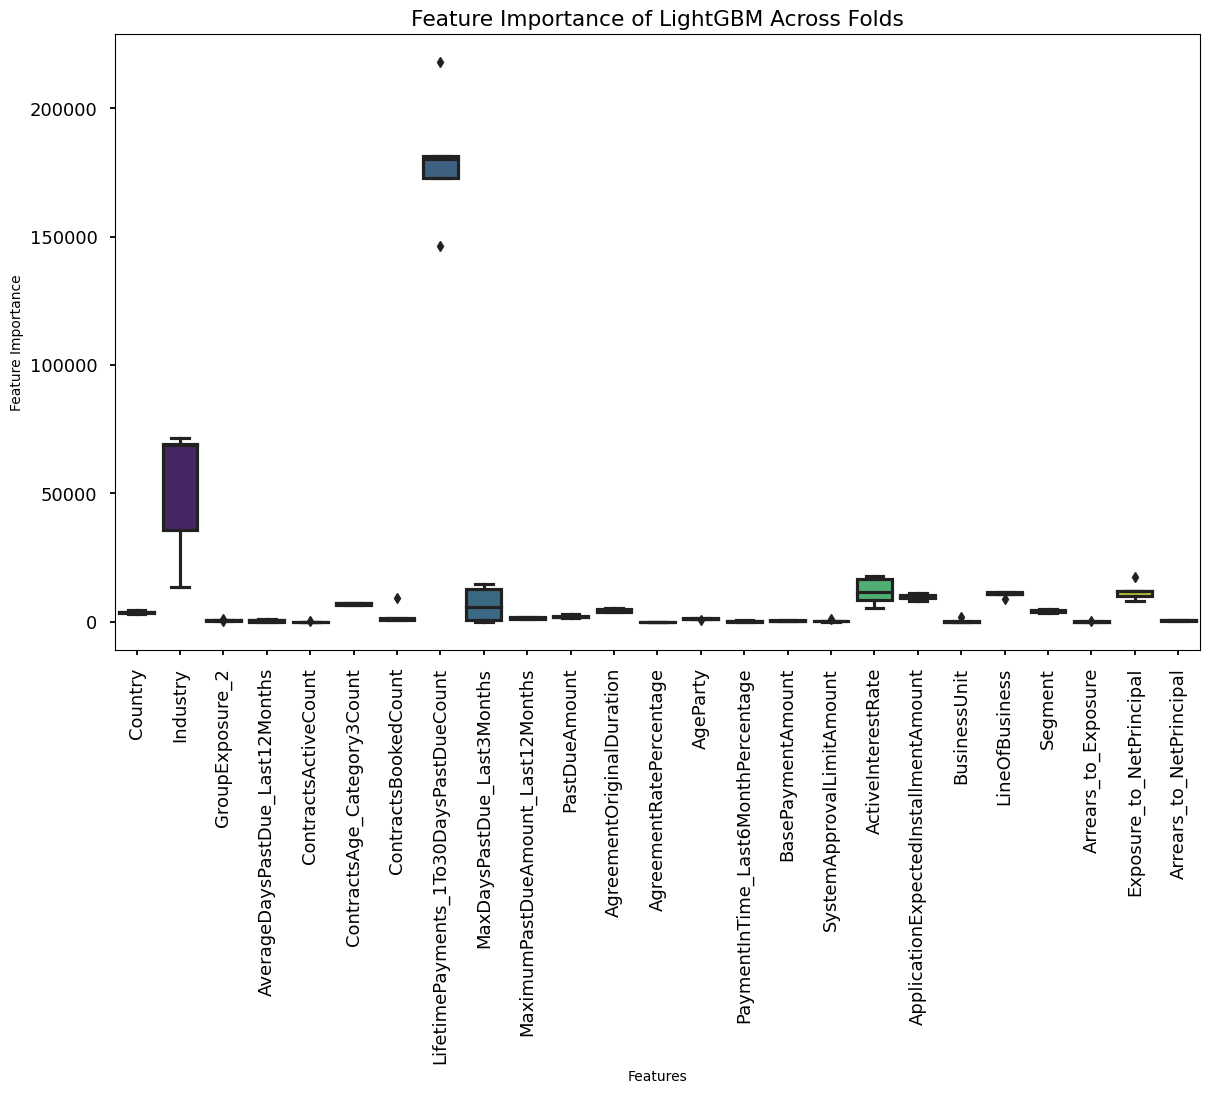

In [0]:
# Plot the box plot of feature importance across folds
plt.figure(figsize=(14, 8))
sns.boxplot(x='Feature', y='Importance', data=feature_importance_df, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importance of LightGBM Across Folds')
# Save the plot
plt.savefig("feature_importance_best_model_cv_boxplot.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

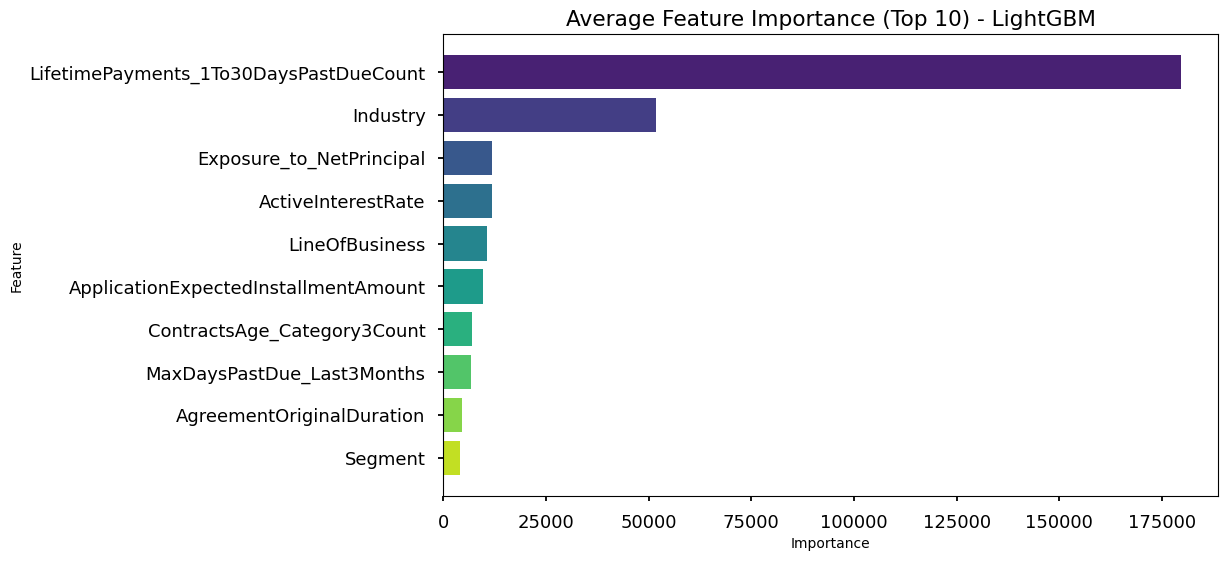

In [0]:
# Set color palette
colors = sns.color_palette("viridis", len(average_importances[:10]))

# Plot feature importance with colors
plt.figure(figsize=(10, 6))
plt.barh(average_importances['Feature'][:10], average_importances['Importance'][:10], color=colors)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Average Feature Importance (Top 10) - LightGBM")
plt.gca().invert_yaxis()
# Save the plot
plt.savefig("feature_importance_best_model_cv_av_barplot.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

In [0]:
average_importances.to_csv('feature_importance_lgbm_best_model_cv_av.csv', index=False)
feature_importance_df.to_csv('feature_importance_lgbm_best_model_cv_all.csv', index=False)

In [0]:
# Correlation between MaximumPastDueAmount_Last12Months, AverageDaysPastDue_Last12Months and target feature
best_two_features_target = ['MaximumPastDueAmount_Last12Months', 'AverageDaysPastDue_Last12Months', target_column]
train_modelling_df[best_two_features_target].corr()

MaximumPastDueAmount_Last12Months  ...   Default
MaximumPastDueAmount_Last12Months                           1.000000  ...  0.039913
AverageDaysPastDue_Last12Months                             0.077422  ...  0.211113
Default                                                     0.039913  ...  1.000000

[3 rows x 3 columns]

###### LightGBM on test

In [0]:
# Use the classifier within the pipeline to predict probabilities on the transformed test set
y_pred_prob = lgbm_pipe.named_steps['classifier'].predict_proba(X_test_transformed)[:, 1]

# Apply the 0.5 threshold to convert probabilities to binary predictions
threshold = 0.5
y_pred = (y_pred_prob >= threshold).astype(int)

# Evaluate model performance on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_prob)

# Calculate precision-recall curve and area under PR curve (AUC-PR)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_prob)
auc_pr = auc(recall_curve, precision_curve)

# Display metrics
print("Test Set Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {auc_roc:.4f}")
print(f"AUC-PR: {auc_pr:.4f}")

# Print confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

Test Set Performance:
Accuracy: 0.8245
Precision: 0.1104
Recall: 0.7064
F1 Score: 0.1909
ROC AUC: 0.8399
AUC-PR: 0.3154

Confusion Matrix:
 [[124556  25863]
 [  1334   3209]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90    150419
           1       0.11      0.71      0.19      4543

    accuracy                           0.82    154962
   macro avg       0.55      0.77      0.55    154962
weighted avg       0.96      0.82      0.88    154962



In [0]:
test_lgbm = pd.DataFrame({
    'Pred_Label_LGBM': y_pred,
    'Pred_Prob_LGBM': y_pred_prob,
    'True_Label': y_test
})

In [0]:
test_lgbm.to_csv('test_lgbm.csv', index=False)

###### SHAP analysis

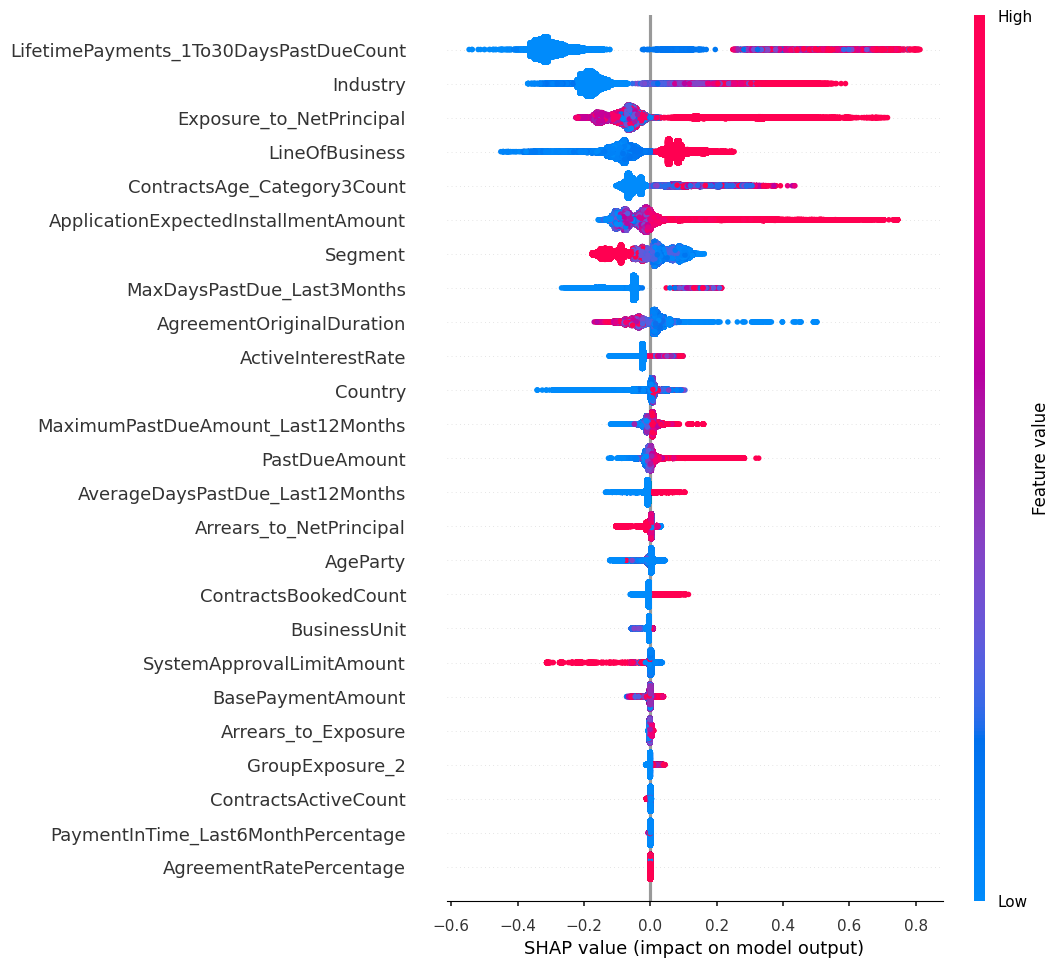

<Figure size 1040x715 with 0 Axes>

In [0]:
# Initialize the SHAP explainer using the LightGBM classifier from the pipeline
explainer = shap.TreeExplainer(lgbm_pipe.named_steps['classifier'])

# Calculate SHAP values for the transformed test set
explanation = explainer(X_test_transformed)

# Check the SHAP values for correctness (optional)
shap_values = explanation.values
np.abs(shap_values.sum(axis=1) + explanation.base_values - y_pred).max()

# Generate the beeswarm plot with all features displayed and feature names
shap.plots.beeswarm(explanation, max_display=len(feature_names))

plt.savefig("shap_beeswarm_lgbm.png", format="png", dpi=300, bbox_inches="tight")

## 8. Weighted Majority Voting

In [0]:
best_rf_params = {
    'max_depth': 10,
    'max_features': 'log2',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 400
}

best_xgb_params = {
    'learning_rate': 0.01,
    'n_estimators': 100,
    'max_depth': 3,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
}

best_lgbm_params = {
    'learning_rate': 0.01,
    'n_estimators': 100,
    'max_depth': 6,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
}

# Initialize base models with best parameters
rf = RandomForestClassifier(random_state=42, n_jobs=-1, **best_rf_params)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1, **best_xgb_params)
lgbm = LGBMClassifier(random_state=42, n_jobs=-1, **best_lgbm_params)

In [0]:
# Create pipelines for each base model
rf_pipe = Pipeline([('preprocessor', preprocessor), ('sampler', RandomUnderSampler(random_state=42)), ('classifier', rf)])
xgb_pipe = Pipeline([('preprocessor', preprocessor), ('sampler', RandomUnderSampler(random_state=42)), ('classifier', xgb)])
lgbm_pipe = Pipeline([('preprocessor', preprocessor), ('sampler', RandomUnderSampler(random_state=42)), ('classifier', lgbm)])

In [0]:
xgb_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['GroupExposure_2',
                                                   'AverageDaysPastDue_Last12Months',
                                                   'ContractsActiveCount',
                                                   'ContractsAge_Category3Count',
                                                   'ContractsBookedCount',
                                                   'LifetimePayments_1To30DaysPastDueCount',
                                                   'MaxDaysPastDue_Last3Months',
                                                   'MaximumPastDueAm...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

In [0]:
# Initialize weights
def initialize_weights(num_classifiers):
    return np.ones(num_classifiers)

# Update weights based on validation performance
def update_weights(classifier_predictions, y_val, weights):
    num_classifiers = len(weights)
    for i, preds in enumerate(classifier_predictions):
        correct = preds == y_val
        incorrect_count = (~correct).sum()
        weight_increment = incorrect_count / num_classifiers
        weights[i] += weight_increment * correct.sum() / len(correct)
    return weights

# Calculate weighted majority voting predictions
def weighted_majority_voting(classifier_predictions, weights):
    weighted_votes = np.zeros((len(classifier_predictions[0]), len(np.unique(classifier_predictions[0]))))
    for i, preds in enumerate(classifier_predictions):
        for j, pred in enumerate(preds):
            weighted_votes[j, pred] += weights[i]
    return np.argmax(weighted_votes, axis=1)

# Evaluation metrics
def evaluate_metrics(y_true, y_pred, y_proba=None):
    metrics = {
        'precision': precision_score(y_true, y_pred, average='binary'),
        'recall': recall_score(y_true, y_pred, average='binary'),
        'f1_score': f1_score(y_true, y_pred, average='binary'),
        'auc_pr': average_precision_score(y_true, y_proba) if y_proba is not None else None
    }
    return metrics

def weighted_majority_voting_with_proba(classifier_probabilities, weights):
    num_samples = len(classifier_probabilities[0])
    num_classes = classifier_probabilities[0].shape[1]
    
    # Initialize weighted probabilities matrix
    weighted_probas = np.zeros((num_samples, num_classes))
    
    # Combine probabilities with weights
    for i, probs in enumerate(classifier_probabilities):
        weighted_probas += probs * weights[i]
    
    # Normalize probabilities to ensure they sum to 1 for each sample
    y_pred_proba = weighted_probas / weighted_probas.sum(axis=1, keepdims=True)
    
    # Get class predictions
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    return y_pred, y_pred_proba

# Main function for WMVE with rolling window
def wmve_rolling_window_with_probs(folds, classifiers, target_column):
    num_classifiers = len(classifiers)
    overall_metrics = defaultdict(list)
    weight_history = []
    fold_predictions = []
    probs_per_fold = {'RandomForest': [], 'XGBoost': [], 'LightGBM': []}

    for fold_idx, (X_train, X_val, y_train, y_val) in enumerate(folds):
        print(f"Processing Fold {fold_idx + 1}...")
        
        # Train each classifier and collect probabilities
        classifier_probabilities = []
        for clf_idx, clf in enumerate(classifiers):
            clf.fit(X_train, y_train)
            probas = clf.predict_proba(X_val)
            classifier_probabilities.append(probas)

            # Store probabilities for each classifier
            if clf_idx == 0:
                probs_per_fold['RandomForest'].extend(probas[:, 1])
            elif clf_idx == 1:
                probs_per_fold['XGBoost'].extend(probas[:, 1])
            elif clf_idx == 2:
                probs_per_fold['LightGBM'].extend(probas[:, 1])

        # Initialize weights
        weights = initialize_weights(num_classifiers)

        # Update weights based on validation set
        classifier_predictions = [np.argmax(probas, axis=1) for probas in classifier_probabilities]
        weights = update_weights(classifier_predictions, y_val, weights)
        weight_history.append(weights)

        # Weighted majority voting with probabilities
        y_pred, y_pred_proba = weighted_majority_voting_with_proba(classifier_probabilities, weights)

        # Evaluate metrics
        metrics = evaluate_metrics(y_val, y_pred, y_pred_proba[:, 1])
        for metric_name, metric_value in metrics.items():
            overall_metrics[metric_name].append(metric_value)
        
        # Store predictions
        fold_predictions.append((y_pred, y_pred_proba))
    
    # Average metrics over folds
    avg_metrics = {metric: np.mean(values) for metric, values in overall_metrics.items()}
    print("Average Metrics:", avg_metrics)

    # Determine the best weight combination
    best_weight_idx = np.argmax(overall_metrics['f1_score'])
    best_weights = weight_history[best_weight_idx]
    print("Best Weight Combination:", best_weights)

    # Combine probabilities into a DataFrame
    probs_df = pd.DataFrame(probs_per_fold)

    return avg_metrics, weight_history, best_weights, fold_predictions, probs_df

In [0]:
classifiers = [rf_pipe, xgb_pipe, lgbm_pipe]
avg_metrics, weight_history, best_weights, fold_predictions, probs_df = wmve_rolling_window_with_probs(folds, classifiers, target_column)

Processing Fold 1...
[LightGBM] [Info] Number of positive: 8840, number of negative: 8840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 17680, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Processing Fold 2...
[LightGBM] [Info] Number of positive: 8600, number of negative: 8600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3583
[LightGBM] [Info] Number of data points in the train set: 17200, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Processing Fold 3...
[LightGBM] [Info] Number of positive: 8450, number of negative:

In [0]:
best_weights

array([4066.68682068, 4088.15322958, 4165.62738452])

In [0]:
# Initialize list to store metrics for each fold
results = []

# Loop through each fold for rolling-window cross-validation
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    print(f"Processing Fold {i + 1}...")
    
    # Train each base model
    rf_pipe.fit(X_train, y_train)
    xgb_pipe.fit(X_train, y_train)
    lgbm_pipe.fit(X_train, y_train)
    
    # Get probabilities for each classifier
    rf_prob = rf_pipe.predict_proba(X_val)[:, 1]
    xgb_prob = xgb_pipe.predict_proba(X_val)[:, 1]
    lgbm_prob = lgbm_pipe.predict_proba(X_val)[:, 1]
    
    # Combine probabilities using the best weights
    weighted_prob = (
        best_weights[0] * rf_prob +
        best_weights[1] * xgb_prob +
        best_weights[2] * lgbm_prob
    )
    weighted_prob /= np.sum(best_weights)  # Normalize weights
    
    # Predict the class based on the highest weighted probability
    majority_vote_pred = (weighted_prob >= 0.5).astype(int)
    
    # Evaluate performance of weighted majority voting
    accuracy = accuracy_score(y_val, majority_vote_pred)
    precision = precision_score(y_val, majority_vote_pred)
    recall = recall_score(y_val, majority_vote_pred)
    f1 = f1_score(y_val, majority_vote_pred)
    auc_roc = roc_auc_score(y_val, weighted_prob)
    
    # Calculate AUC-PR using the weighted probabilities
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, weighted_prob)
    auc_pr = auc(recall_curve, precision_curve)
    
    # Confusion matrix and classification report
    cm = confusion_matrix(y_val, majority_vote_pred)
    report = classification_report(y_val, majority_vote_pred)
    
    # Store fold results
    results.append({
        'fold': i+1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': auc_roc,
        'auc_pr': auc_pr
    })
    
    # Print confusion matrix and classification report for each fold
    print(f"\nFold {i + 1} Results:")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)

# Convert results into a DataFrame for better display
results_df = pd.DataFrame(results)
results_df.loc['mean'] = results_df.mean()

# Display the table with fold-wise metrics and the final mean
print("\nCross-Validation Results (Fold-wise and Mean):")
results_df

Processing Fold 1...
[LightGBM] [Info] Number of positive: 8840, number of negative: 8840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 17680, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Fold 1 Results:
Confusion Matrix:
 [[86689 13239]
 [  863  1885]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.92     99928
           1       0.12      0.69      0.21      2748

    accuracy                           0.86    102676
   macro avg       0.56      0.78      0.57    102676
weighted avg       0.97      0.86      0.91    102676

Processing Fold 2...
[LightGBM] [Info] Number of positive: 8600, number of negative: 8600
[LightGBM] [Info] Auto-choosing co

fold  accuracy  precision    recall  f1_score   roc_auc    auc_pr
0      1.0  0.862655   0.124636  0.685953  0.210944  0.858706  0.288360
1      2.0  0.849752   0.118420  0.681422  0.201775  0.848706  0.276999
2      3.0  0.846966   0.118394  0.683813  0.201842  0.847440  0.293979
3      4.0  0.838112   0.113534  0.695307  0.195195  0.847752  0.302710
4      5.0  0.827491   0.107002  0.693849  0.185411  0.842486  0.296219
mean   3.0  0.844995   0.116397  0.688069  0.199034  0.849018  0.291653

In [0]:
results_df.to_csv("weighted_majority_voting_training.csv", index=False)

In [0]:
probs_df.head()

RandomForest   XGBoost  LightGBM
0      0.332657  0.405675  0.413916
1      0.349566  0.352115  0.400012
2      0.192519  0.324137  0.291946
3      0.404109  0.403670  0.462572
4      0.179413  0.289417  0.260710

In [0]:
# Plot the heatmap for prediction probabilities
corr_matrix = probs_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Prediction Probabilities")
plt.savefig("correlation_prediction_proba.png", dpi=300)
plt.show()

In [0]:
# Create scatter plots for each pair of model probabilities
plt.figure(figsize=(15, 5))

# RandomForest vs XGBoost
plt.subplot(1, 3, 1)
plt.scatter(probs_df['RandomForest'], probs_df['XGBoost'], alpha=0.5)
plt.xlabel("Random Forest Probabilities")
plt.ylabel("XGBoost Probabilities")
plt.title("Random Forest vs XGBoost")
plt.xlim(0, 1)
plt.ylim(0, 1)

# RandomForest vs LightGBM
plt.subplot(1, 3, 2)
plt.scatter(probs_df['RandomForest'], probs_df['LightGBM'], alpha=0.5)
plt.xlabel("Random Forest Probabilities")
plt.ylabel("LightGBM Probabilities")
plt.title("Random Forest vs LightGBM")
plt.xlim(0, 1)
plt.ylim(0, 1)

# XGBoost vs LightGBM
plt.subplot(1, 3, 3)
plt.scatter(probs_df['XGBoost'], probs_df['LightGBM'], alpha=0.5)
plt.xlabel("XGBoost Probabilities")
plt.ylabel("LightGBM Probabilities")
plt.title("XGBoost vs LightGBM")
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig("scatter_prediction_proba.png", dpi=300)
plt.show()

In [0]:
# Define the VotingClassifier with hard voting (majority voting)

voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lgbm', lgbm)],
    voting='soft',
    weights=best_weights
)

# Create a pipeline with preprocessing and the voting classifier
voting_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', voting_clf)
])

In [0]:
voting_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['GroupExposure_2',
                                                   'AverageDaysPastDue_Last12Months',
                                                   'ContractsActiveCount',
                                                   'ContractsAge_Category3Count',
                                                   'ContractsBookedCount',
                                                   'LifetimePayments_1To30DaysPastDueCount',
                                                   'MaxDaysPastDue_Last3Months',
                                                   'MaximumPastDueAm...
                                                             max_delta_step=None,
                                                             max_depth=3,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=-1,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...)),
                                              ('lgbm',
                                               LGBMClassifier(learning_rate=0.01,
                                                              max_depth=6,
                                                              n_jobs=-1,
                                                              random_state=42))],
                                  voting='soft',
                                  weights=array([4066.68682068, 4088.15322958, 4165.62738452])))])

In [0]:
# Train the model on the entire training set (ensure X_train is a DataFrame)
X_train = train_modelling_df.drop(columns=target_column)
y_train = train_modelling_df[target_column]

voting_pipe.fit(X_train, y_train)

# Apply the pipeline's transformations to the test set without re-fitting
X_test = test_final_df.drop(columns=target_column)
y_test = test_final_df[target_column]

# Ensure X_test is a Pandas DataFrame
if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=test_final_df.drop(columns=target_column).columns)

# Transform and predict on the test set
X_test_transformed = voting_pipe.named_steps['preprocessor'].transform(X_test)  # Preprocessing only

# Get predictions and probabilities from the voting classifier on the transformed test set
y_pred = voting_pipe.named_steps['classifier'].predict(X_test_transformed)
y_pred_proba = voting_pipe.named_steps['classifier'].predict_proba(X_test_transformed)[:, 1]  # Positive class

# Evaluate model performance on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

# Calculate precision-recall curve and area under PR curve (AUC-PR)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
auc_pr = auc(recall_curve, precision_curve)

# Display metrics
print("Weighted Majority Voting Test Set Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {auc_roc:.4f}")
print(f"AUC-PR: {auc_pr:.4f}")

# Print confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

[LightGBM] [Info] Number of positive: 17398, number of negative: 17398
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3652
[LightGBM] [Info] Number of data points in the train set: 34796, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Weighted Majority Voting Test Set Performance:
Accuracy: 0.8531
Precision: 0.1261
Recall: 0.6769
F1 Score: 0.2126
ROC AUC: 0.8424
AUC-PR: 0.3008

Confusion Matrix:
 [[129116  21303]
 [  1468   3075]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92    150419
           1       0.13      0.68      0.21      4543

    accuracy                           0.85    154962
   macro avg       0.56      0.77      0.57    154962


## 9. Macro Analysis

In [0]:
# 70:
lr_70 = pd.read_csv("training_performance_70_lr.csv")
rf_70 = pd.read_csv("training_performance_70_rf.csv")
xgb_70 = pd.read_csv("training_performance_70_xgb.csv")
lgbm_70 = pd.read_csv("training_performance_70_lgbm.csv")

In [0]:
# 25:
lr_25 = pd.read_csv("training_performance_25_lr.csv")
rf_25 = pd.read_csv("training_performance_25_rf.csv")
xgb_25 = pd.read_csv("training_performance_25_xgb.csv")
lgbm_25 = pd.read_csv("training_performance_25_lgbm.csv")

In [0]:
# Define the list of dataframes and corresponding labels
dataframes = {
    "Logistic Regression": {"before": lr_70, "after": lr_25},
    "Random Forest": {"before": rf_70, "after": rf_25},
    "XGBoost": {"before": xgb_70, "after": xgb_25},
    "LightGBM": {"before": lgbm_70, "after": lgbm_25}
}

In [0]:
dataframes

{'Logistic Regression': {'before':    fold  accuracy  precision    recall  f1_score   roc_auc    auc_pr
  0   1.0  0.889867   0.144282  0.631732  0.234912  0.837839  0.209249
  1   2.0  0.884934   0.142664  0.624608  0.232275  0.829928  0.206814
  2   3.0  0.855806   0.122081  0.661523  0.206123  0.835579  0.213485
  3   4.0  0.856955   0.124713  0.675638  0.210560  0.835048  0.225035
  4   5.0  0.831265   0.107841  0.682446  0.186250  0.828450  0.224812
  5   3.0  0.863766   0.128316  0.655189  0.214024  0.833369  0.215879,
  'after':    fold  accuracy  precision    recall  f1_score   roc_auc    auc_pr
  0   1.0  0.895068   0.147116  0.608806  0.236969  0.827649  0.207599
  1   2.0  0.881146   0.135610  0.607529  0.221728  0.819718  0.203074
  2   3.0  0.880717   0.137544  0.610082  0.224479  0.825917  0.211047
  3   4.0  0.871657   0.132274  0.637681  0.219100  0.825241  0.213486
  4   5.0  0.856432   0.119726  0.641327  0.201783  0.818548  0.219845
  5   3.0  0.877004   0.134454  0.

In [0]:
# Initialize an empty list to store the results
results = []

# Loop through each model and corresponding dataframe
for model, dfs in dataframes.items():
    for stage, df in dfs.items():
        # Extract the last row (mean values of cross-validation) and format the results
        last_row = df.iloc[-1]
        results.append({
            "Model": model,
            "Data Set": "Before" if stage == "before" else "After",
            "AUC-PR": last_row['auc_pr'],
            "F1-Score": last_row['f1_score'],
            "Recall": last_row['recall'],
            "Precision": last_row['precision'],
            "Accuracy": last_row['accuracy']
        })

# Create the summary dataframe
summary_df = pd.DataFrame(results)

summary_df

Model Data Set    AUC-PR  ...    Recall  Precision  Accuracy
0  Logistic Regression   Before  0.215879  ...  0.655189   0.128316  0.863766
1  Logistic Regression    After  0.211010  ...  0.621085   0.134454  0.877004
2        Random Forest   Before  0.275843  ...  0.708100   0.111582  0.834348
3        Random Forest    After  0.268897  ...  0.706123   0.106735  0.826736
4              XGBoost   Before  0.266007  ...  0.728816   0.100784  0.810291
5              XGBoost    After  0.263736  ...  0.711588   0.101696  0.816422
6             LightGBM   Before  0.291784  ...  0.722285   0.111073  0.830391
7             LightGBM    After  0.286805  ...  0.709707   0.112046  0.834723

[8 rows x 7 columns]

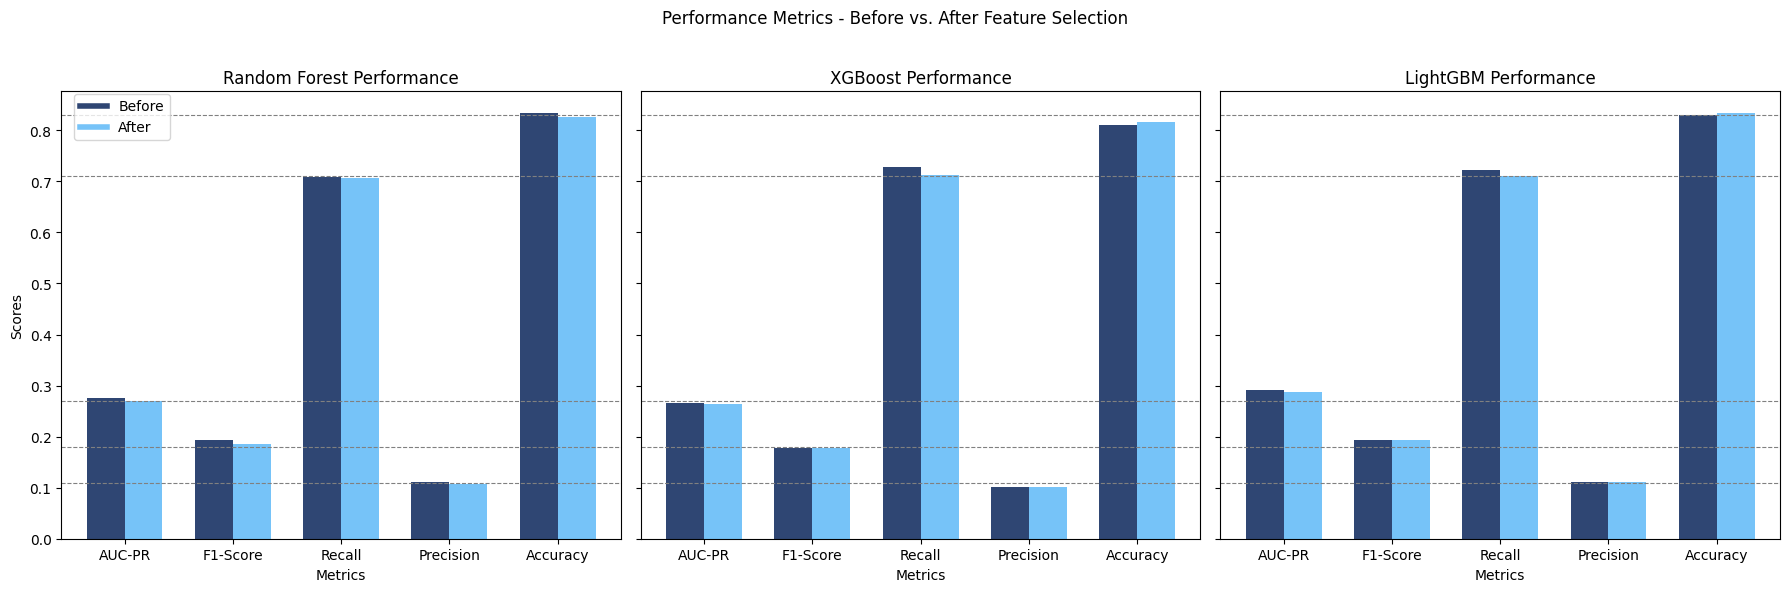

In [0]:
# Define models to plot and colors
models = ['Random Forest', 'XGBoost', 'LightGBM']
colors = ['#2F4673', '#76C3F8']  # Colors for 'Before' and 'After'

# Set up the metrics and positions for the bars
metrics = ['AUC-PR', 'F1-Score', 'Recall', 'Precision', 'Accuracy']
x = np.arange(len(metrics))  # Label locations
width = 0.35  # Width of the bars

# Define y-values for the horizontal dashed lines
horizontal_lines = [0.11, 0.18, 0.27, 0.71, 0.83]

# Create the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Performance Metrics - Before vs. After Feature Selection')

# Loop over each model to create a subplot
for i, model in enumerate(models):
    # Filter summary_df for the specific model data
    model_data = summary_df[summary_df['Model'] == model]

    # Extract values before and after feature selection
    before_values = model_data[model_data['Data Set'] == 'Before'][metrics].values.flatten()
    after_values = model_data[model_data['Data Set'] == 'After'][metrics].values.flatten()

    # Plot bars for "Before" and "After" feature selection
    axes[i].bar(x - width/2, before_values, width, label='Before', color=colors[0])
    axes[i].bar(x + width/2, after_values, width, label='After', color=colors[1])

    # Add horizontal dashed lines
    for y_value in horizontal_lines:
        axes[i].axhline(y=y_value, color='gray', linestyle='--', linewidth=0.8)

    # Set labels and title for each subplot
    axes[i].set_xlabel('Metrics')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(metrics)
    axes[i].set_title(f'{model} Performance')

# Set common y-axis label
axes[0].set_ylabel('Scores')

# Add a single legend for the colors of the bars
fig.legend(
    handles=[
        plt.Line2D([0], [0], color=colors[0], lw=4, label='Before'),
        plt.Line2D([0], [0], color=colors[1], lw=4, label='After')
    ],
    loc='upper left', bbox_to_anchor=(0.04, 0.85)
)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('feature_selection_metrics.png')
plt.show()

## 10. Error Analysis - Micro Analysis

In [0]:
X = train_df.drop(columns=[target_column])
categorical_features, numeric_features = split_features_by_type(X)

In [0]:
test_rf = pd.read_csv('test_rf.csv')
test_xgb = pd.read_csv('test_xgb.csv')
test_lgbm = pd.read_csv('test_lgbm.csv')

In [0]:
test_rf.head()

Pred_Label_RF  Pred_Prob_RF  True_Label
0              0      0.252263           0
1              0      0.338257           0
2              0      0.173469           0
3              0      0.164771           0
4              0      0.180948           0

In [0]:
test_rf = test_rf.reset_index(drop=True)
test_xgb = test_xgb.reset_index(drop=True)
test_lgbm = test_lgbm.reset_index(drop=True)
test_final_df = test_final_df.reset_index(drop=True)

X_test = test_final_df.drop(columns=target_column)
y_test = test_final_df[target_column]

# Concatenate the DataFrames along the columns
error_analysis_df = pd.concat([
    X_test, 
    test_rf[['Pred_Label_RF', 'Pred_Prob_RF']], 
    test_xgb[['Pred_Label_XGB', 'Pred_Prob_XGB']], 
    test_lgbm[['Pred_Label_LGBM', 'Pred_Prob_LGBM']],
    y_test
], axis=1)

In [0]:
error_analysis_df.shape

(154962, 32)

In [0]:
# Wrong prediction is marked as 1
error_analysis_df['Pred_Label_flag_RF'] = np.where(error_analysis_df['Pred_Label_RF'] == error_analysis_df[target_column], 0, 1)
error_analysis_df['Pred_Label_flag_XGB'] = np.where(error_analysis_df['Pred_Label_XGB'] == error_analysis_df[target_column], 0, 1)
error_analysis_df['Pred_Label_flag_LGBM'] = np.where(error_analysis_df['Pred_Label_LGBM'] == error_analysis_df[target_column], 0, 1)

# Prediction type
error_analysis_df['Pred_Type_RF'] = np.select(
    [
        (error_analysis_df['Pred_Label_RF'] == 1) & (error_analysis_df[target_column] == 1),  # True Positive
        (error_analysis_df['Pred_Label_RF'] == 0) & (error_analysis_df[target_column] == 1),  # False Negative
        (error_analysis_df['Pred_Label_RF'] == 1) & (error_analysis_df[target_column] == 0),  # False Positive
        (error_analysis_df['Pred_Label_RF'] == 0) & (error_analysis_df[target_column] == 0)   # True Negative
    ],
    ['TP', 'FN', 'FP', 'TN']
)

error_analysis_df['Pred_Type_XGB'] = np.select(
    [
        (error_analysis_df['Pred_Label_XGB'] == 1) & (error_analysis_df[target_column] == 1),  # True Positive
        (error_analysis_df['Pred_Label_XGB'] == 0) & (error_analysis_df[target_column] == 1),  # False Negative
        (error_analysis_df['Pred_Label_XGB'] == 1) & (error_analysis_df[target_column] == 0),  # False Positive
        (error_analysis_df['Pred_Label_XGB'] == 0) & (error_analysis_df[target_column] == 0)   # True Negative
    ],
    ['TP', 'FN', 'FP', 'TN']
)

error_analysis_df['Pred_Type_LGBM'] = np.select(
    [
        (error_analysis_df['Pred_Label_LGBM'] == 1) & (error_analysis_df[target_column] == 1),  # True Positive
        (error_analysis_df['Pred_Label_LGBM'] == 0) & (error_analysis_df[target_column] == 1),  # False Negative
        (error_analysis_df['Pred_Label_LGBM'] == 1) & (error_analysis_df[target_column] == 0),  # False Positive
        (error_analysis_df['Pred_Label_LGBM'] == 0) & (error_analysis_df[target_column] == 0)   # True Negative
    ],
    ['TP', 'FN', 'FP', 'TN']
)

In [0]:
error_analysis_df.shape

(154962, 38)

In [0]:
error_analysis_df.columns

Index(['Country', 'Industry', 'GroupExposure_2',
       'AverageDaysPastDue_Last12Months', 'ContractsActiveCount',
       'ContractsAge_Category3Count', 'ContractsBookedCount',
       'LifetimePayments_1To30DaysPastDueCount', 'MaxDaysPastDue_Last3Months',
       'MaximumPastDueAmount_Last12Months', 'PastDueAmount',
       'AgreementOriginalDuration', 'AgreementRatePercentage', 'AgeParty',
       'PaymentInTime_Last6MonthPercentage', 'BasePaymentAmount',
       'SystemApprovalLimitAmount', 'ActiveInterestRate',
       'ApplicationExpectedInstallmentAmount', 'BusinessUnit',
       'LineOfBusiness', 'Segment', 'Arrears_to_Exposure',
       'Exposure_to_NetPrincipal', 'Arrears_to_NetPrincipal', 'Pred_Label_RF',
       'Pred_Prob_RF', 'Pred_Label_XGB', 'Pred_Prob_XGB', 'Pred_Label_LGBM',
       'Pred_Prob_LGBM', 'Default', 'Pred_Label_flag_RF',
       'Pred_Label_flag_XGB', 'Pred_Label_flag_LGBM', 'Pred_Type_RF',
       'Pred_Type_XGB', 'Pred_Type_LGBM'],
      dtype='object')

#### 10.1 Confusion Matrix

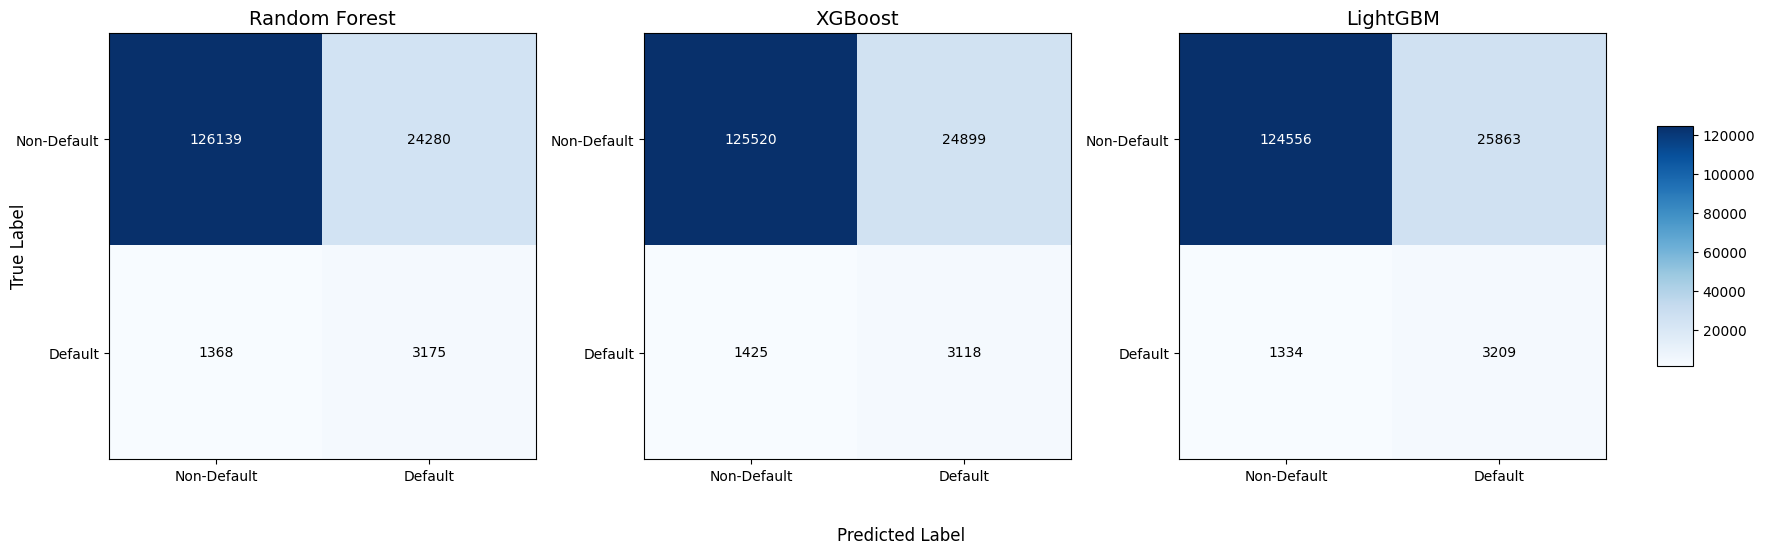

In [0]:
# Define the models and their corresponding predicted labels
models = {
    "Random Forest": "Pred_Label_RF",
    "XGBoost": "Pred_Label_XGB",
    "LightGBM": "Pred_Label_LGBM"
}

# True labels
y_true = error_analysis_df['Default']

# Create the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.ravel()

# Loop through each model and plot its confusion matrix
for i, (model_name, pred_col) in enumerate(models.items()):
    # Get predicted labels for the current model
    y_pred = error_analysis_df[pred_col]
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix manually
    im = axes[i].imshow(cm, interpolation='nearest', cmap='Blues')
    axes[i].set_title(f"{model_name}", fontsize=14)
    
    # Turn off gridlines
    axes[i].grid(False)  # Disable gridlines
    
    # Add labels and ticks
    classes = ['Non-Default', 'Default']  # 0 = Non-Default, 1 = Default
    axes[i].set_xticks(np.arange(len(classes)))
    axes[i].set_yticks(np.arange(len(classes)))
    axes[i].set_xticklabels(classes, fontsize=10)
    axes[i].set_yticklabels(classes, fontsize=10)
    
    # Add text annotations for each cell in the matrix
    thresh = cm.max() / 2.0
    for j, k in np.ndindex(cm.shape):
        axes[i].text(k, j, format(cm[j, k], 'd'),
                     ha="center", va="center",
                     fontsize=10,
                     color="white" if cm[j, k] > thresh else "black")

# Adjust positioning for "Predicted Label" and "True Label"
fig.text(0.5, 0.01, 'Predicted Label', ha='center', fontsize=12)
fig.text(0.01, 0.5, 'True Label', va='center', rotation='vertical', fontsize=12, ha='center')

# Add a single color bar in the middle on the right
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
fig.colorbar(im, cax=cbar_ax)

# Add a note to the plot for label meanings
# plt.figtext(0.95, 0.01, 'Note: 0 = Non-Default, 1 = Default', ha='right', fontsize=10, color='gray')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('confusion_matrix_all_3.png', dpi=300, bbox_inches='tight')
plt.show()

#### 10.2 AUC-PR

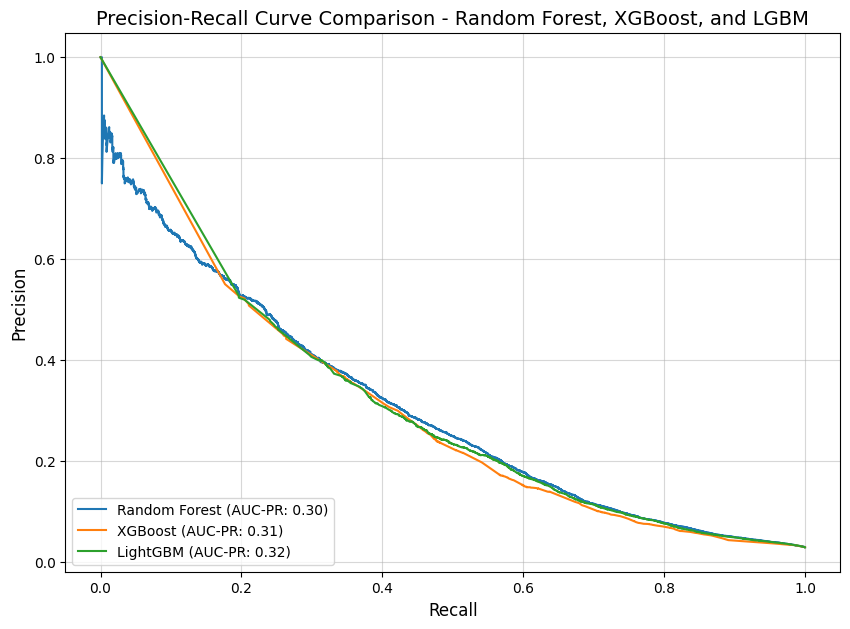

In [0]:
# Extract necessary columns
y_true = error_analysis_df['Default']
pred_probs = {
    'Random Forest': error_analysis_df['Pred_Prob_RF'],
    'XGBoost': error_analysis_df['Pred_Prob_XGB'],
    'LightGBM': error_analysis_df['Pred_Prob_LGBM']
}

plt.figure(figsize=(10, 7))

# Generate PR curves for each model
for model_name, y_pred_prob in pred_probs.items():
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{model_name} (AUC-PR: {pr_auc:.2f})')

# Plot settings
plt.title('Precision-Recall Curve Comparison - Random Forest, XGBoost, and LGBM', fontsize=14)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend(loc='lower left', fontsize=10)
plt.grid(alpha=0.5)
plt.savefig('precision_recall_curve_all_3.png', dpi=300, bbox_inches='tight')
plt.show()

#### 10.3 Numeric boxplot: FP, FN vs. TN&TP 

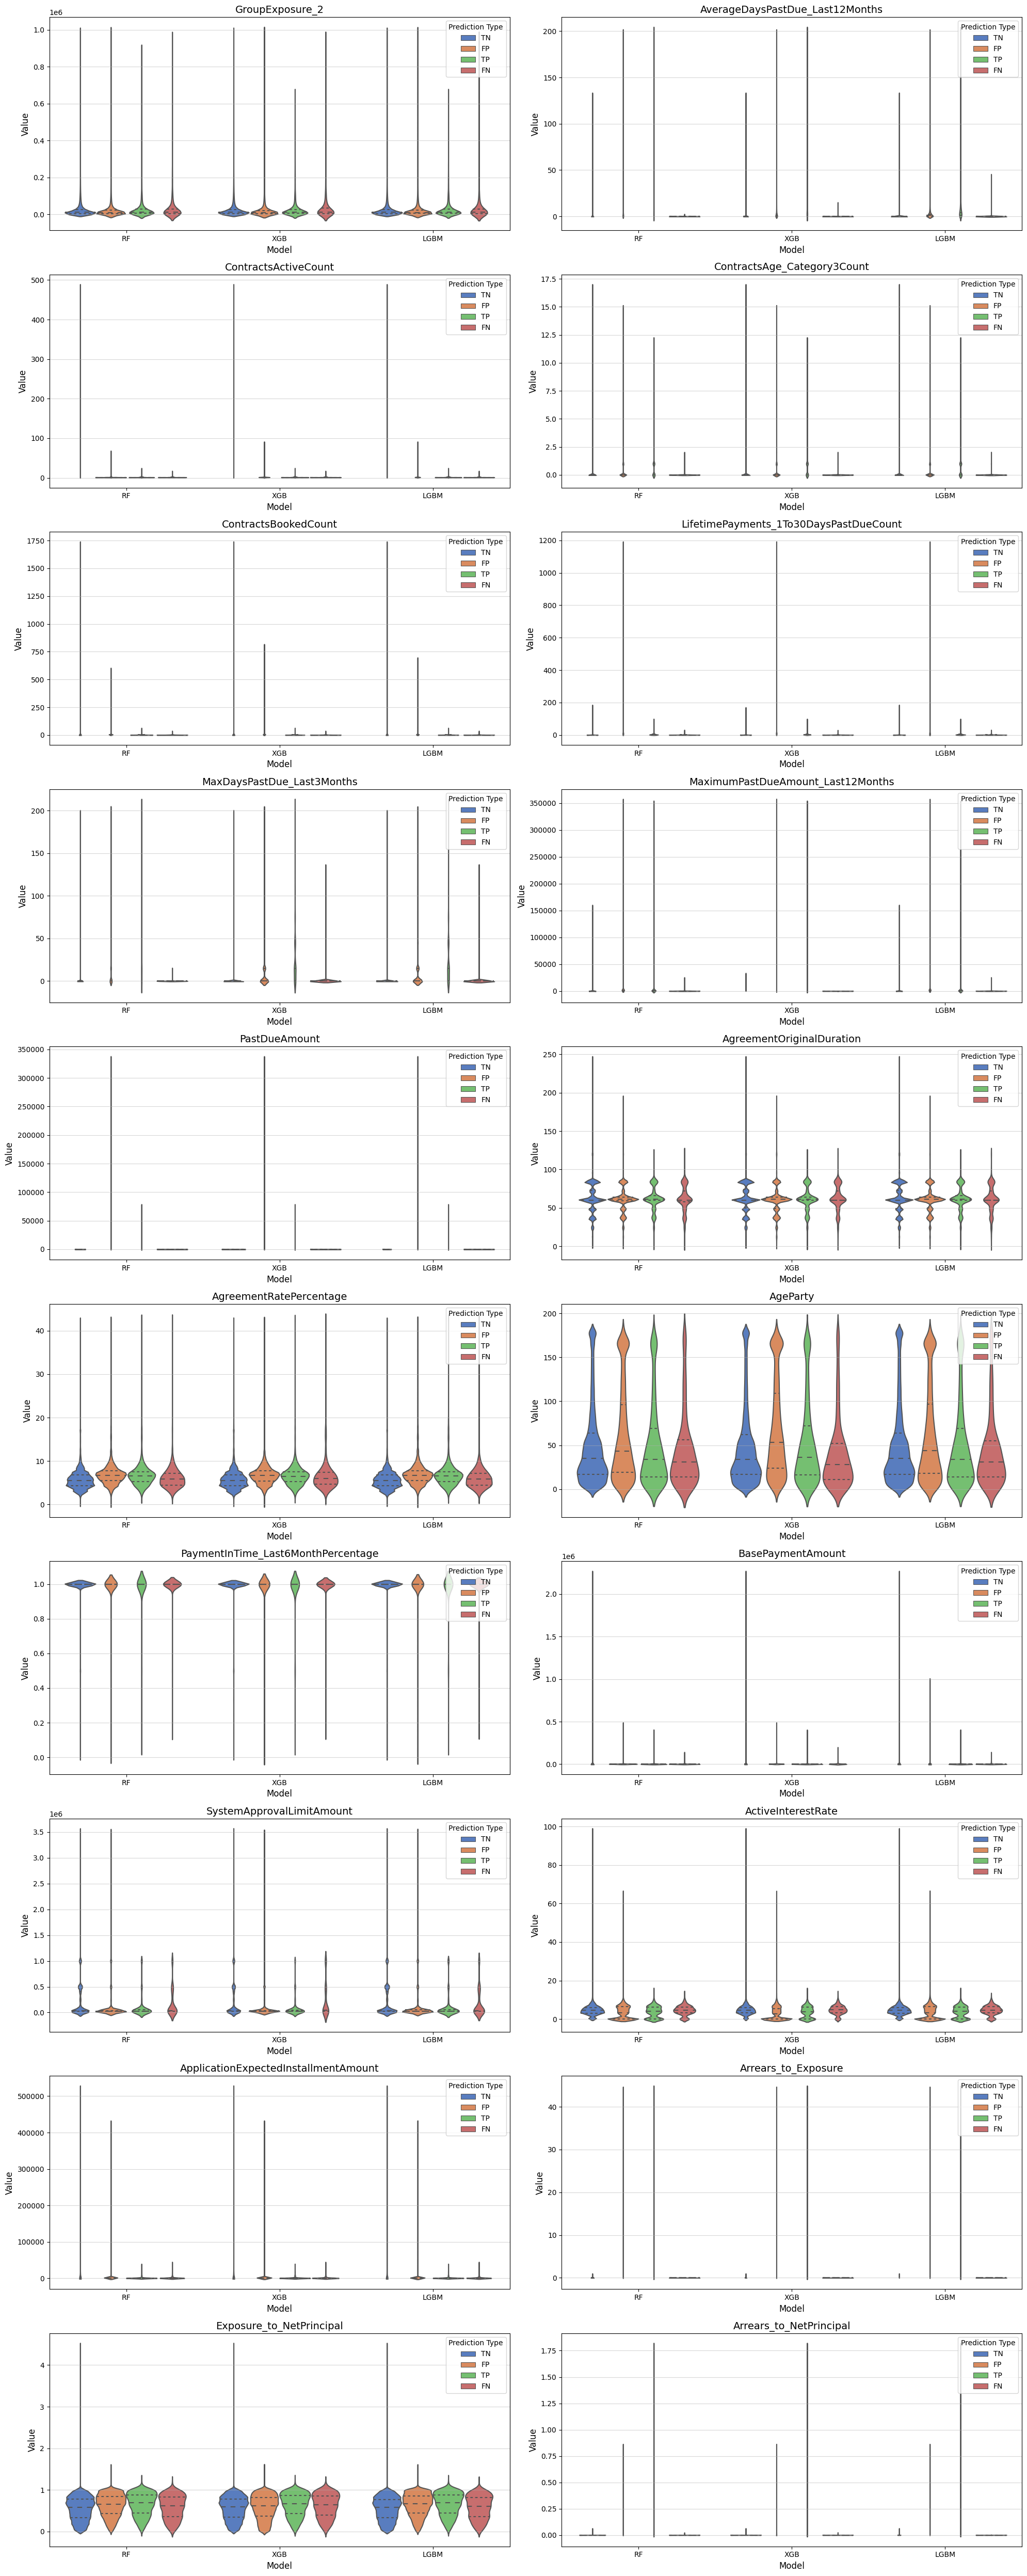

In [0]:
# Combine all models and prediction types into one DataFrame for plotting
combined_data = []
for model in ['Pred_Type_RF', 'Pred_Type_XGB', 'Pred_Type_LGBM']:
    temp_df = error_analysis_df[numeric_features + [model]].copy()
    temp_df['Model'] = model.split('_')[-1]  # Extract model name (RF, XGB, LGBM)
    temp_df.rename(columns={model: 'Pred_Type'}, inplace=True)
    combined_data.append(temp_df)

# Concatenate all models into a single DataFrame
combined_df = pd.concat(combined_data, ignore_index=True)

# Create subplots: 10 rows × 2 columns
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(20, 50))
axes = axes.flatten()  # Flatten to easily index the axes

# Plot each feature
for idx, feature in enumerate(numeric_features):
    sns.violinplot(
        data=combined_df,
        x='Model',
        y=feature,
        hue='Pred_Type',
        inner='quartile',  # Show quartiles inside the violins
        palette='muted',  # Set color palette
        ax=axes[idx]  # Use the appropriate subplot axis
    )
    axes[idx].set_title(f'{feature}', fontsize=14)
    axes[idx].set_xlabel('Model', fontsize=12)
    axes[idx].set_ylabel('Value', fontsize=12)
    axes[idx].legend(title='Prediction Type', fontsize=10, loc='upper right')
    axes[idx].grid(axis='y', alpha=0.5)

# Remove empty subplots (if any)
for idx in range(len(numeric_features), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.savefig('violin_plots_all_3.png', dpi=300, bbox_inches='tight')
plt.show()

#### 10.4 Categorical bar plot: default rate vs. predicted rate

In [0]:
categorical_features

['Country', 'Industry', 'BusinessUnit', 'LineOfBusiness', 'Segment']

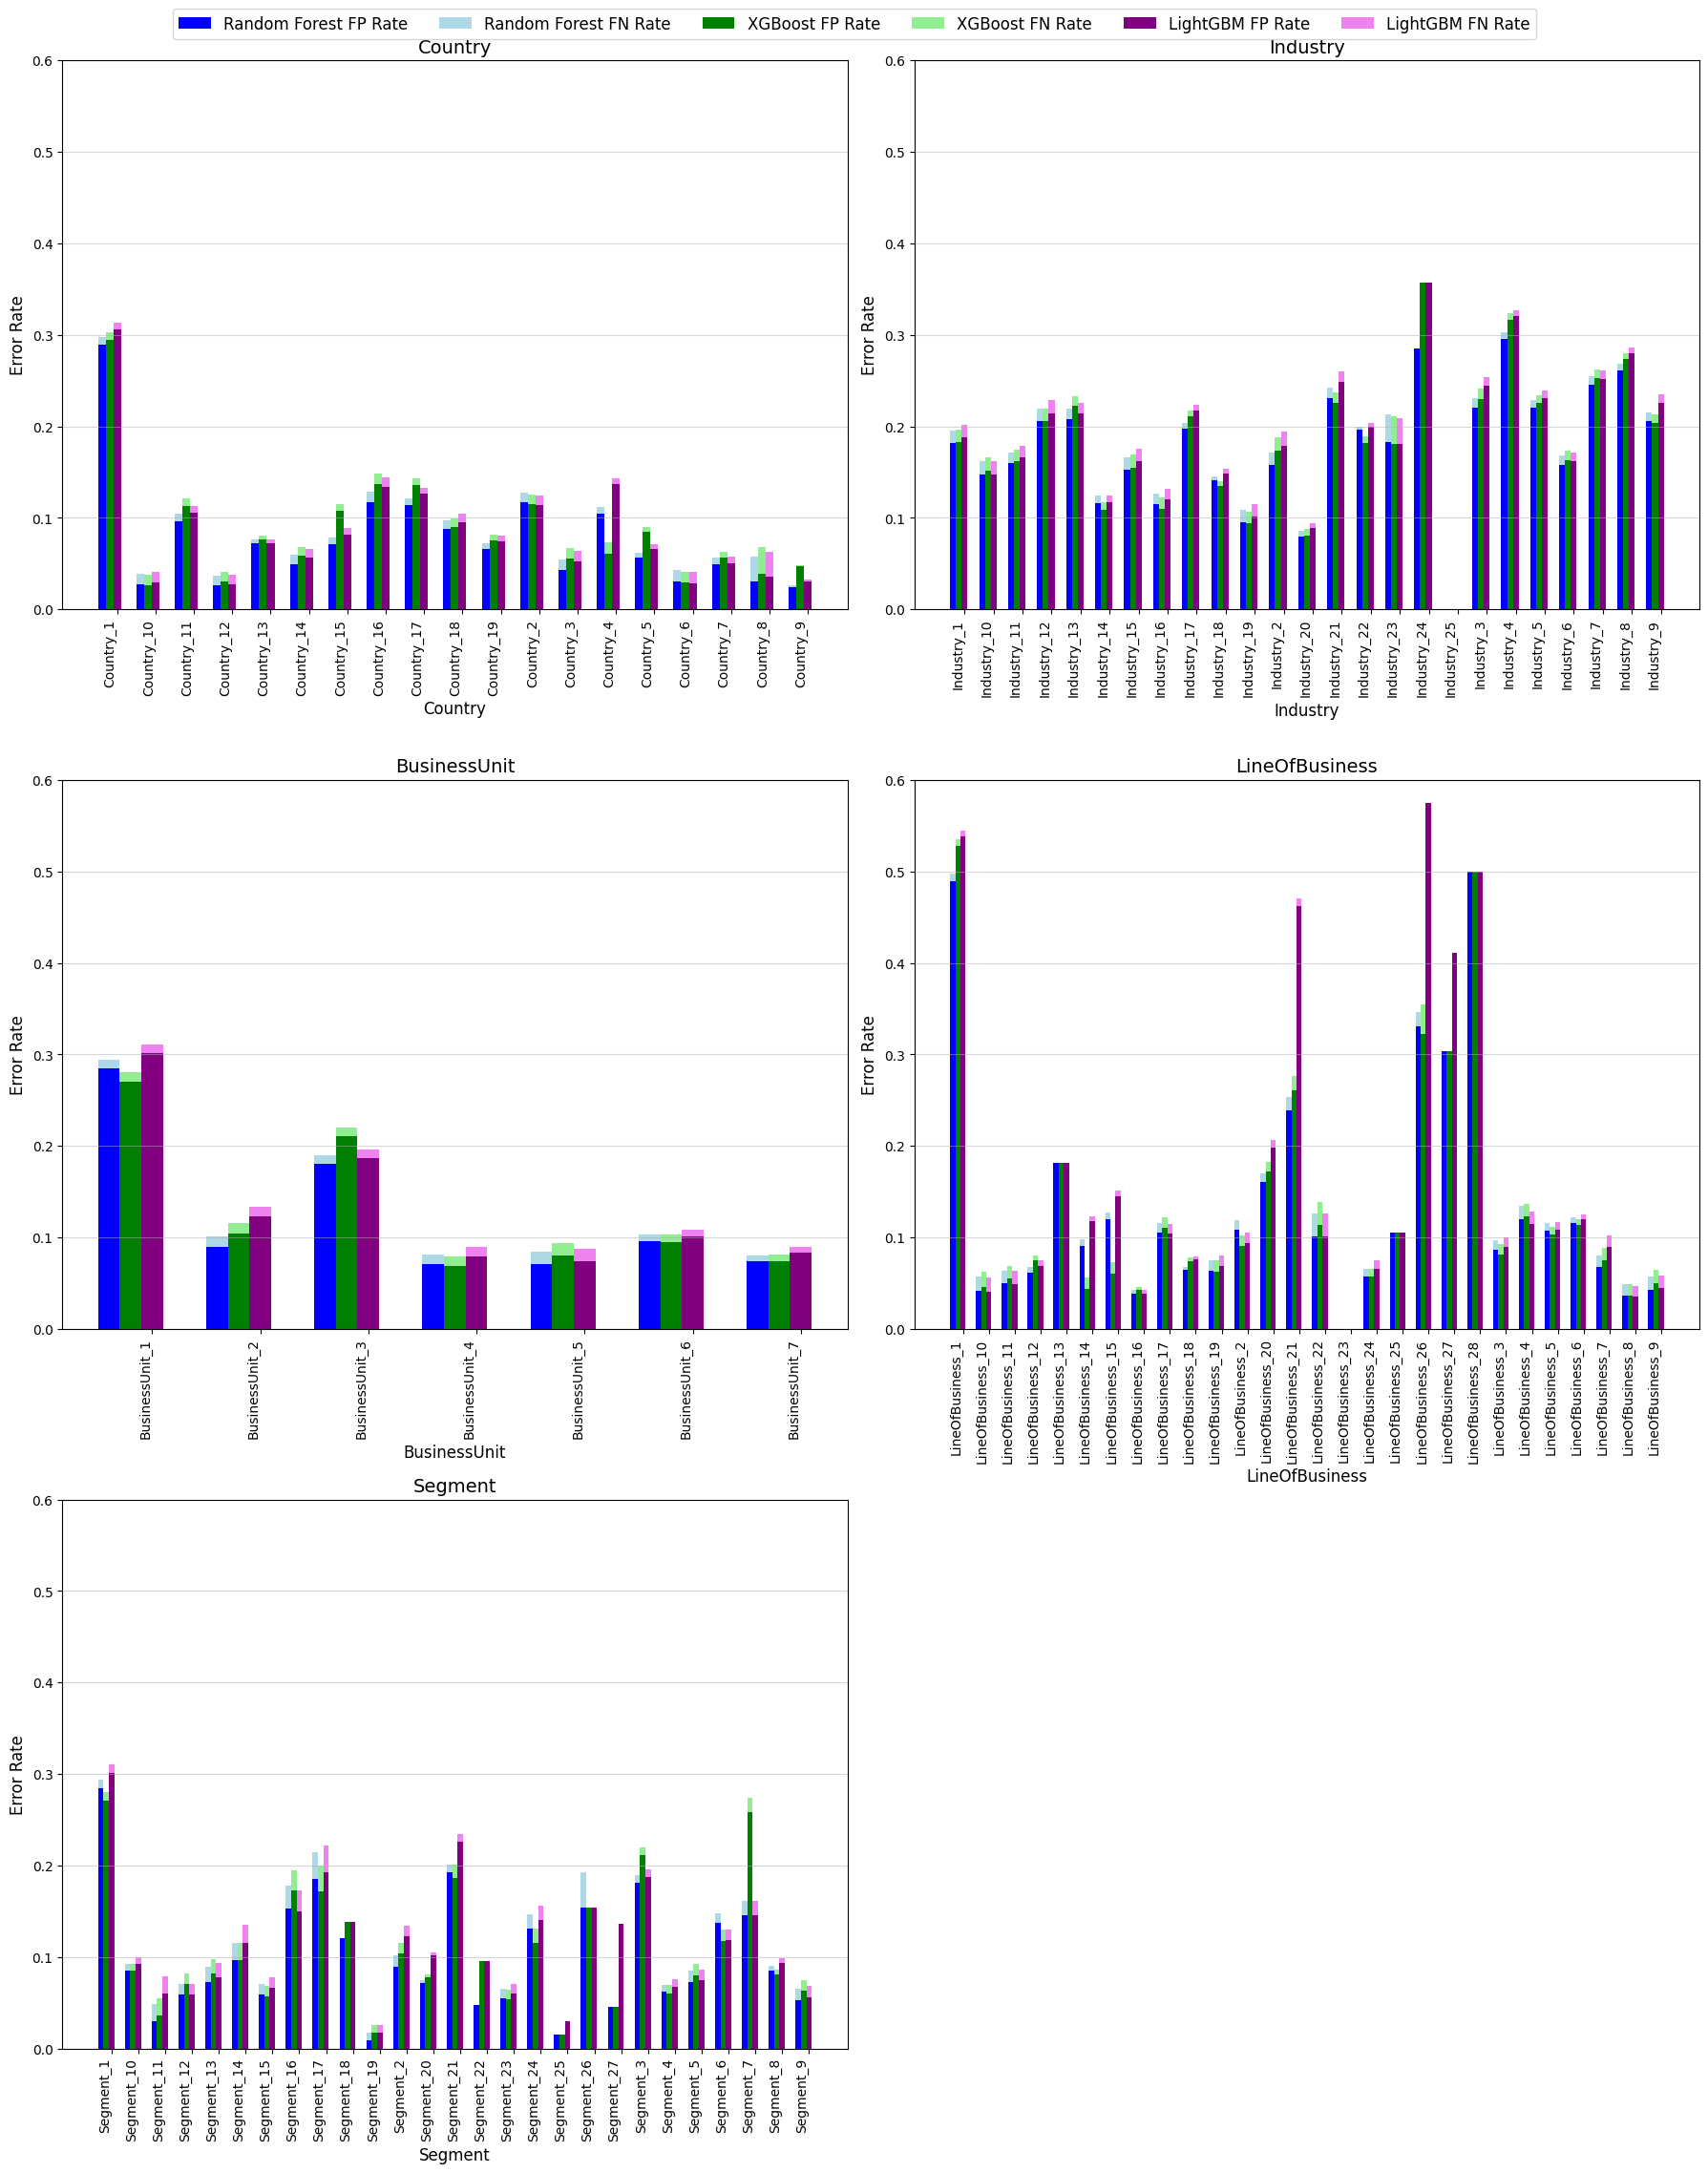

In [0]:
# List of models and their Pred_Type columns
models = {
    'Random Forest': 'Pred_Type_RF',
    'XGBoost': 'Pred_Type_XGB',
    'LightGBM': 'Pred_Type_LGBM'
}

# Define colors for each model
model_colors = {
    'Random Forest': ('blue', 'lightblue'),
    'XGBoost': ('green', 'lightgreen'),
    'LightGBM': ('purple', 'violet')
}

# Limit the number of plots to 5
categorical_features = categorical_features[:5]

# Create a figure with a 2x3 grid of subplots (leave bottom-right corner empty)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 24))
axes = axes.flatten()  # Flatten the grid to easily index the axes

# Loop through categorical features and plot on each subplot
for idx, feature in enumerate(categorical_features):
    # Initialize a DataFrame to store error rates
    error_rates = pd.DataFrame()

    # Calculate FP and FN rates for each model
    for model_name, pred_type_column in models.items():
        # False Positive Rate: Cases where Pred_Type == 'FP'
        fp_rate = error_analysis_df[error_analysis_df[pred_type_column] == 'FP'].groupby(feature).size() / error_analysis_df.groupby(feature).size()

        # False Negative Rate: Cases where Pred_Type == 'FN'
        fn_rate = error_analysis_df[error_analysis_df[pred_type_column] == 'FN'].groupby(feature).size() / error_analysis_df.groupby(feature).size()

        # Add to the error rates DataFrame
        error_rates[f'{model_name} FP Rate'] = fp_rate
        error_rates[f'{model_name} FN Rate'] = fn_rate

    # Reset the index for plotting
    error_rates.reset_index(inplace=True)

    # Plot FP and FN rates for the feature using a stacked bar plot
    ax = axes[idx]
    bar_width = 0.2  # Bar width for grouping
    x = np.arange(len(error_rates))  # X positions for categories

    for model_idx, model_name in enumerate(models.keys()):
        # Plot FP rates (bottom of the stacked bar) for each model
        ax.bar(
            x + model_idx * bar_width,
            error_rates[f'{model_name} FP Rate'],
            width=bar_width,
            label=f'{model_name} FP Rate' if idx == 0 else "",
            color=model_colors[model_name][0]
        )
        # Plot FN rates (top of the stacked bar) for each model
        ax.bar(
            x + model_idx * bar_width,
            error_rates[f'{model_name} FN Rate'],
            width=bar_width,
            bottom=error_rates[f'{model_name} FP Rate'],
            label=f'{model_name} FN Rate' if idx == 0 else "",
            color=model_colors[model_name][1]
        )

    # Plot settings for each subplot
    ax.set_title(f'{feature}', fontsize=14)
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Error Rate', fontsize=12)
    ax.set_xticks(x + bar_width * 2)
    ax.set_xticklabels(error_rates[feature], rotation=90, ha='right')
    ax.set_ylim(0, 0.6)
    ax.grid(axis='y', alpha=0.5)

# Remove the empty subplot (bottom-right corner)
for ax in axes[len(categorical_features):]:
    fig.delaxes(ax)

# Global legend and layout adjustments
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=6, fontsize=12, bbox_to_anchor=(0.5, 0.95))
plt.tight_layout(rect=[0, 0, 1, 0.94])  # Adjust layout to make space for the legend
plt.savefig('error_rates_categorical_features.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Survival ML models

In [0]:
train_modelling_df_surv = train_df.drop(columns=target_column)
test_modelling_df_surv = test_final_df.drop(columns=target_column)

In [0]:
# Reset index for train_modelling_df_surv
train_modelling_df_surv_reset = train_modelling_df_surv.reset_index()

# Ensure alignment by resetting index for both DataFrames
time_and_censoring_train_reset = time_and_censoring_train.reset_index(drop=True)

# Merge the DataFrames
train_modelling_df_surv = pd.concat([train_modelling_df_surv_reset, time_and_censoring_train_reset], axis=1)

# Set ReportingPeriod as the final index
train_modelling_df_surv.set_index('ReportingPeriod', inplace=True)

In [0]:
train_modelling_df_surv.shape

(617804, 27)

In [0]:
# Reset index for test_modelling_df_surv
test_modelling_df_surv_reset = test_modelling_df_surv.reset_index()

# Ensure alignment by resetting index for both DataFrames
time_and_censoring_test_reset = time_and_censoring_test.reset_index(drop=True)

# Merge the DataFrames
test_modelling_df_surv = pd.concat([test_modelling_df_surv_reset, time_and_censoring_test_reset], axis=1)

# Set ReportingPeriod as the final index
test_modelling_df_surv.set_index('ReportingPeriod', inplace=True)

In [0]:
test_modelling_df_surv.shape

(154962, 27)

In [0]:
time_column = 'Time_to_Event'
event_column = 'Censoring_Status'
# Ensure event column is boolean
train_modelling_df_surv[event_column] = train_modelling_df_surv[event_column].astype(bool)
X = train_modelling_df_surv.drop(columns=[time_column, event_column])
y = train_modelling_df_surv[[time_column, event_column]]

In [0]:
categorical_features, numeric_features = split_features_by_type(X)
print(len(categorical_features) + len(numeric_features))

25


In [0]:
numeric_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('frequency_encoder', CountEncoder(normalize=True))
])
    
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_preprocessor, numeric_features),
        ('cat', categorical_preprocessor, categorical_features)
    ]
)

In [0]:
def rolling_window_split_for_survival(df, time_column, event_column, window_size=6, validation_size=2):

    folds = []
    # Get unique months from the index (e.g., ReportingPeriod_AGR)
    unique_months = df.index.to_period('M').unique()

    # Iterate over the range of the rolling window
    for i in range(len(unique_months) - window_size - validation_size + 1):
        # Define training and validation periods
        train_periods = unique_months[i:i+window_size]  # Training periods
        val_period = unique_months[i+window_size:i+window_size+validation_size]  # Validation period
        
        # Get training and validation sets based on the periods
        train_mask = df.index.to_period('M').isin(train_periods)
        val_mask = df.index.to_period('M').isin(val_period)

        # Split X (features) and y (time and event columns)
        X_train = df[train_mask].drop(columns=[time_column, event_column])
        X_val = df[val_mask].drop(columns=[time_column, event_column])

        # For y, create structured arrays for survival analysis
        y_train = np.array(
            [(event, time) for event, time in zip(df[train_mask][event_column], df[train_mask][time_column])],
            dtype=[('event', '?'), ('time', '<f8')]
        )
        y_val = np.array(
            [(event, time) for event, time in zip(df[val_mask][event_column], df[val_mask][time_column])],
            dtype=[('event', '?'), ('time', '<f8')]
        )

        folds.append((X_train, X_val, y_train, y_val))

        # print(type(X_train))
        # print(type(X_val))
        # print(type(y_train[0]))
        # print(type(y_val[0]))
        
    return folds

In [0]:
folds = rolling_window_split_for_survival(train_modelling_df_surv, time_column, event_column)

In [0]:
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    
    # Get the unique dates (ReportingPeriod_AGR) from the training and validation sets
    train_dates = X_train.index.to_period('M').unique()
    val_dates = X_val.index.to_period('M').unique()

    print(f"Training set unique dates: {train_dates}")
    print(f"Number of unique training dates: {len(train_dates)}")
    
    print(f"Validation set unique dates: {val_dates}")
    print(f"Number of unique validation dates: {len(val_dates)}")
    
    print("\n")

Training set unique dates: PeriodIndex(['2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03'], dtype='period[M]', name='ReportingPeriod')
Number of unique training dates: 6
Validation set unique dates: PeriodIndex(['2022-04', '2022-05'], dtype='period[M]', name='ReportingPeriod')
Number of unique validation dates: 2


Training set unique dates: PeriodIndex(['2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04'], dtype='period[M]', name='ReportingPeriod')
Number of unique training dates: 6
Validation set unique dates: PeriodIndex(['2022-05', '2022-06'], dtype='period[M]', name='ReportingPeriod')
Number of unique validation dates: 2


Training set unique dates: PeriodIndex(['2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05'], dtype='period[M]', name='ReportingPeriod')
Number of unique training dates: 6
Validation set unique dates: PeriodIndex(['2022-06', '2022-07'], dtype='period[M]', name='ReportingPeriod')
Number of unique validation dates: 2


Trai

#### 11.1 rsf

In [0]:
# Define Random Survival Forest
rsf = RandomSurvivalForest(random_state=42, n_jobs=-1)

In [0]:
# Initialize list to hold metrics for each fold
results = []

# Loop through each fold
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    print(f"\nFold {i+1} - Training and Evaluation")
    
    # Preprocess X_train and X_val separately
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_val_preprocessed = preprocessor.transform(X_val)
    
    # Extract the 'event' column for undersampling
    y_train_event = y_train['event']
    
    # Apply random undersampling
    rus = RandomUnderSampler(random_state=42)
    X_train_resampled, y_train_event_resampled = rus.fit_resample(X_train_preprocessed, y_train_event)
    y_train_time_resampled = y_train['time'][rus.sample_indices_]
    y_train_resampled = np.array(
        [(event, time) for event, time in zip(y_train_event_resampled, y_train_time_resampled)],
        dtype=[('event', '?'), ('time', '<f8')]
    )

    # Train the Random Survival Forest on undersampled data
    rsf.fit(X_train_resampled, y_train_resampled)
    
    # Predict survival functions for the validation set
    surv = rsf.predict_survival_function(X_val_preprocessed, return_array=True)
    
    # Choose survival probabilities at the 12th month
    time_point = 12
    time_index = np.argmin(np.abs(rsf.unique_times_ - time_point))  # Closest index to 12 months
    survival_probabilities = surv[:, time_index]
    
    # Convert survival probabilities to binary classification using threshold 0.5
    y_pred = (survival_probabilities <= 0.5).astype(int)  # Default (1) if survival prob <= 0.5
    y_true = y_val['event'].astype(int)  # True labels
    
    # Predicted probabilities of default (1 - survival probability)
    y_pred_prob = 1 - survival_probabilities
    
    # Evaluate classification metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred_prob)
    
    # Precision-recall curve and AUC-PR
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_prob)
    auc_pr = auc(recall_curve, precision_curve)
    
    # Concordance index
    c_index = concordance_index_censored(
        y_val['event'], y_val['time'], y_pred_prob
    )[0]
    
    # Confusion matrix and classification report
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    
    print(f"\nFold {i+1} Results:")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)
    
    # Store results
    results.append({
        'fold': i + 1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': auc_roc,
        'auc_pr': auc_pr,
        'c_index': c_index
    })

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Add mean metrics as a new row
results_df.loc['mean'] = results_df.mean(numeric_only=True)

# Display results
print("\nCross-Validation Results (Fold-wise and Mean):")
results_df


Fold 1 - Training and Evaluation

Fold 1 Results:
Confusion Matrix:
 [[95253  3195]
 [ 2774  1454]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     98448
           1       0.31      0.34      0.33      4228

    accuracy                           0.94    102676
   macro avg       0.64      0.66      0.65    102676
weighted avg       0.94      0.94      0.94    102676


Fold 2 - Training and Evaluation

Fold 2 Results:
Confusion Matrix:
 [[94982  3851]
 [ 2602  1515]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97     98833
           1       0.28      0.37      0.32      4117

    accuracy                           0.94    102950
   macro avg       0.63      0.66      0.64    102950
weighted avg       0.95      0.94      0.94    102950


Fold 3 - Training and Evaluation

Fold 3 Results:
Confusion Matrix:
 [[94152  5002]
 [ 2257  16

fold  accuracy  precision  ...   roc_auc    auc_pr   c_index
0      1.0  0.941866   0.312755  ...  0.807765  0.257568  0.873992
1      2.0  0.937319   0.282333  ...  0.804565  0.250991  0.873284
2      3.0  0.929558   0.246687  ...  0.804602  0.256305  0.894288
3      4.0  0.904072   0.183174  ...  0.800258  0.255344  0.909460
4      5.0  0.857410   0.131852  ...  0.800899  0.248164  0.926632
mean   3.0  0.914045   0.231360  ...  0.803618  0.253675  0.895531

[6 rows x 8 columns]

In [0]:
results_df.to_csv('training_performance_25_rsf.csv', index=False)

Fold 1 - Survival Function


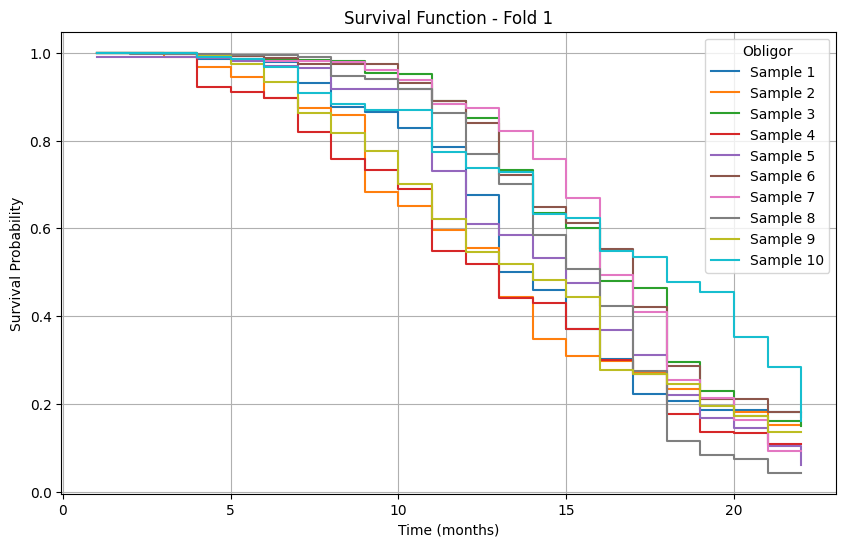

Fold 2 - Survival Function


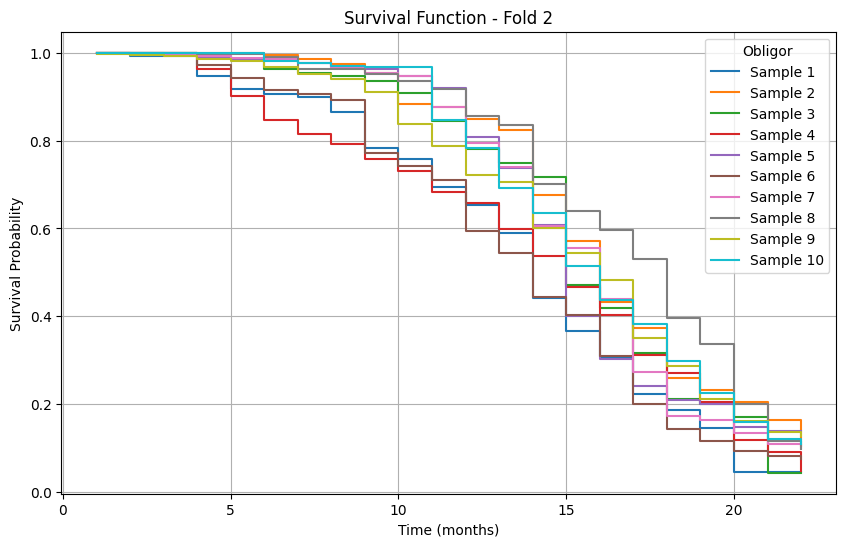

Fold 3 - Survival Function


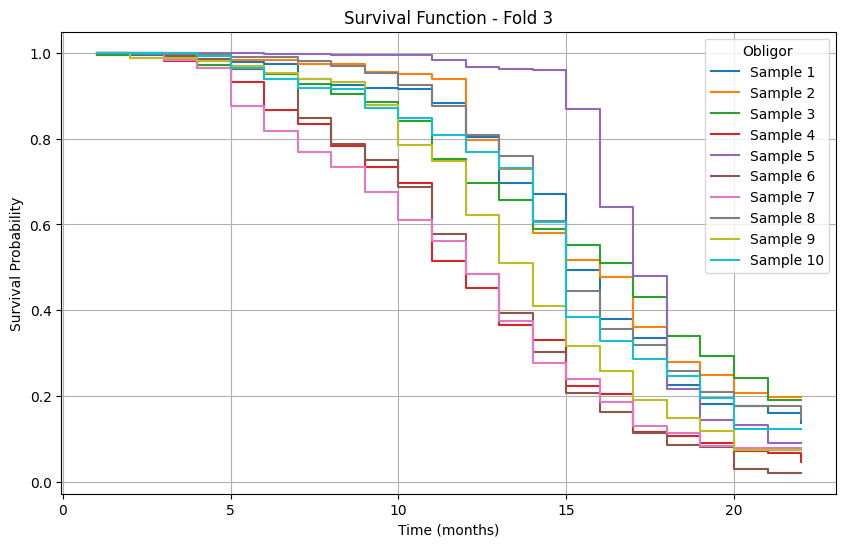

Fold 4 - Survival Function


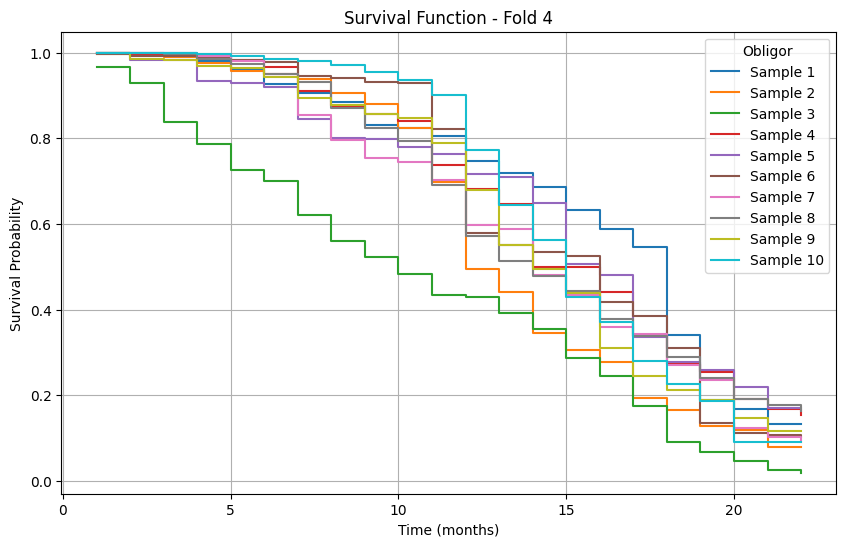

Fold 5 - Survival Function


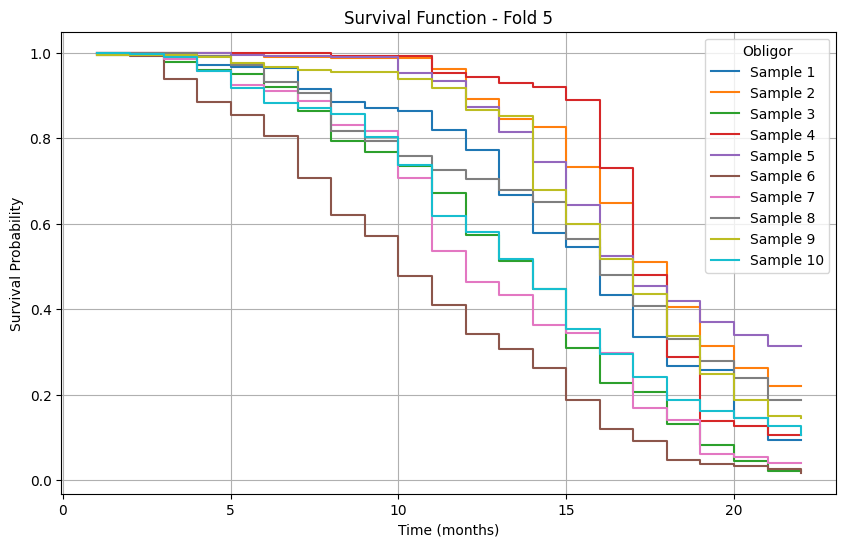

In [0]:
# Loop through each fold and plot survival functions
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    print(f"Fold {i + 1} - Survival Function")
    
    # Preprocess the validation set
    X_val_preprocessed = preprocessor.transform(X_val)
    
    # Predict survival function for the validation set
    surv = rsf.predict_survival_function(X_val_preprocessed, return_array=True)
    
    # Plot survival functions for a subset of samples to avoid cluttering
    plt.figure(figsize=(10, 6))
    for j, s in enumerate(surv[:10]):  # Limit to the first 10 samples for clarity
        plt.step(rsf.unique_times_, s, where="post", label=f"Sample {j + 1}")
    
    plt.ylabel("Survival Probability")
    plt.xlabel("Time (months)")
    plt.title(f"Survival Function - Fold {i + 1}")
    plt.legend(title="Obligor")
    plt.grid(True)
    plt.show()

Fold 1 - Cumulative Hazard Function


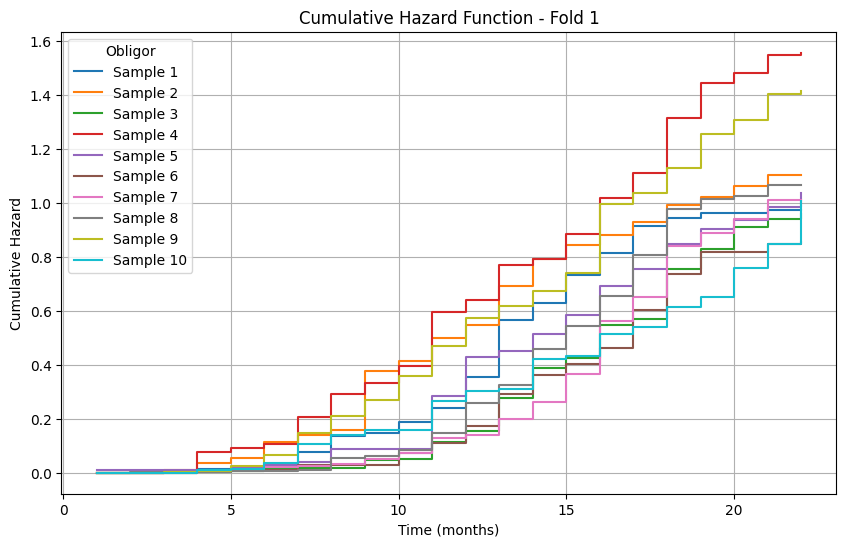

Fold 2 - Cumulative Hazard Function


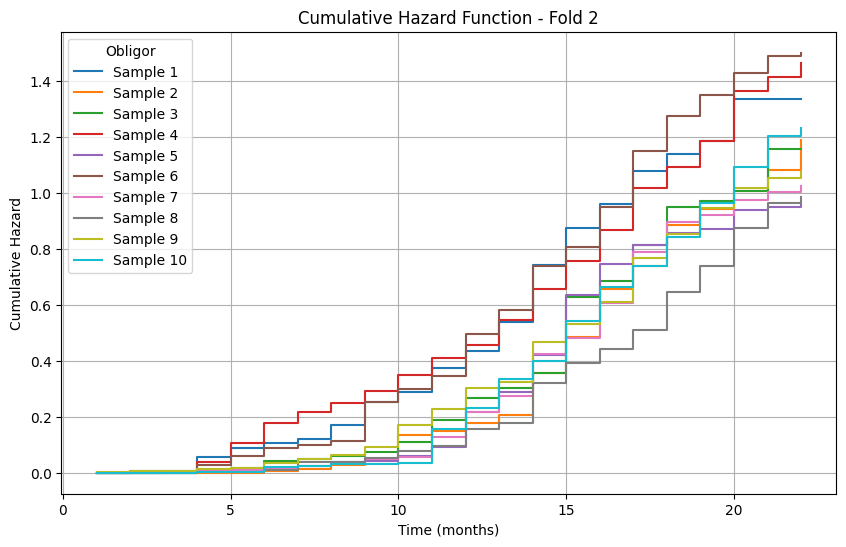

Fold 3 - Cumulative Hazard Function


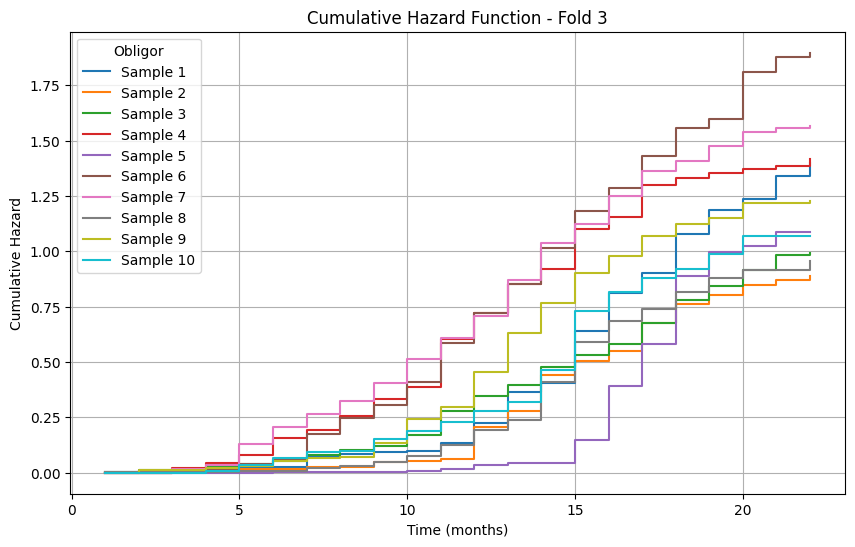

Fold 4 - Cumulative Hazard Function


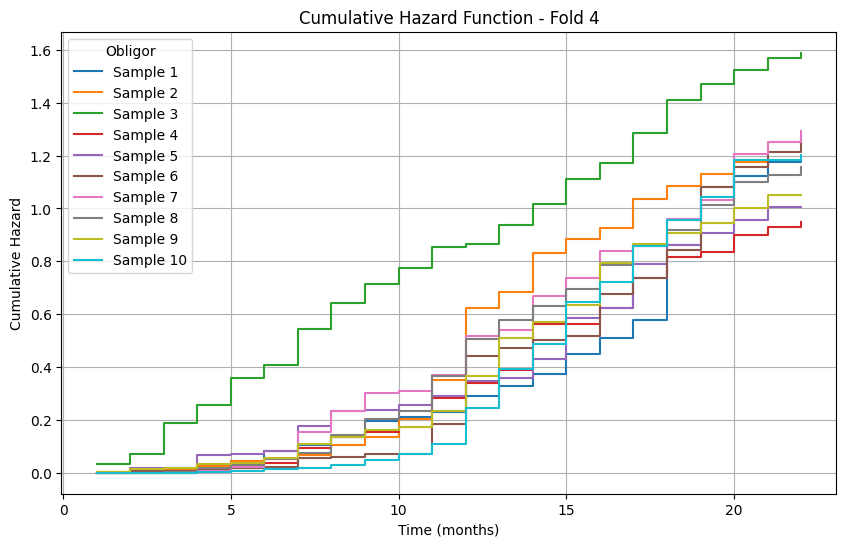

Fold 5 - Cumulative Hazard Function


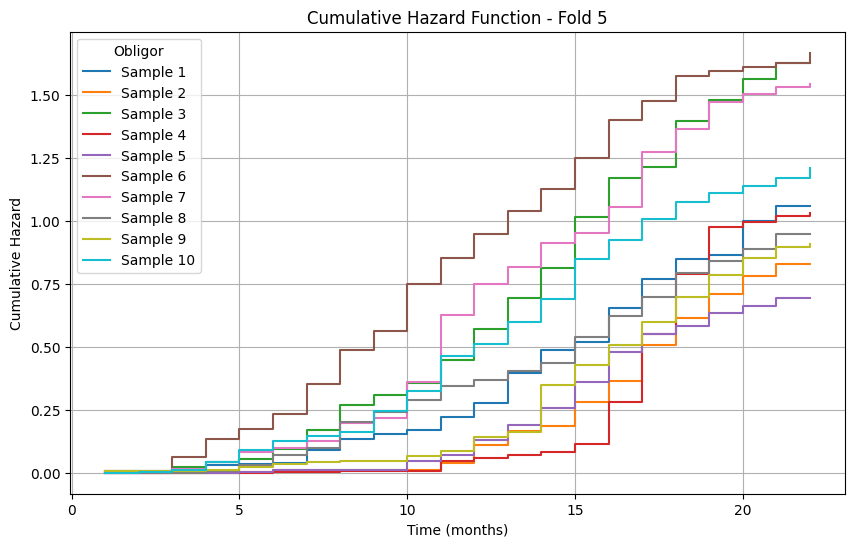

In [0]:
# Loop through each fold and plot cumulative hazard functions
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    print(f"Fold {i + 1} - Cumulative Hazard Function")
    
    # Preprocess the validation set
    X_val_preprocessed = preprocessor.transform(X_val)
    
    # Predict cumulative hazard function for the validation set
    cumulative_hazard = rsf.predict_cumulative_hazard_function(X_val_preprocessed, return_array=True)
    
    # Plot cumulative hazard functions for a subset of samples to avoid cluttering
    plt.figure(figsize=(10, 6))
    for j, h in enumerate(cumulative_hazard[:10]):  # Limit to the first 10 samples for clarity
        plt.step(rsf.unique_times_, h, where="post", label=f"Sample {j + 1}")
    
    plt.ylabel("Cumulative Hazard")
    plt.xlabel("Time (months)")
    plt.title(f"Cumulative Hazard Function - Fold {i + 1}")
    plt.legend(title="Obligor")
    plt.grid(True)
    plt.show()

#### 11.2 Survival Gradient Boosting

In [0]:
# Initialize Gradient Boosting Survival Analysis model
gbsa = GradientBoostingSurvivalAnalysis(random_state=42)

In [0]:
# Initialize list to hold metrics for each fold
results = []

# Cross-validation loop
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    print(f"\nFold {i+1} - Training and Evaluation")
    
    # Preprocess X_train and X_val separately
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_val_preprocessed = preprocessor.transform(X_val)
    
    # Extract the 'event' column for undersampling
    y_train_event = y_train['event']
    
    # Apply random undersampling
    rus = RandomUnderSampler(random_state=42)
    X_train_resampled, y_train_event_resampled = rus.fit_resample(X_train_preprocessed, y_train_event)
    y_train_time_resampled = y_train['time'][rus.sample_indices_]
    y_train_resampled = np.array(
        [(event, time) for event, time in zip(y_train_event_resampled, y_train_time_resampled)],
        dtype=[('event', '?'), ('time', '<f8')]
    )

    # Train GBSA model on undersampled data
    gbsa.fit(X_train_resampled, y_train_resampled)
    
    # Predict survival functions for the validation set
    surv = gbsa.predict_survival_function(X_val_preprocessed, return_array=True)
    
    # Choose survival probabilities at the 12th month
    time_point = 12
    time_index = np.argmin(np.abs(gbsa.unique_times_ - time_point))  # Closest index to 12 months
    survival_probabilities = surv[:, time_index]
    
    # Convert survival probabilities to binary classification using threshold 0.5
    y_pred = (survival_probabilities <= 0.5).astype(int)  # Default (1) if survival prob <= 0.5
    y_true = y_val['event'].astype(int)  # True labels
    
    # Predicted probabilities of default (1 - survival probability)
    y_pred_prob = 1 - survival_probabilities
    
    # Evaluate classification metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred_prob)
    
    # Precision-recall curve and AUC-PR
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_prob)
    auc_pr = auc(recall_curve, precision_curve)
    
    # Concordance index
    c_index = concordance_index_censored(
        y_val['event'], y_val['time'], y_pred_prob
    )[0]
    
    # Confusion matrix and classification report
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    
    print(f"\nFold {i+1} Results:")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)
    
    # Store results
    results.append({
        'fold': i + 1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': auc_roc,
        'auc_pr': auc_pr,
        'c_index': c_index
    })

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Add mean metrics as a new row
results_df.loc['mean'] = results_df.mean(numeric_only=True)

# Display results
print("\nCross-Validation Results (Fold-wise and Mean):")
results_df


Fold 1 - Training and Evaluation

Fold 1 Results:
Confusion Matrix:
 [[96743  1705]
 [ 3127  1101]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     98448
           1       0.39      0.26      0.31      4228

    accuracy                           0.95    102676
   macro avg       0.68      0.62      0.64    102676
weighted avg       0.94      0.95      0.95    102676


Fold 2 - Training and Evaluation

Fold 2 Results:
Confusion Matrix:
 [[97072  1761]
 [ 3002  1115]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     98833
           1       0.39      0.27      0.32      4117

    accuracy                           0.95    102950
   macro avg       0.68      0.63      0.65    102950
weighted avg       0.95      0.95      0.95    102950


Fold 3 - Training and Evaluation

Fold 3 Results:
Confusion Matrix:
 [[96950  2204]
 [ 2668  12

fold  accuracy  precision  ...   roc_auc    auc_pr   c_index
0      1.0  0.952939   0.392373  ...  0.808759  0.260505  0.871278
1      2.0  0.953735   0.387691  ...  0.808209  0.257898  0.874613
2      3.0  0.952722   0.357622  ...  0.806105  0.264679  0.895834
3      4.0  0.950487   0.329343  ...  0.809144  0.273406  0.912752
4      5.0  0.924755   0.219689  ...  0.809506  0.263004  0.932226
mean   3.0  0.946927   0.337344  ...  0.808345  0.263898  0.897340

[6 rows x 8 columns]

In [0]:
results_df.to_csv('training_performance_25_gbsa.csv', index=False)

Fold 1 - Survival Function


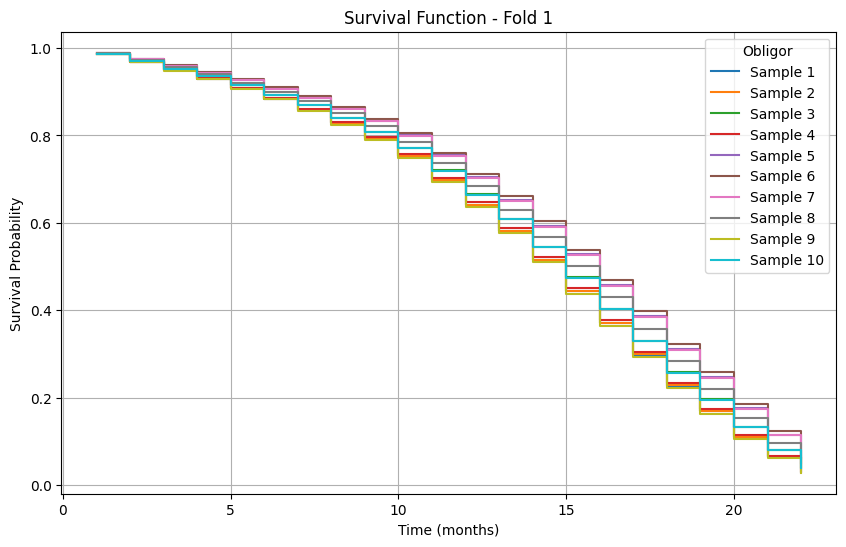

Fold 2 - Survival Function


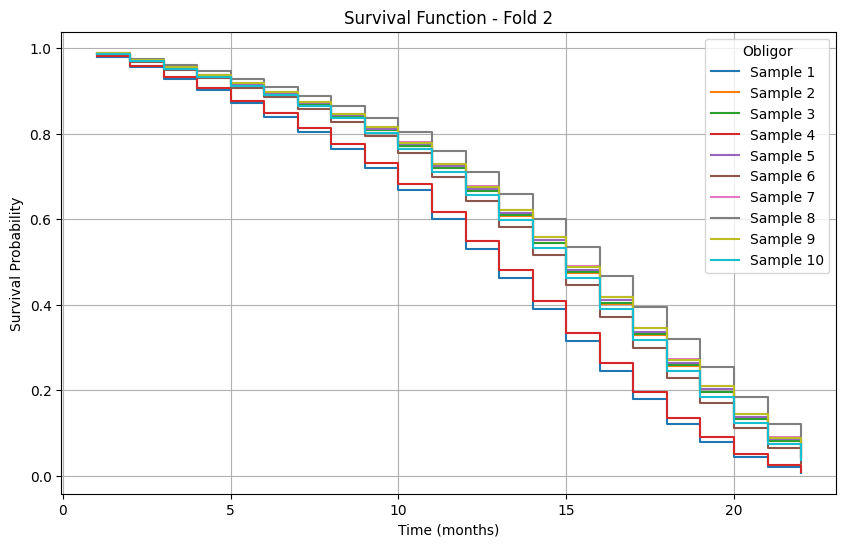

Fold 3 - Survival Function


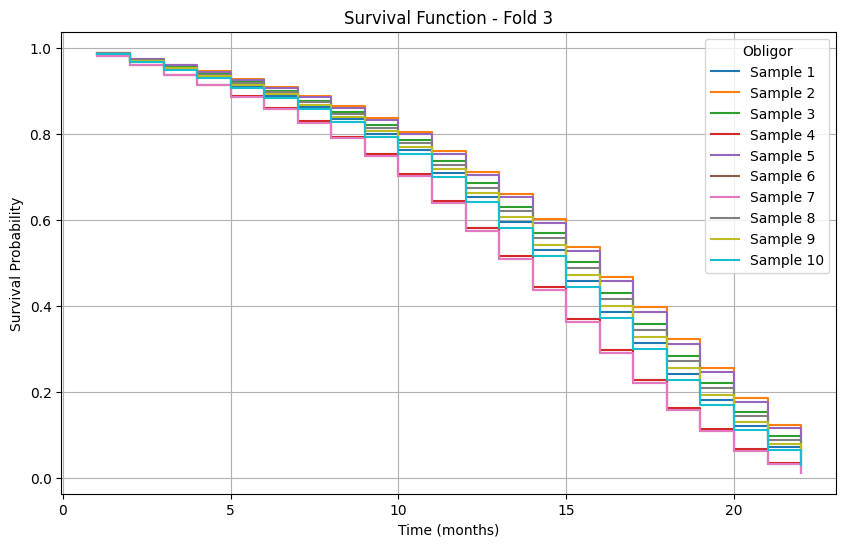

Fold 4 - Survival Function


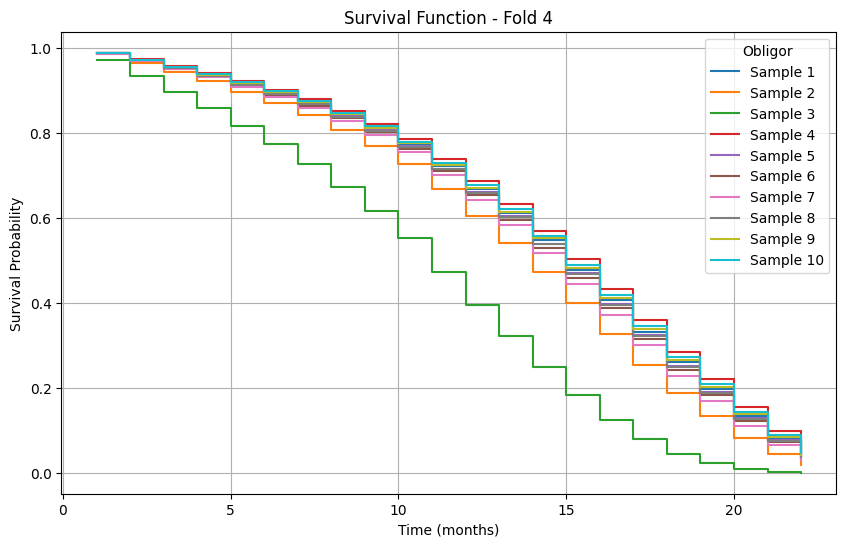

Fold 5 - Survival Function


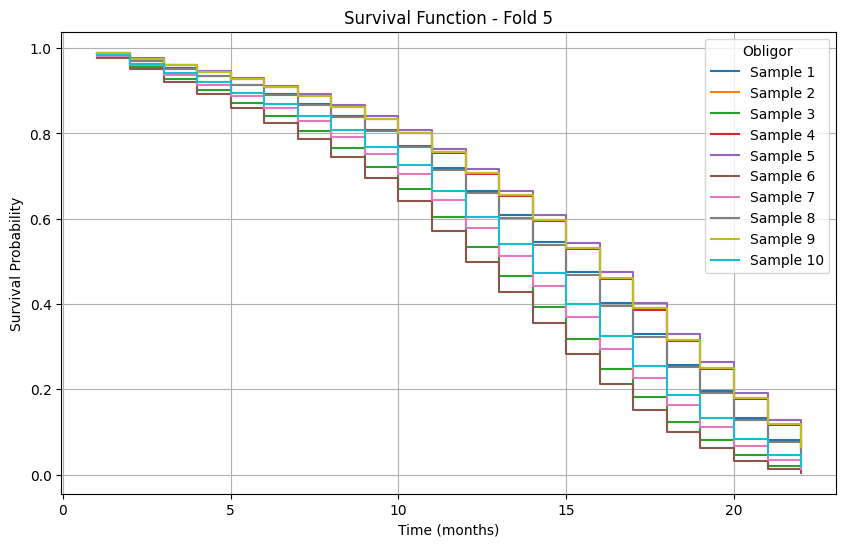

In [0]:
# Loop through each fold and plot survival functions
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    print(f"Fold {i + 1} - Survival Function")
    
    # Preprocess the validation set
    X_val_preprocessed = preprocessor.transform(X_val)
    
    # Predict survival function for the validation set
    surv = gbsa.predict_survival_function(X_val_preprocessed, return_array=True)
    
    # Plot survival functions for a subset of samples to avoid cluttering
    plt.figure(figsize=(10, 6))
    for j, s in enumerate(surv[:10]):  # Limit to the first 10 samples for clarity
        plt.step(gbsa.unique_times_, s, where="post", label=f"Sample {j + 1}")
    
    plt.ylabel("Survival Probability")
    plt.xlabel("Time (months)")
    plt.title(f"Survival Function - Fold {i + 1}")
    plt.legend(title="Obligor")
    plt.grid(True)
    plt.show()

Fold 1 - Cumulative Hazard Function


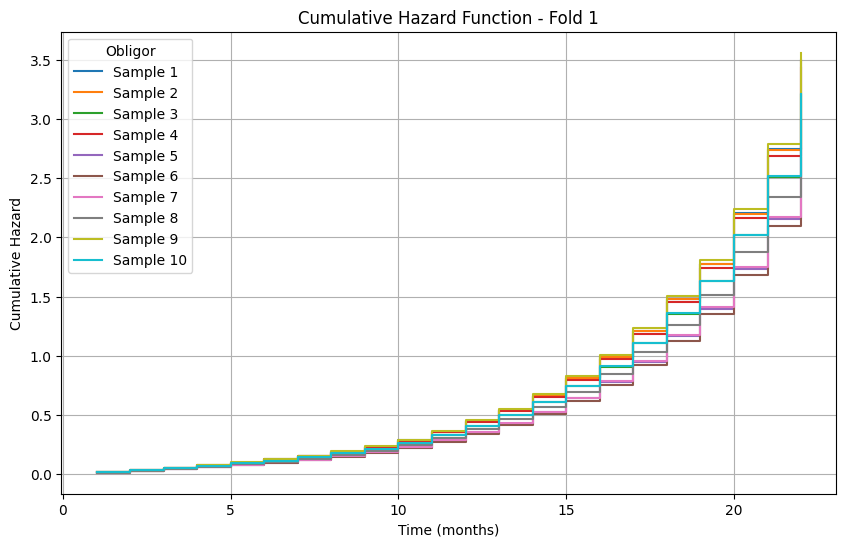

Fold 2 - Cumulative Hazard Function


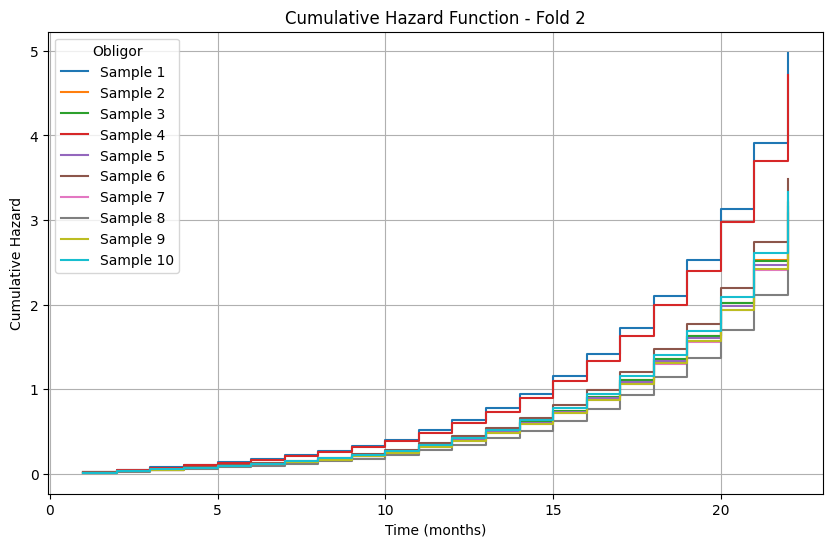

Fold 3 - Cumulative Hazard Function


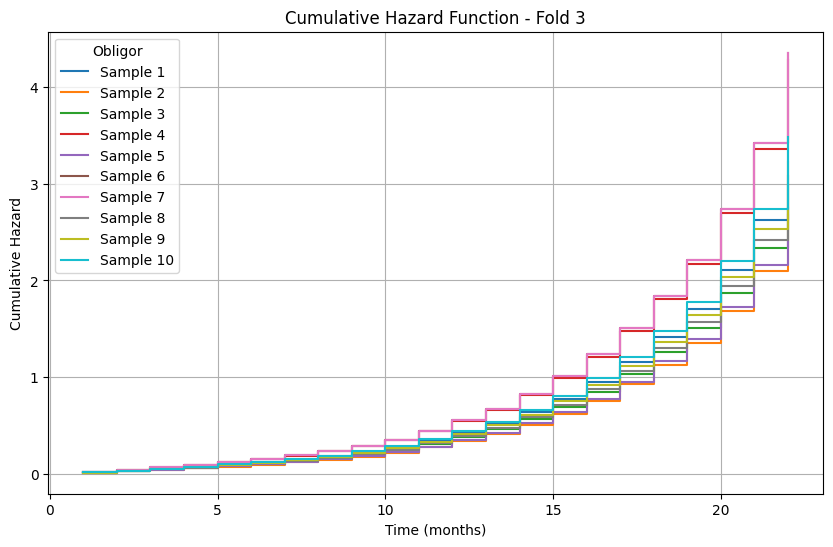

Fold 4 - Cumulative Hazard Function


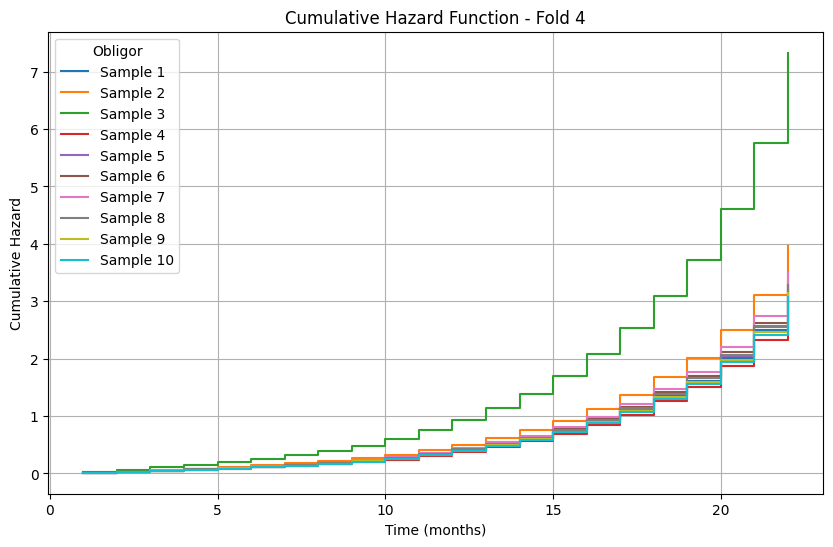

Fold 5 - Cumulative Hazard Function


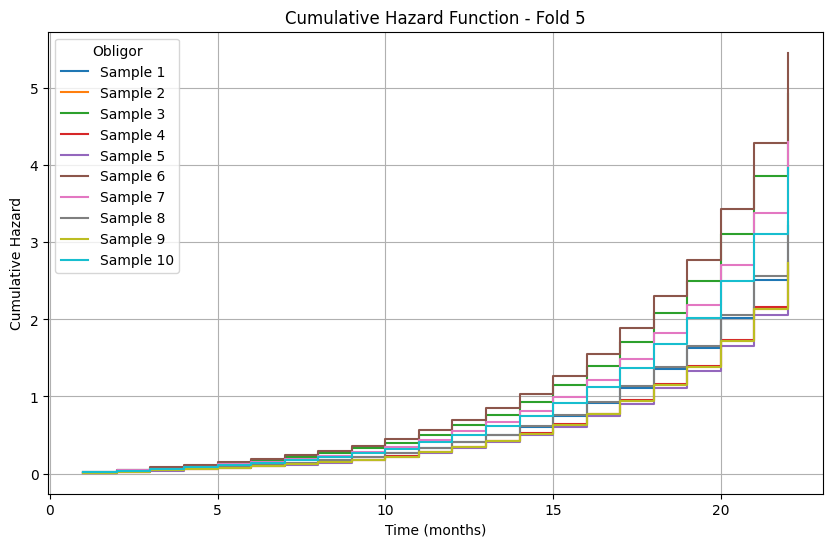

In [0]:
# Loop through each fold and plot cumulative hazard functions
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    print(f"Fold {i + 1} - Cumulative Hazard Function")
    
    # Preprocess the validation set
    X_val_preprocessed = preprocessor.transform(X_val)
    
    # Predict cumulative hazard function for the validation set
    cumulative_hazard = gbsa.predict_cumulative_hazard_function(X_val_preprocessed, return_array=True)
    
    # Plot cumulative hazard functions for a subset of samples to avoid cluttering
    plt.figure(figsize=(10, 6))
    for j, h in enumerate(cumulative_hazard[:10]):  # Limit to the first 10 samples for clarity
        plt.step(gbsa.unique_times_, h, where="post", label=f"Sample {j + 1}")
    
    plt.ylabel("Cumulative Hazard")
    plt.xlabel("Time (months)")
    plt.title(f"Cumulative Hazard Function - Fold {i + 1}")
    plt.legend(title="Obligor")
    plt.grid(True)
    plt.show()

In [0]:
# Feature Importance
# Initialize list to hold feature importances for each fold
feature_importances = []

# Loop through each fold
for i, (X_train, X_val, y_train, y_val) in enumerate(folds):
    print(f"\nFold {i+1} - Training and Feature Importance Calculation")
    
    # Preprocess training data
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    
    # Extract the 'event' column for undersampling
    y_train_event = y_train['event']
    
    # Apply random undersampling
    rus = RandomUnderSampler(random_state=42)
    X_train_resampled, y_train_event_resampled = rus.fit_resample(X_train_preprocessed, y_train_event)
    y_train_time_resampled = y_train['time'][rus.sample_indices_]
    y_train_resampled = np.array(
        [(event, time) for event, time in zip(y_train_event_resampled, y_train_time_resampled)],
        dtype=[('event', '?'), ('time', '<f8')]
    )

    # Train GBSA model
    gbsa.fit(X_train_resampled, y_train_resampled)
    
    # Extract feature importances for this fold
    fold_importances = gbsa.feature_importances_
    
    # Store the importance along with feature names and fold number
    feature_importances.append(pd.DataFrame({
        'Feature': X_train.columns,  # Replace with correct feature names
        'Importance': fold_importances,
        'Fold': i + 1
    }))

# Combine all fold feature importances into a single DataFrame
feature_importance_df = pd.concat(feature_importances)

# Calculate the average feature importance across all folds
average_importances = feature_importance_df.groupby('Feature')['Importance'].mean().reset_index()
average_importances = average_importances.sort_values(by='Importance', ascending=False)


Fold 1 - Training and Feature Importance Calculation

Fold 2 - Training and Feature Importance Calculation

Fold 3 - Training and Feature Importance Calculation

Fold 4 - Training and Feature Importance Calculation

Fold 5 - Training and Feature Importance Calculation


In [0]:
average_importances.to_csv('feature_importance_gbsa_cv_av.csv', index=False)
feature_importance_df.to_csv('feature_importance_gbsa_cv_all.csv', index=False)

In [0]:
# Display top 10 most important features based on the average importance
print("\nTop 10 Most Important Features:")
print(average_importances.head(10))


Top 10 Most Important Features:
                                   Feature  Importance
0                       ActiveInterestRate    0.475702
19              MaxDaysPastDue_Last3Months    0.158614
12                    ContractsBookedCount    0.080661
17  LifetimePayments_1To30DaysPastDueCount    0.057372
16                                Industry    0.057003
4     ApplicationExpectedInstallmentAmount    0.027764
9                             BusinessUnit    0.020844
18                          LineOfBusiness    0.020718
11             ContractsAge_Category3Count    0.019596
14                Exposure_to_NetPrincipal    0.014241


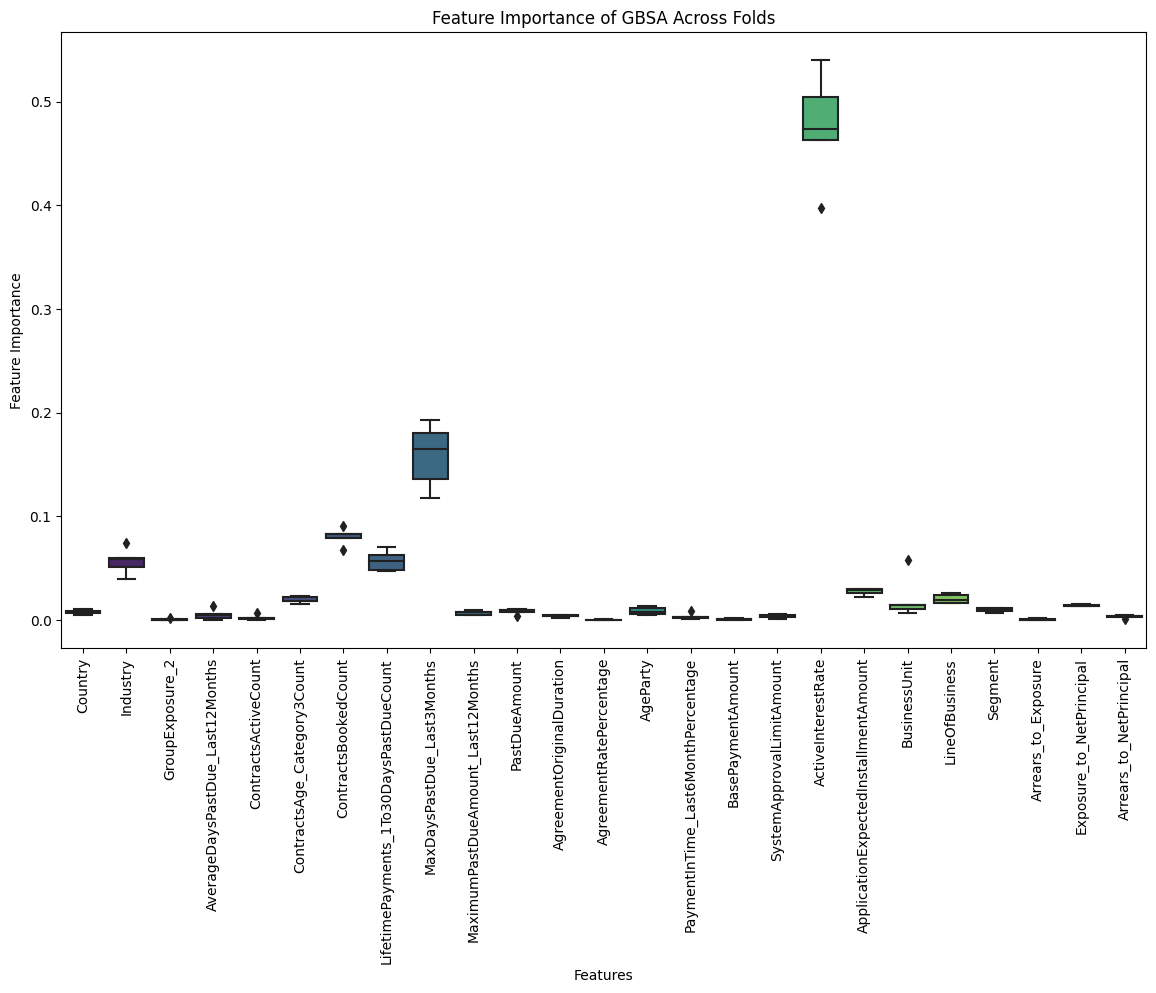

In [0]:
# Plot the box plot of feature importance across folds
plt.figure(figsize=(14, 8))
sns.boxplot(x='Feature', y='Importance', data=feature_importance_df, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importance of GBSA Across Folds')
plt.savefig("feature_importance_gbsa_cv_boxplot.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

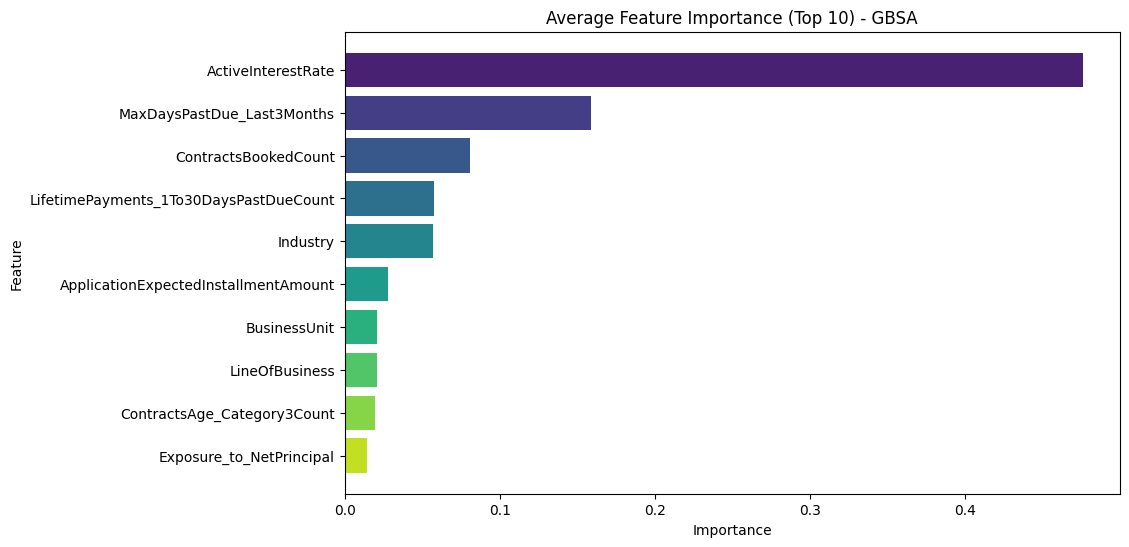

In [0]:
# Plot feature importance
colors = sns.color_palette("viridis", len(average_importances[:10]))
plt.figure(figsize=(10, 6))
plt.barh(average_importances['Feature'][:10], average_importances['Importance'][:10], color=colors)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Average Feature Importance (Top 10) - GBSA")
plt.gca().invert_yaxis()
plt.savefig("feature_importance_gbsa_cv_av_barplot.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

In [0]:
# Preprocess the training data
X_train_preprocessed = preprocessor.fit_transform(X)

# Apply Random UnderSampler on training data
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_event_resampled = rus.fit_resample(X_train_preprocessed, y[event_column])
y_train_time_resampled = y[time_column][rus.sample_indices_]
y_train_resampled = np.array(
    [(event, time) for event, time in zip(y_train_event_resampled, y_train_time_resampled)],
    dtype=[('event', '?'), ('time', '<f8')]
)

# Train GBSA model on the entire training set
gbsa = GradientBoostingSurvivalAnalysis(random_state=42)
gbsa.fit(X_train_resampled, y_train_resampled)

# Exclude target columns (event_column and time_column) from the test dataset
X_test = test_modelling_df_surv.drop(columns=[event_column, time_column], errors='ignore')

# Preprocess the test data
X_test_preprocessed = preprocessor.transform(X_test)

# Predict survival functions for the test dataset
surv = gbsa.predict_survival_function(X_test_preprocessed, return_array=True)

# Choose survival probabilities at a specific time point (e.g., 12 months)
time_point = 12
time_index = np.argmin(np.abs(np.linspace(0, surv.shape[1] - 1, surv.shape[1]) - time_point))  # Closest index to 12 months
survival_probabilities = surv[:, time_index]

# Convert survival probabilities to binary classification using threshold 0.5
y_pred = (survival_probabilities <= 0.5).astype(int)  # Default (1) if survival prob <= 0.5
y_true = test_modelling_df_surv[event_column].astype(int)  # True labels (as integers for classification)

# Predicted probabilities of default (1 - survival probability)
y_pred_prob = 1 - survival_probabilities

# Evaluate classification metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_roc = roc_auc_score(y_true, y_pred_prob)

# Precision-recall curve and AUC-PR
precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_prob)
auc_pr = auc(recall_curve, precision_curve)

# Concordance Index
c_index = concordance_index_censored(
    test_modelling_df_surv[event_column].astype(bool),  # Convert to boolean
    test_modelling_df_surv[time_column],
    y_pred_prob
)[0]

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Display test performance
print("Test Performance of GBSA Model:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {auc_roc:.4f}")
print(f"AUC-PR: {auc_pr:.4f}")
print(f"Concordance Index (C-Index): {c_index:.4f}")

# Display confusion matrix
print("\nConfusion Matrix:")
print(cm)

Test Performance of GBSA Model:
Accuracy: 0.9323
Precision: 0.2236
Recall: 0.4931
F1-Score: 0.3077
ROC-AUC: 0.8266
AUC-PR: 0.2735
Concordance Index (C-Index): 0.9243

Confusion Matrix:
[[142137   8096]
 [  2397   2332]]


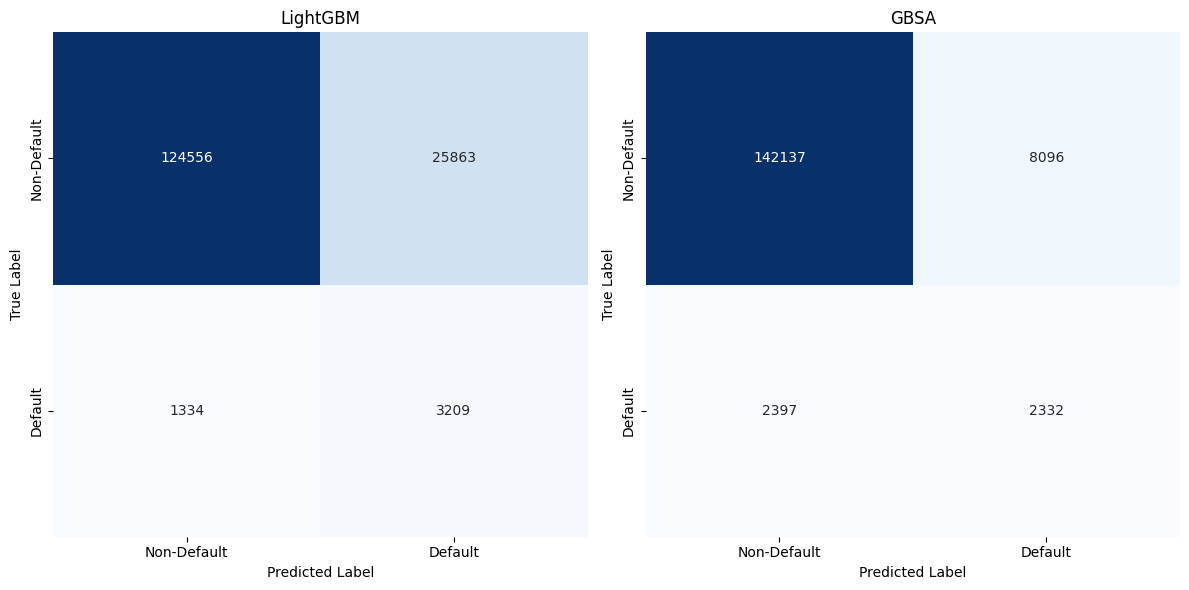

In [0]:
data = {
    'Model': ['LightGBM', 'GBSA'],
    'ConfusionMatrix': [
        [[124556, 25863], [1334, 3209]],
        [[142137, 8096], [2397, 2332]]
    ]
}

# Convert to pandas DataFrame
df = pd.DataFrame(data)

# Extract confusion matrices for plotting
conf_matrix_lightgbm = np.array(df.loc[df['Model'] == 'LightGBM', 'ConfusionMatrix'].values[0])
conf_matrix_gbsa = np.array(df.loc[df['Model'] == 'GBSA', 'ConfusionMatrix'].values[0])

# Plot the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot LightGBM confusion matrix
sns.heatmap(conf_matrix_lightgbm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('LightGBM')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_xticklabels(['Non-Default', 'Default'])
axes[0].set_yticklabels(['Non-Default', 'Default'])

# Plot GBSA confusion matrix
sns.heatmap(conf_matrix_gbsa, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_title('GBSA')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_xticklabels(['Non-Default', 'Default'])
axes[1].set_yticklabels(['Non-Default', 'Default'])

plt.tight_layout()
plt.show()